In [39]:
import numpy as np
import numpy.ma as ma 

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle,Circle, Ellipse
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid.anchored_artists import AnchoredAuxTransformBox
from matplotlib.ticker import MaxNLocator


import scipy.optimize as so

import sys
import shutil        

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
from astropy import constants as const
from astropy.table import Table, Column
from astropy.io import fits
from astropy.wcs import WCS

from specutils import Spectrum1D,SpectralRegion
from specutils.analysis import line_flux, gaussian_fwhm, centroid, gaussian_sigma_width, fwhm
from specutils.fitting import fit_lines
from spectral_cube import SpectralCube



All new figures for the paper will be held in the Shark-new-publi folder where this notebook is located under Shark folder

In [40]:
mpl.rc ('xtick',labelsize=15)
mpl.rc ('ytick',labelsize=15)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)
grey='#cccccc'
grey_text="#666666"
yellow='#ffdb00'
red='ff2500'
mpl.rcParams['hatch.linewidth'] = 1.0
mpl.rcParams['axes.linewidth'] = 1

In [41]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def what_z(lam1,lam0):
    return lam0/lam1 -1.
def CO_Lum_prime(z,fobs, Int_flux):

    dL = cosmo.luminosity_distance(z).value
    Lline_prime = 3.257e7 * Int_flux *  dL**2/(1+z)**3 / fobs**2 #K km/s pc^2

    return Lline_prime


def Mmol(Lco10,alpha=4.):
    
    #returns LCO(1-0)' (K km/s pc^2) and  the H2 mas in Msol

    Mmol = alpha * Lco10
    return Mmol

def CO10_Lum_prime(z,Int_flux):
    co = 115.27

    dL = cosmo.luminosity_distance(z).value
    Lline_prime = 3.257e7 * Int_flux *  dL**2/(1+z)/co**2 #K km/s pc^2

    return Lline_prime

### Poissonian limits from Gehrels et al. 2018 APJ 303
def Poiss_upper_limit(n, S):
    lambda_up = n + S * np.sqrt(n+1) + (S**2+2)/3.
    return lambda_up

def Poiss_lower_limit(n, S):
    lambda_down= n-S*np.sqrt(n)+ (S**2-1)/3.
    #Beta, Gamma =[0,0.062,0.222], [0,-2.19,-1.88]
    # if n == 0: gamma=0
    # else: gamma=Gamma[S-1]
    # lambda_down = n*(1 - 1/9*n - S /3*np.sqrt(n) + Beta[S-1]*n**gamma)**3
    return lambda_down

def fov(freq):
	#frequency in in GHz
	freq*=1e9
	c = 3.e8
	d = 12.
	FOV = np.degrees(1.22*c/d/freq)*3600 #in arcsec
	return FOV

def CO_Lum(z,fCO, Sline, dv=200):
	
	# z - line's redshift
	# fCO -  rest frequency of the chosen transition [GHz] 
	# Sline - strength of the signal n*rms [Jy]
	# dv - velocity span of the signal [km/s]

	# Lline [L_sol]

	dL = cosmo.luminosity_distance(z).value
	f_obs = fCO/(1+z)
	Lline = 1.04e-3 * Sline * dv * dL**2 * f_obs # L_sol
	return Lline*u.astrophys.solLum

def CO_Lum_prime_vol(Lline, fCO):
	# LLine - result of CO_Lum 
	# fCO - rest frequency of the chosen transition [GHz] 

	Lline_prime = Lline/ 3.e-11 / fCO**3
	return Lline_prime
def CO_Lum_prime_vol2(z,fCO, Sline, dv=200):
	#K km/s pc^2
	dL = cosmo.luminosity_distance(z).value
	f_obs = fCO/(1+z)
	Lline_prime = 3.47e7 * Sline * dv *  dL**2/(1+z)**3 / f_obs**2
	return Lline_prime

def L_CO_prime_inv(LCO,fCO,cr,Sline,dv=200):
	func = LCO*cr*fCO**2/(3.47e7 * Sline * dv )
	return func

def sensitivity_function(r, mu, sigma):

	I = np.exp(-np.power(r - mu, 2.) / (2 * np.power(sigma, 2.)))

	return I

def E(z):
	#Planck15 cosmology
	Om_M = cosmo.Om0 #Omega matter
	Om_L = 1-Om_M # omega Lambda , since Omega_k = 0
	#Om_k = 1- Om_M - Om_L # = 0 flat Universe

	E = np.sqrt(Om_M*(1+z)**3 + Om_L)
	return E

In [42]:
CO_labels = ["CO(1-0)","CO(2-1)","CO(3-2)","CO(4-3)","CO(5-4)","CO(6-5)","CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)"]
CO_J = np.array([115.2712018, 230.538, 345.7959899, 461.0407682, 576.2679305, 691.4730763, 806.651806, 921.7997, 1036.912393, 1151.985452 ])
Z = np.linspace(0,8,10000)

band3=np.linspace(83,116,1000)#GHz 116-83
b31,b32 = 116,83
band6=np.linspace(211,275,1000)#GHz
b61,b62 = 275,211
band7=np.linspace(275,373,1000)#GHz
b71,b72=373,275
band8=np.linspace(385,500,1000)#GHz
b81,b82=500,385
band9=np.linspace(602,720,1000)#GHz
b91,b92 = 720,602

### sensitivity limits, assumption
sigma = 0.34 #mJy/beam
n = [3,5,7]
vol = 300 #km/s

In [44]:
#ALMACAL detections
almacal = np.loadtxt("candidates_list.txt", usecols=(8,9,12,13,10)) #vel(0), err(1), flux(2), err(3), f0(4)


In [45]:
#Shark catalogue of galaxies
#galaxy_catalogue=np.loadtxt('catalogue-for-almacal-new.txt')


# Plot the flux distribution of Shark CO emission galaxies

In [46]:
# Plot 
xdata = galaxy_catalogue.T[2]
nbins_x,nbins_y=40,40
with PdfPages('Shark-CO-Iz.pdf') as Pdf:
    
    for i in range(8):

        fig=plt.figure(1,figsize=(8,8))
        ax = fig.add_subplot(111)
        ydata = np.log10(galaxy_catalogue.T[10+i])
        H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
        x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
        y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

        pdf = (H*(x_bin_sizes*y_bin_sizes))

        low_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.01))
        twenty_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.2))
        thirty_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.3))
        forty_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.4))
        fifty_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.5))
        one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
        eighty_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.8))
        ninty_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.9))
        two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
        three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
        levels = [three_sigma, two_sigma, ninty_sigma, eighty_sigma, one_sigma, fifty_sigma, forty_sigma, thirty_sigma, twenty_sigma, low_sigma]

        X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
        Z = pdf.T
        # The viridis colormap is only available since mpl 1.5
        extra_args = {}
        if tuple(mpl.__version__.split('.')) >= ('1', '5'):
            extra_args['cmap'] = plt.get_cmap('viridis')

        plt.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.75, norm=col.Normalize(vmin=0, vmax=0.01), **extra_args)
        plt.xlabel("z", fontsize=15)
        plt.ylabel(r"log( SCO "+CO_labels[i]+ ") [mJy km/s]", fontsize=15)
        #plt.annotate(labels[i],(0.1,0.85),xycoords='axes fraction', fontsize=15) 
        #plt.yscale('log')
        
        # ALMA bands
        l0 = CO_J[i]
        y0=4.8
        edges = [what_z(b31,l0),what_z(b32,l0)]  
        if min(edges) > -0.1:
            ax.add_patch(patches.Rectangle((min(edges), -1),abs(edges[0]-edges[1]),8,ec=grey, hatch='//////',fc='none'))
            ax.text( np.median(edges), y0, 'ALMA 3',rotation=90, horizontalalignment='center', verticalalignment='center',fontsize=12,color=grey_text)
        edges = [what_z(b61,l0),what_z(b62,l0)]  
        if min(edges) > -0.1:
            ax.add_patch(patches.Rectangle((min(edges), -1),abs(edges[0]-edges[1]),8,ec=grey, hatch='//////',fc='none'))
            ax.text( np.median(edges), y0, 'ALMA 6',rotation=90, horizontalalignment='center', verticalalignment='center',fontsize=12,color=grey_text)
        
        edges = [what_z(b71,l0),what_z(b72,l0)]  
        if min(edges) > -0.1:
            ax.add_patch(patches.Rectangle((min(edges), -1),abs(edges[0]-edges[1]),8,ec=grey, hatch='//////',fc='none'))
            ax.text( np.median(edges), y0, 'ALMA 7',rotation=90, horizontalalignment='center', verticalalignment='center',fontsize=12,color=grey_text)
        edges = [what_z(b81,l0),what_z(b82,l0)]  
        if min(edges) > -0.1:
            ax.add_patch(patches.Rectangle((min(edges), -1),abs(edges[0]-edges[1]),8,ec=grey, hatch='//////',fc='none'))
            ax.text( np.median(edges), y0, 'ALMA 8',rotation=90, horizontalalignment='center', verticalalignment='center',fontsize=12,color=grey_text)
        edges = [what_z(b91,l0),what_z(b92,l0)]  
        if min(edges) > -0.1:
            ax.add_patch(patches.Rectangle((min(edges), -1),abs(edges[0]-edges[1]),8,ec=grey, hatch='//////',fc='none'))
            ax.text( np.median(edges), y0, 'ALMA 9',rotation=90, horizontalalignment='center', verticalalignment='center',fontsize=12,color=grey_text)

        #sensitivity limit
        
        #plt.axhline(np.log10(n[0]*sigma*vol), ls='--', c='r',lw=1, label=r"3$\sigma$")#3sig
#        plt.axhline(n[1]*sigma*vol, ls='--', c='k',lw=1) #5sig
        #plt.axhline(np.log10(n[2]*sigma*vol), ls='--', c='g',lw=1, label=r"7$\sigma$") #7sig
        #plt.legend()
        plt.xlim([-.3, 6])
        plt.ylim([-1, 5.5])
        #plt.yscale("log")
        Pdf.savefig()
        plt.show()
        plt.close()

NameError: name 'galaxy_catalogue' is not defined

### Analysis of the data in Topcat
median flux in z bins -topcat, also create median sleds  <br>
new file including just redshfit and CO flux information: <i>Shark-flux-z.txt</i>


[2.81300e+02 1.16293e+03 2.09029e+03 2.49168e+03 1.94780e+03 8.04990e+02
 1.70382e+02 2.68607e+01 3.84894e+00 5.59637e-01]


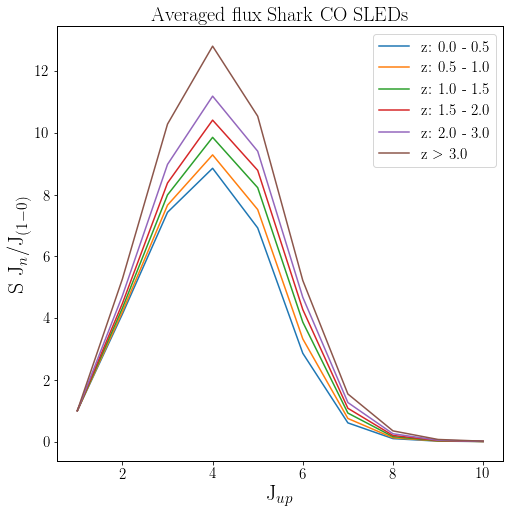

In [47]:
#flux in z bin - Shark avegare SLEDs
#z bins
zbins=np.array([[0,0.5],[0.5,1.0],[1.0,1.5],[2.0,3.0],[3.,6]])
#[] - J from 1 to 10 each row? and then inz bins in collumns
Shark_flux= np.array([[281.3, 1162.93,2090.29, 2491.68, 1947.8, 804.99, 170.382, 26.8607, 3.84894, 0.559637],
                    [72.3317, 304.536, 554.242, 672.139, 543.883, 240.71, 54.137, 8.91055, 1.32175, 0.19761],
                    [ 37.6523, 162.958, 301.036, 371.263, 309.85, 145.79, 34.7695, 6.00377, 0.92925, 0.143964],
                    [ 23.109, 103.507, 193.674, 240.766, 203.141, 98.8797, 24.929, 4.57153, 0.749843, 0.12185],
                    [14.3, 67.6, 128.46, 160.096, 134.57, 66.87,18.096, 3.61, 0.64, 0.11],
                    [8.26, 43.56, 84.99, 105.86, 87.11, 43.13, 12.74, 2.86, 0.563, 0.105]])
Shark_flux_sd = np.array([[3163.39, 12834]])
print(Shark_flux[0])
plt.figure(figsize=(8,8))
J = range(1,11,1)
labels=['z: 0.0 - 0.5', 'z: 0.5 - 1.0', 'z: 1.0 - 1.5', 'z: 1.5 - 2.0', 'z: 2.0 - 3.0', r'z $>$ 3.0']
for i in range(6):
    l10=Shark_flux[i][0]
    sled=Shark_flux[i]/l10
    plt.plot(J, sled,label=labels[i])
plt.legend(fontsize=15)
plt.xlabel(r"J$_{up}$", fontsize=22)
plt.ylabel(r"S J$_{n}$/J$_{(1-0)}$", fontsize=22)
plt.title("Averaged flux Shark CO SLEDs", fontsize=20)
plt.show()



# Create the histograms 

create the histogram bins and flux histogram for each transition

In [48]:
nj = 10 # number of transitions
M = nj * np.size(xdata)
    
#binning must be the same for all histograms, binedges z: min(z), max(z), and form min(fluxj) to max(fluxj) over all transitrions
nbins=81 #1d number of bins

#find the edges of the ybins 
minj,maxj = [],[]
for j in range(nj):
    if min(np.log10(galaxy_catalogue.T[j+10])) > -np.inf:
        minj.append(min(np.log10(galaxy_catalogue.T[j+10])))

    maxj.append(max(np.log10(galaxy_catalogue.T[j+10])))

minj, maxj = np.array(minj, dtype='float'),np.array(maxj, dtype='float')
print(min(xdata), max(xdata),min(minj), max(maxj))
xedges = np.linspace(min(xdata), max(xdata), nbins) ## xbins - range of z
yedges = np.linspace(min(minj), max(maxj), nbins) #xbins - fluxes including all tranistions

NameError: name 'xdata' is not defined

In [49]:
#save bins
np.save("xbins_new",xedges)
np.save("ybins_new",yedges)


## histogram for each transition
####
Nprob = []
COprob = []
ydata
for j in range(nj):
    print(j)

    ydata_log = np.log10(galaxy_catalogue.T[10+j])

    H, xe, ye = np.histogram2d(xdata, ydata_log, bins=(xedges,yedges))

    np.save(CO_labels[j]+"_new_hist",H.T)
    plt.figure()
    plt.imshow(H.T, origin='bottom',extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]))

NameError: name 'ydata' is not defined

All histograms are created on the same bins grid. X anc y grids have same edges. Change: iunsteado of creating new I(1-0) histograms (which I am not sure why I had to made), I created a CO lien ratio histograms.

In [50]:
# AVERAGE SLED
# TOPCAT

In [51]:
# # Divide the `Jn histogram through the J(1-0) histogram to get the flux ratio 2dhistogram. The ratios will allow to eetrieve the corresponding I_CO(1-0)

nbins=np.size(xedges)
K = np.size(galaxy_catalogue.T[0])
print(nbins, K)
lco10=[]
J = 11
for J in range(11,20,1):
    #go throuth different transitions
    print(J)  
    HJco10 =np.zeros((nbins,nbins))
    HJco10_sig = np.zeros((nbins,nbins))

    for k in range(K): # go through the catalogue
      
        z = galaxy_catalogue.T[2][k]
        Ico = np.log10(galaxy_catalogue.T[J][k])
        for i in range(nbins-1): #find position on the histogram
             for j in range(nbins-1):
                if (xedges[i] <= z <=  xedges[i+1]) and (yedges[j] <= Ico <= yedges[j+1]):
                    #locate gaalxies belonging to the particular part of the histogram and read out their I_CO(1-0)
                    HJco10[j][i] += np.log10(galaxy_catalogue.T[10][k])
                    
    HJco10=np.meadian(HJco10)
    HJco10_sig[j][i] = np.std(HJco10)
    np.save("I_CO1_"+str(J-9)+".npy",HJco10)


NameError: name 'galaxy_catalogue' is not defined

0.1865284974093264
0.4923622110660688
0.8190823914735965
1.2666111841928642
0.0612135111964


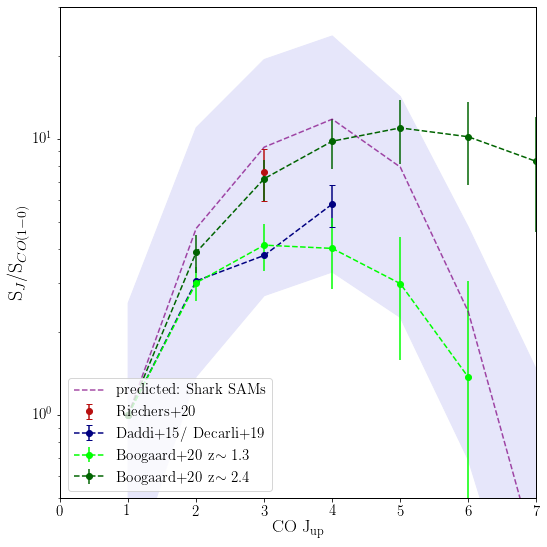

In [52]:
## shark SLED vs observed

fig=plt.figure(1,figsize=(8,8))
sled = np.loadtxt("coSledShark.txt")
#Daddi detections
det = np.array([0.193,0.59,0.73,1.12])
det_err = np.array([0.018, 0.04,0.09,0.14])
det_sled_err = np.array([0]*4)

#VLASPEC
det3171 = np.array([1,0.84]) * (CO_J[2]/CO_J[0])**2
det3171_err = np.array([0,0.18])

#M82 
m82_sled=np.array([1,4.31,9.61,12.55])

#Bboogaaerd 2020 model
sled_boo_z1 = np.array([1, 3.01, 4.12, 4.01, 2.99, 1.37])
sled_boo_z1_err = np.array([0,0.43, 0.8, 1.14, 1.41, 1.69])

sled_boo_z2 = np.array([1, 3.88, 7.17, 9.80, 10.95, 10.17, 8.28, 5.55])
sled_boo_z2_err = np.array([0, 0.62, 1.24, 2.01, 2.84, 3.39, 3.67, 3.87])

c='#b81010'
plt.errorbar(3, 0.84 * (CO_J[2]/CO_J[0])**2, yerr=0.18 * (CO_J[2]/CO_J[0])**2, fmt='o', color=c, capsize=3, label='Riechers+20')

for i in range(4):
	dr = det[i]/det[0] * (det_err[i]/det[i]+det_err[0]/det[0])
	det_sled_err[i] = dr
	print(dr)
fig=plt.figure(1,figsize=(6,6))
#plt.subplot(121)

Y = sled.T[1]/sled.T[1][0] 

plt.plot(sled.T[0],Y, 'purple', ls='--', alpha=0.7, label='predicted: Shark SAMs')
plt.fill_between(sled.T[0],(sled.T[1]-sled.T[2])/sled.T[1][0],(sled.T[1]+sled.T[3])/sled.T[1][0], color='lavender')
plt.errorbar(range(1,5),det/det[0], yerr=det_sled_err, c='navy', fmt='--o',capsize=3, label='Daddi+15/ Decarli+19')

#plt.plot(range(1,5,1),m82_sled, 'gx:', ms=10, markeredgewidth=3, label='M82, Weiss+05')
print(sled.T[1][0])



plt.errorbar(range(1,7,1),sled_boo_z1, yerr =sled_boo_z1_err , c='lime', fmt='--o' , label=r'Boogaard+20 z$\sim$ 1.3')
plt.errorbar(range(1,9,1),sled_boo_z2, yerr =sled_boo_z2_err , c='darkgreen', fmt='--o', label=r'Boogaard+20 z$\sim$ 2.4' )


plt.xlabel(r"CO J$_{\rm up}$ ", fontsize=18)
plt.ylabel(r"S$_J$/S$_{CO(1-0)}$", fontsize=20)
plt.legend(fontsize=15, loc=3)
plt.ylim([0.5,30])
plt.xlim([0,7])
plt.yscale("log")
plt.tight_layout()

fig.savefig("SharkSled.png")

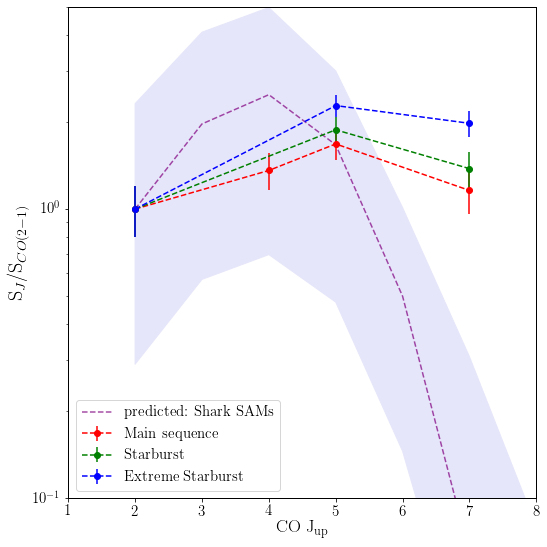

In [53]:
## shark SLED vs observed

fig=plt.figure(1,figsize=(8,8))
sled = np.loadtxt("coSledShark.txt")


c='#b81010'

Y = sled.T[1]/sled.T[1][1] 

plt.plot(sled.T[0][1:],Y[1:], 'purple', ls='--', alpha=0.7, label='predicted: Shark SAMs')
plt.fill_between(sled.T[0][1:],(sled.T[1][1:]-sled.T[2][1:])/sled.T[1][1],(sled.T[1][1:]+sled.T[3][1:])/sled.T[1][1], color='lavender')

#plt.plot(range(1,5,1),m82_sled, 'gx:', ms=10, markeredgewidth=3, label='M82, Weiss+05')
#Daddi detections
det = np.array([0.193,0.59,0.73,1.12])
det_err = np.array([0.018, 0.04,0.09,0.14])
det_sled_err = np.array([0]*4)


#Valentino 2020 
MS = np.array([1, 1.36, 1.68, 1.16])
MS_err = np.array([0.2, 0.2, 0.2, 0.2])
MS_J = np.array([2,4,5,7])


SB  = np.array([1, 1.88, 1.38])
SB_err = np.array([0.24, 0.08, 0.05])
SB_J = np.array([2,5,7])

eSB = np.array([1, 2.28, 1.98])
eSB_err = np.array([0.27, 0.12, 0.06])
eSB_J = np.array([2,5,7])

plt.errorbar(MS_J, MS, yerr=0.2, fmt='o--', color='red', label='Main sequence')
plt.errorbar(SB_J, SB, yerr=0.2, fmt='o--', color='green', label='Starburst')
plt.errorbar(eSB_J, eSB, yerr=0.2, fmt='o--', color='blue', label='Extreme Starburst')


plt.xlabel(r"CO J$_{\rm up}$ ", fontsize=18)
plt.ylabel(r"S$_J$/S$_{CO(2-1)}$", fontsize=20)
plt.legend(fontsize=15, loc=3)
plt.ylim([0.1,5])
plt.xlim([1,8])
plt.yscale("log")
plt.tight_layout()

fig.savefig("SharkSled21.png")

# Test Shark predictions on the previous surveys detections

Tested transition C1 z = 2.48 J = CO(1-0)
transition CO(1-0) z = 2.478 probability 99.909
transition CO(2-1) z = 5.956 probability 0.091


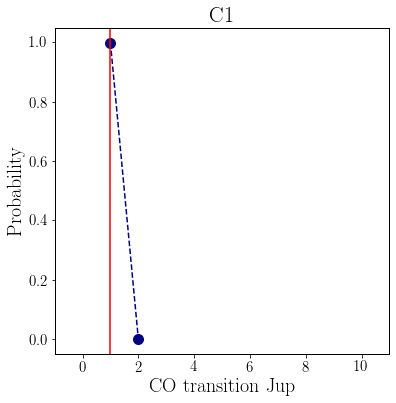

Tested transition C2 z = 5.297 J = CO(2-1)
transition CO(1-0) z = 2.149 probability 100.0
transition CO(2-1) z = 5.297 probability 0.0


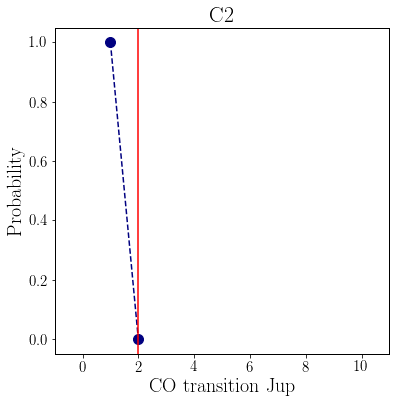

Tested transition C3 z = 2.668 J = CO(1-0)
transition CO(1-0) z = 2.668 probability 100.0
transition CO(2-1) z = 6.335 probability 0.0


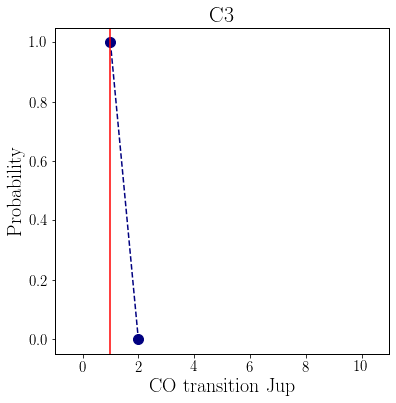

Tested transition C4 z = 2.477 J = CO(1-0)
transition CO(1-0) z = 2.477 probability 100.0
transition CO(2-1) z = 5.954 probability 0.0


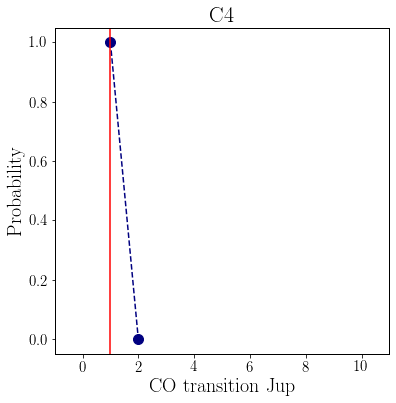

Tested transition C5 z = 1.969 J = CO(1-0)
transition CO(1-0) z = 1.969 probability 100.0
transition CO(2-1) z = 4.938 probability 0.0


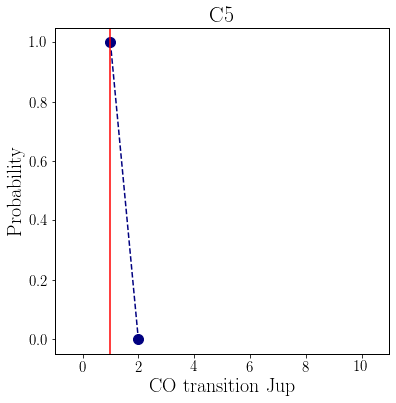

Tested transition C6 z = 5.303 J = CO(2-1)
transition CO(1-0) z = 2.151 probability 100.0
transition CO(2-1) z = 5.303 probability 0.0


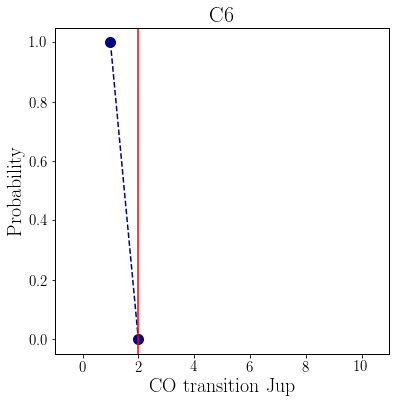

Tested transition C7 z = 2.488 J = CO(1-0)
transition CO(1-0) z = 2.488 probability 100.0
transition CO(2-1) z = 5.975 probability 0.0


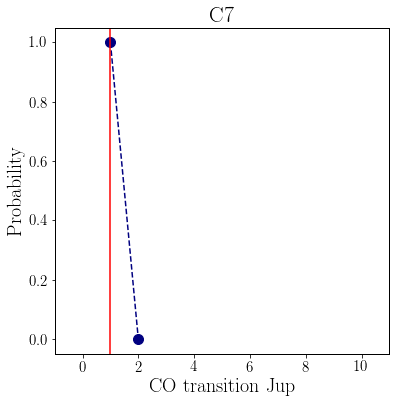

Tested transition C8 z = 5.183 J = CO(2-1)
transition CO(1-0) z = 2.092 probability 100.0
transition CO(2-1) z = 5.183 probability 0.0


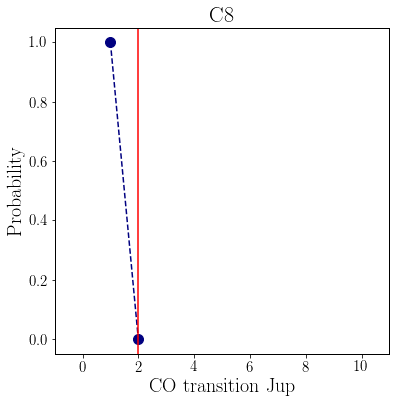

Tested transition A1 z = 2.543 J = CO(3-2)
transition CO(1-0) z = 0.181 probability 43.167
transition CO(2-1) z = 1.363 probability 49.038
transition CO(3-2) z = 2.544 probability 7.551
transition CO(4-3) z = 3.725 probability 0.245
transition CO(5-4) z = 4.906 probability 0.0
transition CO(6-5) z = 6.087 probability 0.0


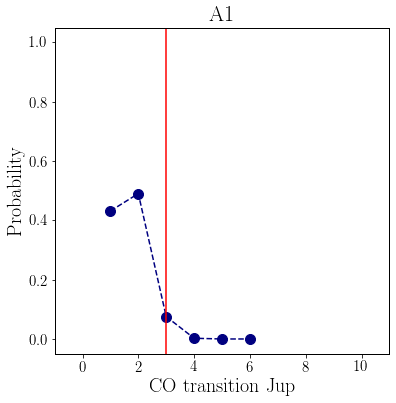

Tested transition A2 z = 1.551 J = CO(2-1)
transition CO(1-0) z = 0.275 probability 38.933
transition CO(2-1) z = 1.549 probability 54.382
transition CO(3-2) z = 2.823 probability 6.442
transition CO(4-3) z = 4.098 probability 0.243
transition CO(5-4) z = 5.372 probability 0.0
transition CO(6-5) z = 6.645 probability 0.0


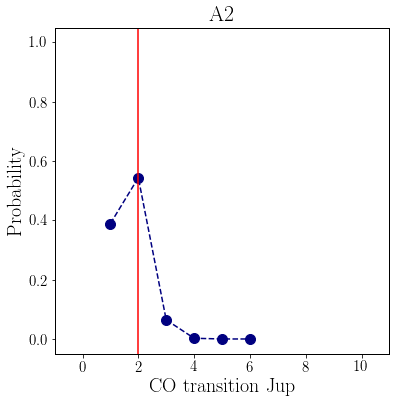

Tested transition A3 z = 1.088 J = CO(2-1)
transition CO(1-0) z = 0.044 probability 0.554
transition CO(2-1) z = 1.088 probability 55.313
transition CO(3-2) z = 2.131 probability 36.037
transition CO(4-3) z = 3.175 probability 7.689
transition CO(5-4) z = 4.218 probability 0.407
transition CO(6-5) z = 5.262 probability 0.0
transition CO(7-6) z = 6.305 probability 0.0


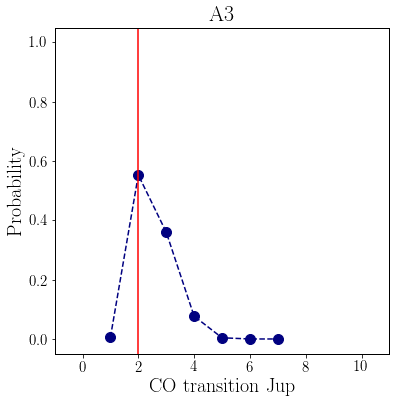

Tested transition A4 z = 2.37 J = CO(3-2)
transition CO(1-0) z = 0.124 probability 5.791
transition CO(2-1) z = 1.247 probability 69.939
transition CO(3-2) z = 2.371 probability 21.501
transition CO(4-3) z = 3.494 probability 2.71
transition CO(5-4) z = 4.617 probability 0.058
transition CO(6-5) z = 5.74 probability 0.0
transition CO(7-6) z = 6.863 probability 0.0


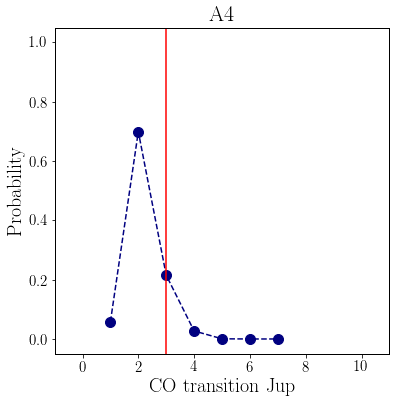

Tested transition A5 z = 2.543 J = CO(7-6)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.013 probability 0.736
transition CO(3-2) z = 0.519 probability 31.717
transition CO(4-3) z = 1.026 probability 45.547
transition CO(5-4) z = 1.532 probability 20.934
transition CO(6-5) z = 2.038 probability 1.06
transition CO(7-6) z = 2.544 probability 0.006
transition CO(8-7) z = 3.05 probability 0.0
transition CO(9-8) z = 3.556 probability 0.0
transition CO(10-9) z = 4.061 probability 0.0


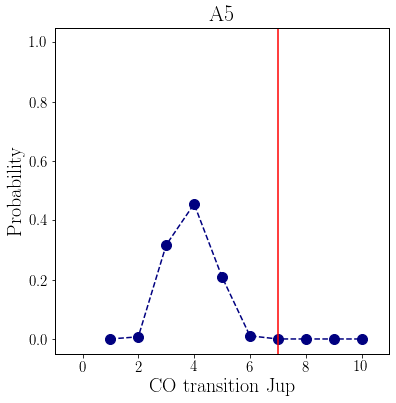

Tested transition A6 z = 2.543 J = CO(8-7)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = nan probability 0.0
transition CO(3-2) z = 0.33 probability 19.354
transition CO(4-3) z = 0.773 probability 53.438
transition CO(5-4) z = 1.216 probability 25.053
transition CO(6-5) z = 1.659 probability 2.15
transition CO(7-6) z = 2.102 probability 0.005
transition CO(8-7) z = 2.545 probability 0.0
transition CO(9-8) z = 2.988 probability 0.0
transition CO(10-9) z = 3.43 probability 0.0


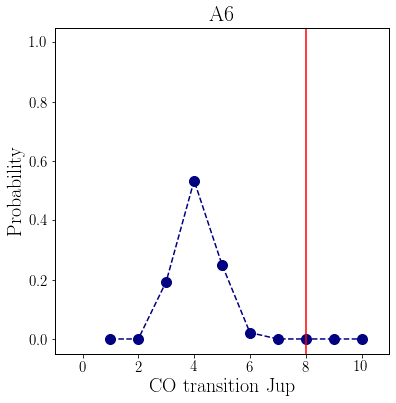

Tested transition A7 z = 0.54 J = CO(3-2)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.024 probability 0.594
transition CO(3-2) z = 0.536 probability 21.92
transition CO(4-3) z = 1.047 probability 33.989
transition CO(5-4) z = 1.559 probability 34.775
transition CO(6-5) z = 2.071 probability 8.627
transition CO(7-6) z = 2.582 probability 0.095
transition CO(8-7) z = 3.094 probability 0.0
transition CO(9-8) z = 3.605 probability 0.0
transition CO(10-9) z = 4.116 probability 0.0


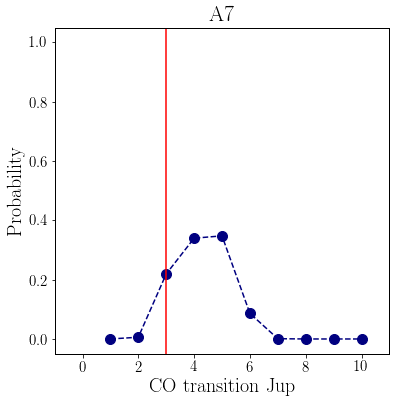

Tested transition A8 z = 2.543 J = CO(3-2)
transition CO(1-0) z = 0.181 probability 52.33
transition CO(2-1) z = 1.362 probability 42.162
transition CO(3-2) z = 2.543 probability 5.318
transition CO(4-3) z = 3.724 probability 0.19
transition CO(5-4) z = 4.904 probability 0.0
transition CO(6-5) z = 6.085 probability 0.0


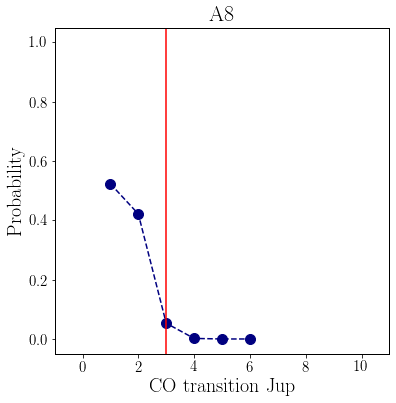

Tested transition A9 z = 1.317 J = CO(2-1)
transition CO(1-0) z = 0.159 probability 12.366
transition CO(2-1) z = 1.317 probability 68.927
transition CO(3-2) z = 2.475 probability 17.57
transition CO(4-3) z = 3.634 probability 1.124
transition CO(5-4) z = 4.792 probability 0.013
transition CO(6-5) z = 5.95 probability 0.0


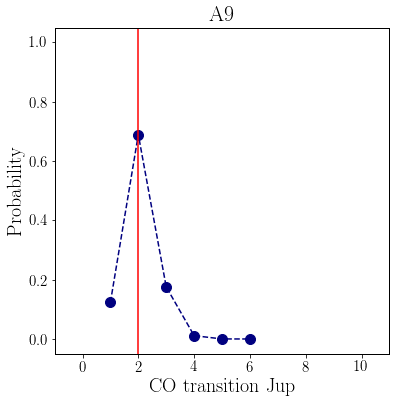

Tested transition A10 z = 2.453 J = CO(3-2)
transition CO(1-0) z = 0.151 probability 10.192
transition CO(2-1) z = 1.302 probability 74.389
transition CO(3-2) z = 2.453 probability 14.481
transition CO(4-3) z = 3.604 probability 0.926
transition CO(5-4) z = 4.754 probability 0.011
transition CO(6-5) z = 5.905 probability 0.0


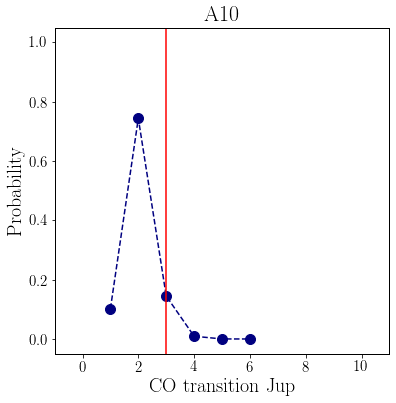

Tested transition A11 z = 1.414 J = CO(2-1)
transition CO(1-0) z = 0.207 probability 54.754
transition CO(2-1) z = 1.414 probability 39.499
transition CO(3-2) z = 2.621 probability 5.564
transition CO(4-3) z = 3.828 probability 0.183
transition CO(5-4) z = 5.034 probability 0.0
transition CO(6-5) z = 6.241 probability 0.0


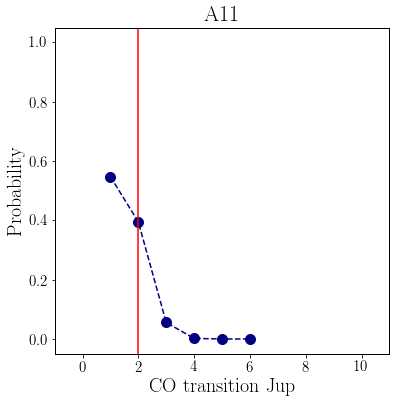

Tested transition A12 z = 1.55 J = CO(2-1)
transition CO(1-0) z = 0.275 probability 56.004
transition CO(2-1) z = 1.55 probability 40.655
transition CO(3-2) z = 2.825 probability 3.149
transition CO(4-3) z = 4.1 probability 0.192
transition CO(5-4) z = 5.374 probability 0.0
transition CO(6-5) z = 6.648 probability 0.0


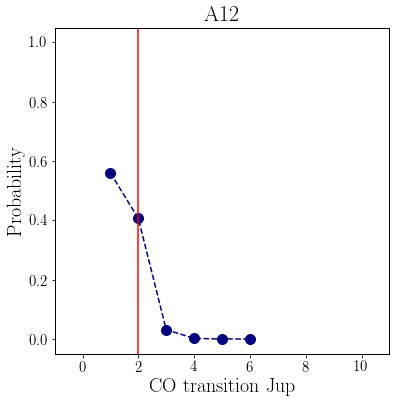

Tested transition A13 z = 1.095 J = CO(2-1)
transition CO(1-0) z = 0.048 probability 1.133
transition CO(2-1) z = 1.095 probability 72.047
transition CO(3-2) z = 2.142 probability 24.589
transition CO(4-3) z = 3.19 probability 2.207
transition CO(5-4) z = 4.237 probability 0.024
transition CO(6-5) z = 5.284 probability 0.0
transition CO(7-6) z = 6.33 probability 0.0


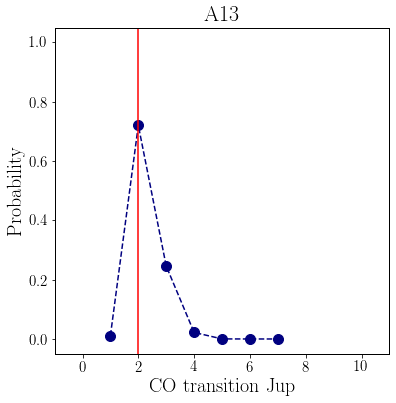

Tested transition A14 z = 2.697 J = CO(3-2)
transition CO(1-0) z = 0.232 probability 45.87
transition CO(2-1) z = 1.465 probability 47.859
transition CO(3-2) z = 2.697 probability 6.125
transition CO(4-3) z = 3.929 probability 0.147
transition CO(5-4) z = 5.161 probability 0.0
transition CO(6-5) z = 6.393 probability 0.0


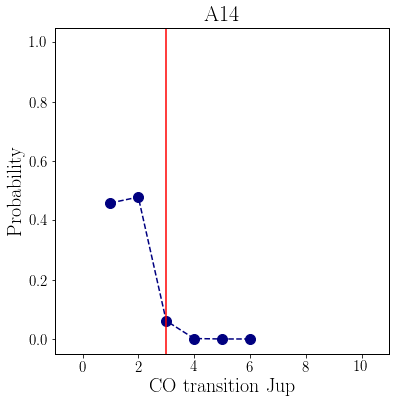

Tested transition A15 z = 1.382 J = CO(2-1)
transition CO(1-0) z = 0.191 probability 10.719
transition CO(2-1) z = 1.382 probability 60.126
transition CO(3-2) z = 2.573 probability 26.498
transition CO(4-3) z = 3.764 probability 2.59
transition CO(5-4) z = 4.954 probability 0.068
transition CO(6-5) z = 6.145 probability 0.0


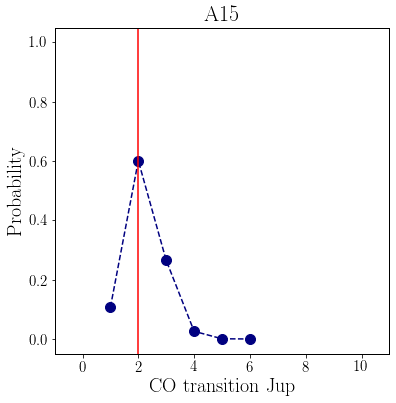

Tested transition A16 z = 2.698 J = CO(3-2)
transition CO(1-0) z = 0.233 probability 28.616
transition CO(2-1) z = 1.465 probability 60.982
transition CO(3-2) z = 2.698 probability 10.035
transition CO(4-3) z = 3.93 probability 0.368
transition CO(5-4) z = 5.163 probability 0.0
transition CO(6-5) z = 6.395 probability 0.0


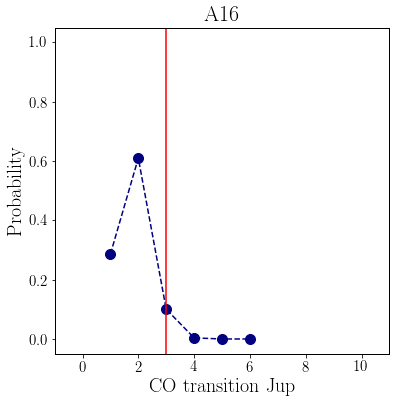

Tested transition A17 z = 1.037 J = CO(2-1)
transition CO(1-0) z = 0.019 probability 1.904
transition CO(2-1) z = 1.037 probability 72.869
transition CO(3-2) z = 2.055 probability 23.415
transition CO(4-3) z = 3.074 probability 1.698
transition CO(5-4) z = 4.092 probability 0.114
transition CO(6-5) z = 5.11 probability 0.0
transition CO(7-6) z = 6.127 probability 0.0


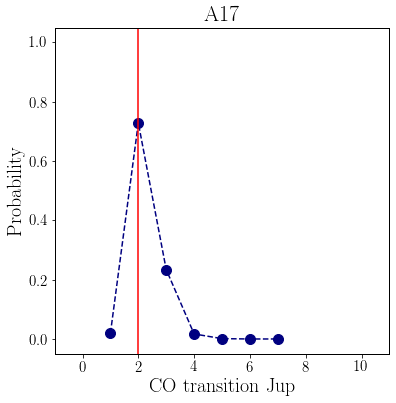

Tested transition A18 z = 1.096 J = CO(2-1)
transition CO(1-0) z = 0.048 probability 0.554
transition CO(2-1) z = 1.096 probability 55.313
transition CO(3-2) z = 2.144 probability 36.037
transition CO(4-3) z = 3.192 probability 7.689
transition CO(5-4) z = 4.239 probability 0.407
transition CO(6-5) z = 5.287 probability 0.0
transition CO(7-6) z = 6.334 probability 0.0


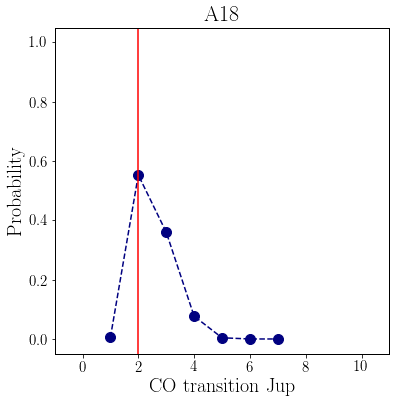

Tested transition A19 z = 2.574 J = CO(3-2)
transition CO(1-0) z = 0.191 probability 9.242
transition CO(2-1) z = 1.383 probability 57.716
transition CO(3-2) z = 2.574 probability 29.5
transition CO(4-3) z = 3.765 probability 3.426
transition CO(5-4) z = 4.956 probability 0.116
transition CO(6-5) z = 6.147 probability 0.0


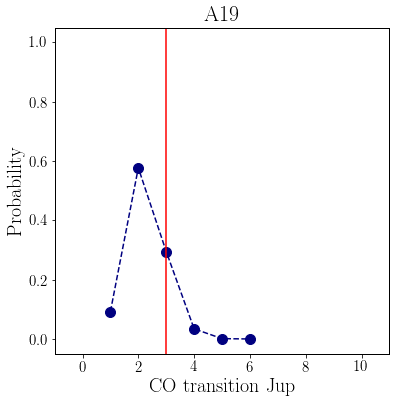

Tested transition A20 z = 3.601 J = CO(4-3)
transition CO(1-0) z = 0.15 probability 3.332
transition CO(2-1) z = 1.301 probability 61.23
transition CO(3-2) z = 2.451 probability 30.333
transition CO(4-3) z = 3.601 probability 4.906
transition CO(5-4) z = 4.751 probability 0.199
transition CO(6-5) z = 5.901 probability 0.0


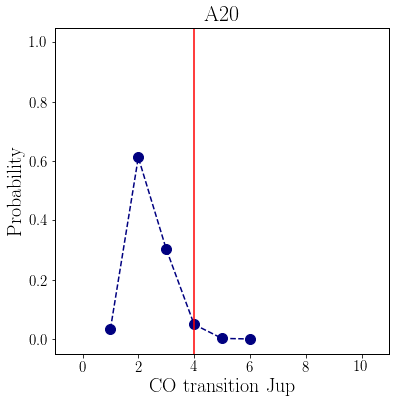

Tested transition A21 z = 1.098 J = CO(2-1)
transition CO(1-0) z = 0.049 probability 0.904
transition CO(2-1) z = 1.098 probability 67.47
transition CO(3-2) z = 2.147 probability 28.157
transition CO(4-3) z = 3.196 probability 3.396
transition CO(5-4) z = 4.244 probability 0.073
transition CO(6-5) z = 5.293 probability 0.0
transition CO(7-6) z = 6.341 probability 0.0


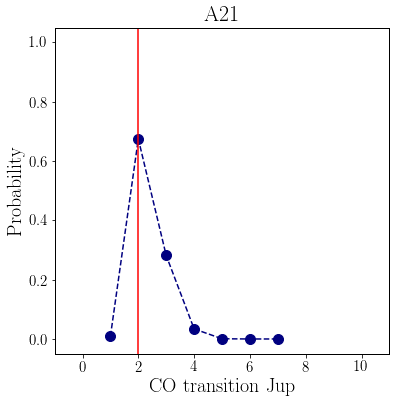

Tested transition A22 z = 1.096 J = CO(2-1)
transition CO(1-0) z = 0.048 probability 0.668
transition CO(2-1) z = 1.096 probability 60.054
transition CO(3-2) z = 2.144 probability 32.95
transition CO(4-3) z = 3.192 probability 6.027
transition CO(5-4) z = 4.239 probability 0.301
transition CO(6-5) z = 5.287 probability 0.0
transition CO(7-6) z = 6.334 probability 0.0


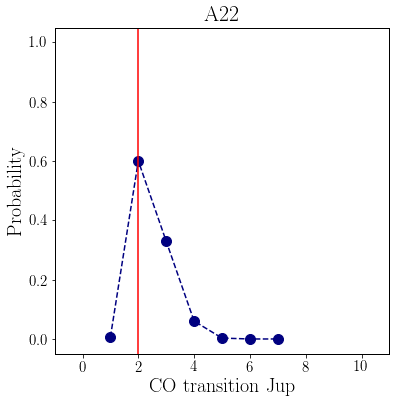

Tested transition A23 z = 1.294 J = CO(2-1)
transition CO(1-0) z = 0.147 probability 2.749
transition CO(2-1) z = 1.294 probability 54.335
transition CO(3-2) z = 2.441 probability 34.184
transition CO(4-3) z = 3.588 probability 8.159
transition CO(5-4) z = 4.734 probability 0.568
transition CO(6-5) z = 5.881 probability 0.004


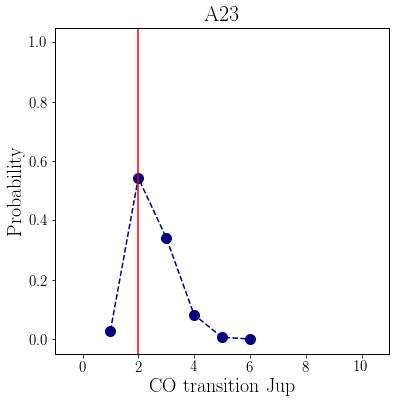

Tested transition P1 z = 3.408 J = CO(4-3)
transition CO(1-0) z = 0.102 probability 11.938
transition CO(2-1) z = 1.204 probability 71.613
transition CO(3-2) z = 2.306 probability 15.292
transition CO(4-3) z = 3.408 probability 1.138
transition CO(5-4) z = 4.51 probability 0.019
transition CO(6-5) z = 5.612 probability 0.0
transition CO(7-6) z = 6.713 probability 0.0


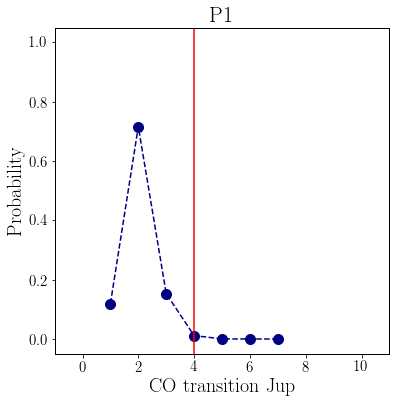

Tested transition P2 z = 0.696 J = CO(2-1)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.696 probability 51.158
transition CO(3-2) z = 1.544 probability 40.895
transition CO(4-3) z = 2.393 probability 7.593
transition CO(5-4) z = 3.24 probability 0.353
transition CO(6-5) z = 4.088 probability 0.0
transition CO(7-6) z = 4.936 probability 0.0
transition CO(8-7) z = 5.783 probability 0.0
transition CO(9-8) z = 6.63 probability 0.0


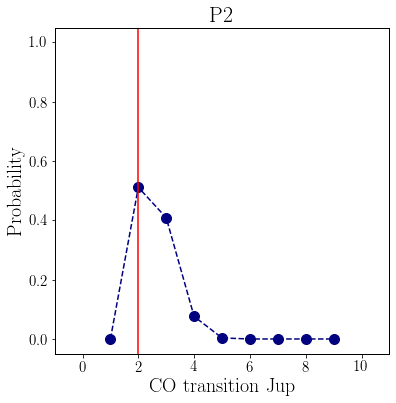

Tested transition P3 z = 0.623 J = CO(2-1)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.623 probability 35.609
transition CO(3-2) z = 1.435 probability 44.537
transition CO(4-3) z = 2.246 probability 17.665
transition CO(5-4) z = 3.057 probability 2.159
transition CO(6-5) z = 3.868 probability 0.03
transition CO(7-6) z = 4.679 probability 0.0
transition CO(8-7) z = 5.49 probability 0.0
transition CO(9-8) z = 6.3 probability 0.0


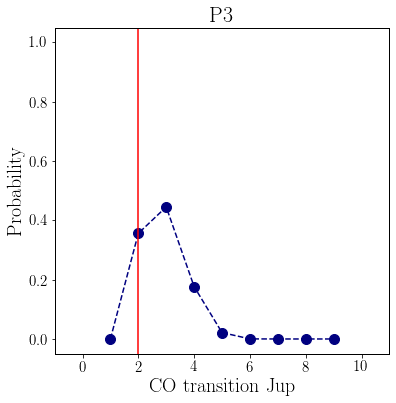

Tested transition P4 z = 1.142 J = CO(2-1)
transition CO(1-0) z = 0.071 probability 1.039
transition CO(2-1) z = 1.142 probability 69.652
transition CO(3-2) z = 2.213 probability 26.159
transition CO(4-3) z = 3.284 probability 3.09
transition CO(5-4) z = 4.354 probability 0.061
transition CO(6-5) z = 5.424 probability 0.0
transition CO(7-6) z = 6.495 probability 0.0


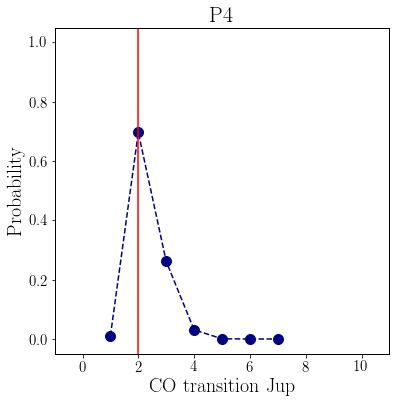

Tested transition P5 z = 1.254 J = CO(3-2)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.503 probability 25.176
transition CO(3-2) z = 1.254 probability 46.218
transition CO(4-3) z = 2.005 probability 24.893
transition CO(5-4) z = 2.756 probability 3.658
transition CO(6-5) z = 3.507 probability 0.055
transition CO(7-6) z = 4.258 probability 0.0
transition CO(8-7) z = 5.008 probability 0.0
transition CO(9-8) z = 5.759 probability 0.0
transition CO(10-9) z = 6.509 probability 0.0


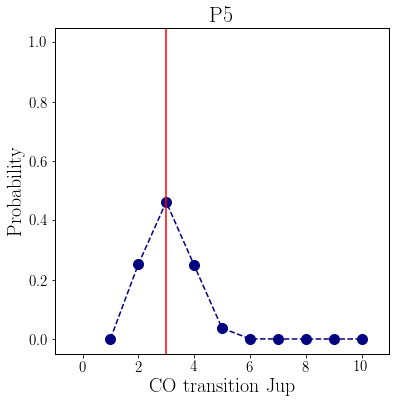

Tested transition P6 z = 1.25 J = CO(3-2)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.5 probability 29.384
transition CO(3-2) z = 1.25 probability 46.392
transition CO(4-3) z = 2.0 probability 21.833
transition CO(5-4) z = 2.75 probability 2.367
transition CO(6-5) z = 3.5 probability 0.023
transition CO(7-6) z = 4.249 probability 0.0
transition CO(8-7) z = 4.998 probability 0.0
transition CO(9-8) z = 5.747 probability 0.0
transition CO(10-9) z = 6.496 probability 0.0


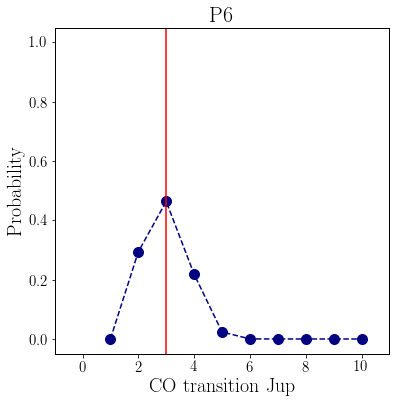

Tested transition P7 z = 0.692 J = CO(2-1)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.692 probability 56.387
transition CO(3-2) z = 1.538 probability 36.758
transition CO(4-3) z = 2.384 probability 6.524
transition CO(5-4) z = 3.23 probability 0.33
transition CO(6-5) z = 4.075 probability 0.0
transition CO(7-6) z = 4.92 probability 0.0
transition CO(8-7) z = 5.766 probability 0.0
transition CO(9-8) z = 6.61 probability 0.0


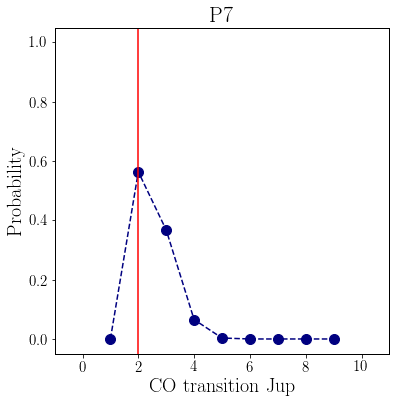

Tested transition P8 z = 1.101 J = CO(2-1)
transition CO(1-0) z = 0.051 probability 0.904
transition CO(2-1) z = 1.101 probability 67.47
transition CO(3-2) z = 2.152 probability 28.157
transition CO(4-3) z = 3.202 probability 3.396
transition CO(5-4) z = 4.252 probability 0.073
transition CO(6-5) z = 5.302 probability 0.0
transition CO(7-6) z = 6.352 probability 0.0


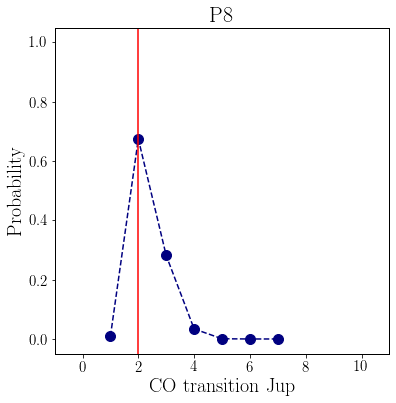

Tested transition P9 z = 2.305 J = CO(3-2)
transition CO(1-0) z = 0.102 probability 58.368
transition CO(2-1) z = 1.203 probability 37.593
transition CO(3-2) z = 2.305 probability 3.833
transition CO(4-3) z = 3.406 probability 0.206
transition CO(5-4) z = 4.507 probability 0.0
transition CO(6-5) z = 5.608 probability 0.0
transition CO(7-6) z = 6.709 probability 0.0


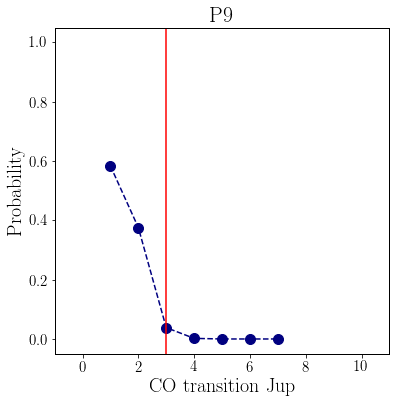

Tested transition P10 z = 3.934 J = CO(6-5)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.645 probability 51.66
transition CO(3-2) z = 1.468 probability 40.157
transition CO(4-3) z = 2.29 probability 7.853
transition CO(5-4) z = 3.112 probability 0.33
transition CO(6-5) z = 3.935 probability 0.0
transition CO(7-6) z = 4.757 probability 0.0
transition CO(8-7) z = 5.578 probability 0.0
transition CO(9-8) z = 6.4 probability 0.0


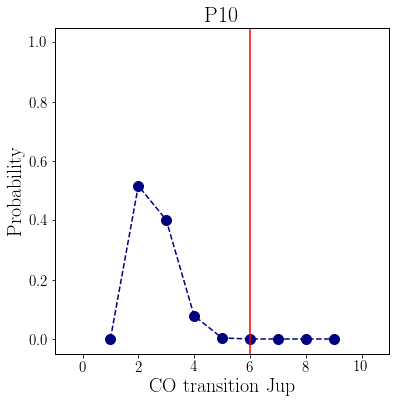

Tested transition P11 z = 0.672 J = CO(2-1)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.677 probability 55.256
transition CO(3-2) z = 1.516 probability 36.021
transition CO(4-3) z = 2.355 probability 8.4
transition CO(5-4) z = 3.193 probability 0.323
transition CO(6-5) z = 4.031 probability 0.0
transition CO(7-6) z = 4.869 probability 0.0
transition CO(8-7) z = 5.707 probability 0.0
transition CO(9-8) z = 6.545 probability 0.0


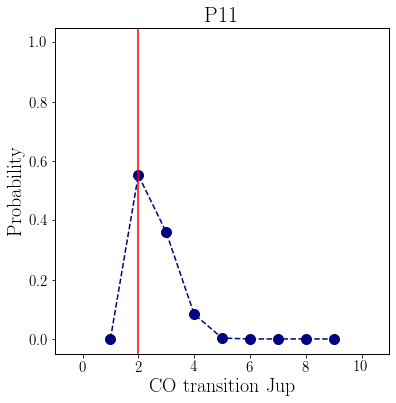

Tested transition P12 z = 0.651 J = CO(2-1)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.651 probability 46.425
transition CO(3-2) z = 1.477 probability 42.716
transition CO(4-3) z = 2.302 probability 10.324
transition CO(5-4) z = 3.128 probability 0.535
transition CO(6-5) z = 3.953 probability 0.0
transition CO(7-6) z = 4.778 probability 0.0
transition CO(8-7) z = 5.603 probability 0.0
transition CO(9-8) z = 6.427 probability 0.0


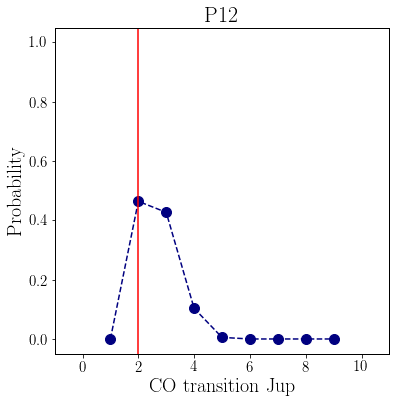

Tested transition P13 z = 1.616 J = CO(3-2)
transition CO(1-0) z = nan probability 0.0
transition CO(2-1) z = 0.745 probability 46.907
transition CO(3-2) z = 1.617 probability 40.148
transition CO(4-3) z = 2.489 probability 12.074
transition CO(5-4) z = 3.361 probability 0.861
transition CO(6-5) z = 4.233 probability 0.009
transition CO(7-6) z = 5.104 probability 0.0
transition CO(8-7) z = 5.976 probability 0.0
transition CO(9-8) z = 6.847 probability 0.0


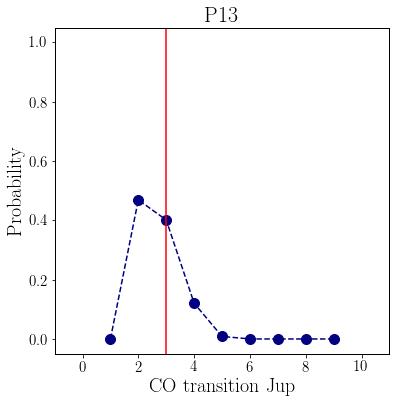

In [54]:
#f=open("Transition_probability_test.txt", 'w')
#f.write("#tested trans, z (Jup, z, Prob)\n")

# read in the sample 
sample = np.loadtxt("test_COtrans.txt", usecols=(1,2,3,4,5,6,7), delimiter=',') #f0, flux [Jykms], flux err,fwhm, fwhm err, z , trans
name =np.loadtxt("test_COtrans.txt", usecols=(0,) ,delimiter=',', dtype='str')
S = np.size(sample.T[0])

for s in range(S):

    flux = np.log10(sample[s][1]*1e3) #mJy
    freq0 = sample[s][0]
    
    print("Tested transition "+name[s]+" z = "+ str(sample[s][5]) + " J = " + CO_labels[int(sample[s][6]-1)])
    Nprob,COprob,Z=[],[],[]
    M=0
    #f.write(str(sample[s][5])+" "+CO_labels[int(sample[s][6] -1)]+" ")
    for j in range(np.size(CO_labels)):

        z = CO_J[j]/freq0 -1.
  
        # read in the histogram 
        H = np.load(CO_labels[j]+"_new_hist.npy")
        M += np.sum(H)


        if z > 0 and z < 10:
            #print(z)
            #check which bin you are in for k in range(nbins-1):
            for k in range(nbins-1):
                x1,x2 = xedges[k],xedges[k+1]
                if x1<=z <=x2: 
                    x = k

                    for l in range(nbins-1):
                        y1,y2 = yedges[l],yedges[l+1]
                        if y1<=flux <=y2: 
                            #print y1,y2,flux,l+1
                            y = l
                            #plt.plot(x,y,'or',ms=10)
                            #plt.plot(y,x,'ob',ms=10)
                            Nprob.append(H[y][x])
                            COprob.append(j+1) #Jup
                            Z.append(z)
                            #print H.T[y][x], j 
        elif z < 0:
            COprob.append(j+1)
            Z.append(str(0))
            Nprob.append(str(0))

    Nprob = np.array(Nprob, dtype='float')
    N = np.sum(Nprob)
    #print(Nprob, M)
    Mnew=np.sum(Nprob/M)
    Nprob_all = Nprob/M
    for i in range(np.size(COprob)):
        j = COprob[i] - 1 #Jlow
        z = CO_J[j]/freq0 -1.
        prob = Nprob[i]/M/Mnew
        if z < 0 : z= np.nan
        print("transition", CO_labels[j], "z =", np.round(z,3), "probability", np.round(prob*100,3))
        #f.write("(" + str(j+1) +" "+ str(np.round(prob*100,3))+ ")" )
    #f.write("\n")

    fig=plt.figure(1, figsize=(6,6))
    plt.plot(COprob,Nprob/M/Mnew, "o--", c='navy',ms=10)
    plt.axvline(sample.T[6][s],c="r")
    plt.title(name[s], fontsize=22)
    plt.xlabel("CO transition Jup")
    plt.ylabel("Probability")
    plt.ylim([-0.05, 1.05])
    plt.xlim([-1,11])
    plt.show()

#f.close()




Check all predictions vs classification and mark if - same, or 2nd best -  save to <i> test_predictions_shark.txt</i>

## Shark predictions fro other surveys statistics
Appendix figure

In [55]:
# pred = np.loadtxt("test_predictions_shark.txt",usecols=(1,2,3,4))
# cat = np.loadtxt("test_predictions_shark.txt",usecols=(5,6), dtype='str')


# fig=plt.figure(1,figsize=(12,8))
# array = pred.T[2][0:8]
# indexes = np.where(cat.T[1][0:8] == 'Y')[0]
# retrieved =  array[indexes]
# indexes2 = np.where(cat.T[1][0:8] == 'A')[0]
# almost = array[indexes2]
# all_J = pred.T[2][0:8]
# plt.subplot(221)
# plt.hist(all_J, bins=[0,1,2,3,4,5,6,7,8,9], align='left',color='navy',label='observed')
# plt.hist(retrieved,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='red', linewidth=2, hatch='/', label='retrieved with\n max probability')
# plt.hist(almost,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='yellow', linewidth=2, hatch='\ ', label='missed by 1 J')
# plt.text(6,4, "COLDz", fontsize=18)
# plt.xlim(0,9)

# plt.ylabel("No. of sources", fontsize=18)
# #plt.legend(fontsize=18)
# array = pred.T[2][8:32]
# indexes = np.where(cat.T[1][8:32] == 'Y')[0]
# retrieved =  array[indexes]
# indexes2 = np.where(cat.T[1][8:32] == 'A')[0]
# almost = array[indexes2]


# all_J = pred.T[2][8:32]
# plt.subplot(222)
# plt.hist(all_J, bins=[0,1,2,3,4,5,6,7,8,9], align='left',color='navy',label='observed')
# plt.hist(retrieved,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='red', linewidth=2, hatch='/', label='retrieved with\n max probability')
# plt.hist(almost,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='yellow', linewidth=2, hatch=' \ ', label='missed by 1 J')
# plt.text(6,10, "ASPECS", fontsize=18 )
# plt.xlim(0,9)

# array = pred.T[2][32:]
# indexes = np.where(cat.T[1][32:] == 'Y')[0]
# retrieved =  array[indexes]
# indexes2 = np.where(cat.T[1][32:] == 'A')[0]
# almost = array[indexes2]
# all_J = pred.T[2][32:]
# plt.subplot(223)
# plt.hist(all_J, bins=[0,1,2,3,4,5,6,7,8,9], align='left',color='navy',label='observed')
# plt.hist(retrieved,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='red', linewidth=2, hatch='/', label='retrieved with\n max probability')
# plt.hist(almost,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='yellow', linewidth=2, hatch='\ ', label='missed by 1 J')
# plt.text(6,6, "PHIBSS2", fontsize=18)
# plt.xlim(0,9)
# plt.xlabel("CO Jup", fontsize=18)
# plt.ylabel("No. of sources", fontsize=18)
# plt.subplot(224)
# #plt.legend(fontsize=18)
# array = pred.T[2]
# indexes = np.where(cat.T[1] == 'Y')[0]
# retrieved =  array[indexes]
# indexes2 = np.where(cat.T[1] == 'A')[0]
# almost = array[indexes2]
# all_J = pred.T[2]

# plt.hist(all_J, bins=[0,1,2,3,4,5,6,7,8,9], align='left',color='navy',label='observed')
# plt.hist(retrieved,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='red', linewidth=2, hatch='/', label='retrieved with\n max probability')
# plt.hist(almost,histtype='step', align='left', bins=[0,1,2,3,4,5,6,7,8,9], color='yellow', linewidth=2, hatch='\ ', label='missed by 1 J')
# plt.text(6,8, "all sources", fontsize=18)
# plt.xlim(0,9)
# plt.xlabel("CO Jup", fontsize=18)
# plt.legend(fontsize=18)
# fig.savefig("shark_test.pdf")


In [56]:
# fig2=plt.figure(2)
# plt.plot(pred.T[2], pred.T[0], 'o', c='navy')
# plt.plot(range(0,9), range(0,9), '-r')
# plt.xlabel("Actual Jup", fontsize=18)
# plt.ylabel("Predicted max prob. Jup", fontsize=18)

# plt.xlim([0,9])
# plt.ylim([0,9])
# fig2.savefig("shark_bad_pred.pdf")
# plt.show()

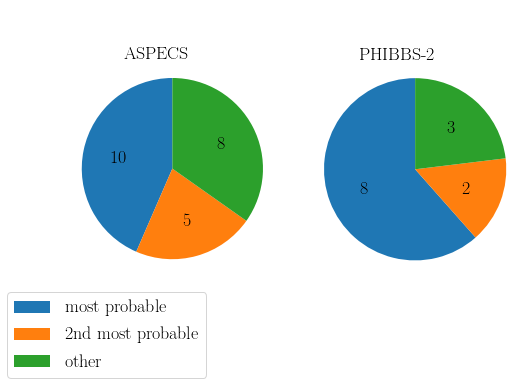

In [57]:
#### Appendix plot

mpl.rc ('xtick',labelsize=15)
mpl.rc ('ytick',labelsize=15)

plt.rc('font', family='serif', size=18 )

labels = 'most probable', '2nd most probable', 'other'
sizes_as =np.array( [10, 5, 8])
sizes_ph = np.array([8,2,3])
def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return int(a)
fig1, ax1 = plt.subplots(1,2,figsize=(8,6))
sizes = sizes_as

patches, texts, o=ax1[0].pie(sizes_as, autopct=absolute_value, startangle=90)
ax1[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sizes = sizes_ph
ax1[0].annotate("ASPECS", (-0.53, 1.21))
ax1[1].annotate("PHIBBS-2", (-0.62, 1.21))
ax1[1].pie(sizes, autopct=absolute_value, startangle=90)
ax1[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1[0].legend(patches, labels, bbox_to_anchor=(0,0), loc="lower left", bbox_transform=plt.gcf().transFigure)
fig1.savefig("test_pie.png", bbox_inches="tight")
plt.show()

## Figures - comparison of the detections with other surveys detections

In [58]:

color_almacal='#d11141'
color_aspecs='#00aedb'
color_coldz='#ffc425'
color_phibss='g'
observed = np.loadtxt("test_COtrans.txt", usecols=(2,3,4,5,1,6,7), delimiter=',') # flux, err,vel, err, f0


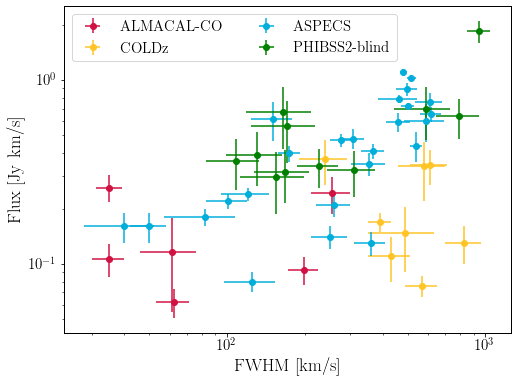

In [59]:
fig = plt.figure(1, figsize=(8,6))
plt.errorbar(almacal.T[0], almacal.T[2]/1.e3, xerr=almacal.T[1], yerr=almacal.T[3]/1.e3, fmt='o', label="ALMACAL-CO", color=color_almacal)
#plt.errorbar(almacal.T[0][8:], almacal.T[2][8:]/1.e3, xerr=almacal.T[1][8:], yerr=almacal.T[3][8:]/1.e3, fmt='ro', mec='r', mfc='none', label="ALMACAL-CO pilot (maybes)")

plt.errorbar(observed.T[2][0:8], observed.T[0][0:8], xerr=observed.T[3][0:8], yerr=observed.T[1][0:8], fmt='o', label='COLDz', color=color_coldz)
plt.errorbar(observed.T[2][8:33], observed.T[0][8:33], xerr=observed.T[3][8:33], yerr=observed.T[1][8:33], fmt='o',c=color_aspecs, label='ASPECS')
plt.errorbar(observed.T[2][33:], observed.T[0][33:], xerr=observed.T[3][33:], yerr=observed.T[1][33:], fmt='go', label='PHIBSS2-blind')

plt.legend(fontsize=15, ncol=2)
plt.xlabel("FWHM [km/s]", fontsize=18)
#plt.ylim([0, 2.6])
#plt.xlim([-10,1000])
plt.xscale("log")
plt.yscale("log")

plt.ylabel("Flux [Jy km/s]", fontsize=18)
fig.savefig("Flux-fwhm.png")

# Lowest possible J

In [60]:
#find lowest possible J
lowestJ = Table(names=("z", "Jmin","f_obs", "Flux", "Flux_err"))

for f0, I, Ierr in zip(almacal.T[4], almacal.T[2],almacal.T[3]):
    #print(f0)
    for co in CO_J:
        z = co/f0 -1
        #print(z)
        if z > 0:
            break

            
    jmin=np.where(CO_J ==co)[0][0] +1
    #print(z, jmin)
    lowestJ.add_row( (round(z,4),jmin, f0, I, Ierr))

print(lowestJ) #col1 - redshift, col2 - lowest-J, col3-flux, col4 - flux err
M=np.size(lowestJ['z'])

  z    Jmin  f_obs   Flux Flux_err
------ ---- ------- ----- --------
0.3231  4.0 348.463 107.0     22.0
0.0036  3.0  344.57 260.0     43.0
0.4812  3.0 233.453 116.0     61.0
0.6962  2.0 135.913  93.0     16.0
0.1856  1.0  97.228 243.0     55.0
0.1338  1.0  101.67  62.0     11.0


### choose the SLED
The predicted lowest possible Js are in an range 1-4. We can use the Weiss +05 SLED of the center of M82

In [61]:
#From carilli & Walter +13
# smg_sled = np.array([1,1/0.85, 1./0.66, 1./0.46 ])
# qso_sled = np.array([1,1/0.99, 1./0.97, 1./0.87 ])
# csg_sled=np.array([1, 1/.97, 1/.56, 1/.2])
# mw_sled=np.array([1, 1/.5, 1./0.27, 1/0.17])
# m82_sled=np.array([1., 1/0.98, 1./0.93, 1/0.85])
# plt.plot(range(1,5,1), smg_sled, label='smg')
# plt.plot(range(1,5,1), qso_sled, label='qso')
# plt.plot(range(1,5,1), csg_sled, label='csg')
# plt.plot(range(1,5,1), mw_sled, label='MW')
# plt.plot(range(1,5,1), m82_sled, label='M82')
# plt.legend()



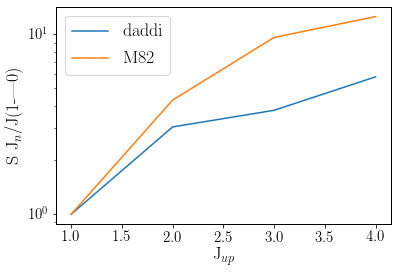

In [62]:

#daddi sled
det = np.array([0.193,0.59,0.73,1.12])
det_err = np.array([0.018, 0.04,0.09,0.14])
det_sled_err = np.array([0]*4)

daddi_sled = det/det[0]
plt.plot(range(1,5,1), daddi_sled, label='daddi')
plt.xlabel("J$_{up}$")
plt.ylabel("S J$_{n}$/J(1-|0)")
m82_sled=np.array([1,4.31,9.61,12.55])

plt.plot(range(1,5,1), m82_sled, label='M82')
plt.legend()
plt.yscale('log')

Text(0, 0.5, 'S J$_{n}$/J(1-|0)')

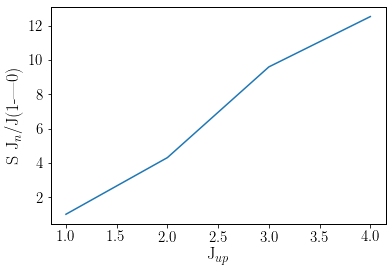

In [63]:
#center of M82 SLED from Weiss+05
m82_sled=np.array([1,4.31,9.61,12.55])
plt.plot(range(1,5,1), m82_sled, label='M82')
plt.xlabel("J$_{up}$")
plt.ylabel("S J$_{n}$/J(1-|0)")

In [64]:
c1=Column(np.zeros(M), name='LCO_10_prime')
c2 = Column(np.zeros(M), name='M_H2')
lowestJ.add_column(c1)
lowestJ.add_column(c2)
c3=Column([0.17,0.19, 0.19, 0.64, 0.55, 0.18],name='completeness')
lowestJ.add_column(c3)
c4=Column([0.58,0.43, 0.38, 0.74, 1.0, 1.0], name='reliability')
lowestJ.add_column(c4)
print(lowestJ)

  z    Jmin  f_obs   Flux Flux_err LCO_10_prime M_H2 completeness reliability
------ ---- ------- ----- -------- ------------ ---- ------------ -----------
0.3231  4.0 348.463 107.0     22.0          0.0  0.0         0.17        0.58
0.0036  3.0  344.57 260.0     43.0          0.0  0.0         0.19        0.43
0.4812  3.0 233.453 116.0     61.0          0.0  0.0         0.19        0.38
0.6962  2.0 135.913  93.0     16.0          0.0  0.0         0.64        0.74
0.1856  1.0  97.228 243.0     55.0          0.0  0.0         0.55         1.0
0.1338  1.0  101.67  62.0     11.0          0.0  0.0         0.18         1.0


In [65]:
M = np.size(lowestJ['z'])
alpha=4.3

#apply SLED to get L'CO(1-0) and MH2 for each detection)
for m in range(M):
    j=int(lowestJ['Jmin'][m])-1
    #print(j, m82_sled[j])
    I10 = lowestJ['Flux'][m]/daddi_sled[j]
    I10_m82 = lowestJ['Flux'][m]/m82_sled[j]
    print(lowestJ['Flux'][m],I10)

    
    #convert to L'
    l10=CO10_Lum_prime(lowestJ['z'][m], I10/1.e3)

    mh2=Mmol(l10,alpha=alpha)
    lowestJ['LCO_10_prime'][m]=round(np.log10(l10),3)
    lowestJ['M_H2'][m]=round(np.log10(mh2),3)
    #print(np.log10(l10), np.log10(mh2))
print(lowestJ)    

107.0 18.438392857142855
260.0 68.73972602739727
116.0 30.668493150684935
93.0 30.422033898305088
243.0 243.0
62.0 62.0
  z    Jmin  f_obs   Flux Flux_err LCO_10_prime  M_H2 completeness reliability
------ ---- ------- ----- -------- ------------ ----- ------------ -----------
0.3231  4.0 348.463 107.0     22.0        8.017  8.65         0.17        0.58
0.0036  3.0  344.57 260.0     43.0        4.632 5.265         0.19        0.43
0.4812  3.0 233.453 116.0     61.0        8.596 9.229         0.19        0.38
0.6962  2.0 135.913  93.0     16.0        8.921 9.554         0.64        0.74
0.1856  1.0  97.228 243.0     55.0        8.639 9.272         0.55         1.0
0.1338  1.0  101.67  62.0     11.0        7.753 8.387         0.18         1.0


In [66]:
V1, V2 = 1452.36, 7243.4
# lum func
#7
lum7 = 0.58/0.17 +0.31/0.1 + 1.0/0.18
lum8 = 0.38/0.19 + 0.74/0.64 + 1.0/0.18

Lum7_sum = 1./V1 * lum7
Lum8_sum = 1./V1 * lum8
print(Lum7_sum, Lum8_sum)

errors=np.zeros(6)
for t in range(3):
    pl=Poiss_lower_limit(lum8,t+1)
    pu=Poiss_upper_limit(lum8,t+1)
    errors[t],errors[t+3]=pl/V1,pu/V1
print(errors)
errors=np.zeros(6)
for t in range(3):
    pl=Poiss_lower_limit(lum7,t+1)
    pu=Poiss_upper_limit(lum7,t+1)
    errors[t],errors[t+3]=pl/V1,pu/V1
print(errors)

0.008308766601557402 0.00599837888371723
[0.00396612 0.00262239 0.00173768 0.00883265 0.01166691 0.0149602 ]
[0.00591693 0.00421363 0.00296935 0.01148627 0.01466377 0.01830029]


In [67]:
#7/8 detections will go to the first box 0-0.5 ??
#0-0.5, 0.5-1. 

alpha=4.3


## calculate omega H2

# redshift bins
Z = [0., 0.5, 1.]
M = np.size(lowestJ['z'])
sum1,sum2=0,0
for i in range(M):
    z=lowestJ['z'][i]
    if z >= Z[0] and z < Z[1]:
        sum1 +=10**lowestJ['LCO_10_prime'][i]/lowestJ['completeness'][i]*lowestJ['reliability'][i]
    else:
        sum2 +=10**lowestJ['LCO_10_prime'][i]/lowestJ['completeness'][i]*lowestJ['reliability'][i]

OH1 = np.log10(alpha /V1 * sum1)
OH2 = np.log10(alpha/V2 * sum2)
print(OH1, OH2)
low_z = np.array([8.21,8.406,8.853,9.272,8.387])
low_z_std = np.std(10**np.array([8.21,8.406,8.853,9.272,8.387]))*alpha/V1
print(np.log10(low_z),np.log10(low_z_std))
ncounts= 5
print(np.log10(5*alpha/V1*10**np.min(low_z)),np.log10(5*alpha/V1*10**np.max(low_z)))



6.8236201286678 5.757577732556155
[0.91434316 0.92458939 0.94709046 0.96717342 0.92360664] 6.278131708405568
6.380364180579802 7.442364180579801


# H2 from the ALMACAL detections

Returns probability of the observed line to be a certain CO transition.
Probabilities are based on the population of galaxies generated from Shark SAMS (Lagos et al 2018)
for a galaxies with faintest CO transition no lower then xxx mJy km/s



In [68]:
Volume = 231577 #Mpc3 ALMACAL deep volume

#### Create the table of possible transitions 
transition_prob= np.zeros((np.size(CO_labels), 4))
#col 0 - J, col1 - z col2 - flux col3 - probability for the transition

xedges=np.load('xbins_new.npy')
yedges=np.load('ybins_new.npy')
            

##load transition bins
nbins=np.size(xedges)

In [69]:
#read in the parameters of the detections
#J "CO(1-0) - 0 (10) ","CO(2-1) - 1 (11) ","CO(3-2) - 2 (12)","CO(4-3) - 3 (13) ","CO(5-4) -4","CO(6-5) -5 ","CO(7-6) -6", "CO(8-7) -7", "CO(9-8) -8", "CO(10-9) -9"
# in Shark file 10, 11, 12 
cubes, names= np.loadtxt('candidates_list.txt', usecols=(1,2),dtype='str',comments='#', unpack=True)
SN,Width,f0, int_flux, flux_err, fid = np.loadtxt('candidates_list.txt', usecols=(6,8,10,12,13,15),dtype='float', unpack=True)

Nprob,COprob,Z=[],[],[]
M=0
S = np.size(cubes)
Nproberr= 100 #
transitions_array = np.zeros((S,Nproberr,10,5)) #[n_det][fluxerr][Jtrans][prob, L',z,L'(1-0),completnes]
alpha = 4.3
#relaibility coeficient



In [70]:
## load completness

compeltnesH =np.load("completnes.npy")
completnes_x = np.load("compeltnes_xedges.npy") #SN
completnes_y = np.load("compeltnes_yedges.npy") #width km/s
w_error = np.load("w_error.npy")
sn_error = np.load("sn_error.npy")

In [71]:
#Create the probability function for each candidate (including MC over the flux errors)"

for s in range(S): #loop over the candidates
    print('Candidates {} / {}'.format(s+1,S))
    flux,ferr = int_flux[s], flux_err[s] #mJy # read the flux
  
    freq0 = f0[s]

    Nprob,COprob,Z,LCO10=[],[],[],[]
    M=0

    #check completnes for detection parametes 
    sn, w  = SN[s], Width[s]
    if w < 50. : w= min(completnes_y )
    for k in range(np.size(completnes_x)-1):
        x1,x2 = completnes_x[k],completnes_x[k+1]
        if x1 <= sn <= x2: 
            x=k
            for l in range(np.size(completnes_y)-1):

                y1,y2 = completnes_y[l],completnes_y[l+1]
                if y1 <= w <= y2: y=l

    comp_coef = compeltnesH[x][y] #completnes coefficient for a given detections 1/coefficent is the actual nr of objects like that
    err_up = np.sqrt(sn_error[0][x]**2 +w_error[0][y]**2)
    err_do = np.sqrt(sn_error[1][x]**2 +w_error[1][y]**2)
    print(x,y, round(comp_coef,2), round(sn_error[0][x],2), round(w_error[0][y],2))


Candidates 1 / 6
7 0 0.48 0.03 0.02
Candidates 2 / 6
5 0 0.29 0.03 0.02
Candidates 3 / 6
5 0 0.29 0.03 0.02
Candidates 4 / 6
8 1 0.63 0.04 0.03
Candidates 5 / 6
7 2 0.67 0.03 0.03
Candidates 6 / 6
7 0 0.48 0.03 0.02


In [72]:
#Create the probability function for each candidate (including MC over the flux errors)"

for s in range(S): #loop over the candidates
    print('Candidates {} / {}'.format(s+1,S))
    flux,ferr = int_flux[s], flux_err[s] #mJy # read the flux
  
    freq0 = f0[s]

    Nprob,COprob,Z,LCO10=[],[],[],[]
    M=0

    #check completnes for detection parametes 
    sn, w  = SN[s], Width[s]
    if w < 50. : w= min(completnes_y )
    for k in range(np.size(completnes_x)-1):
        x1,x2 = completnes_x[k],completnes_x[k+1]
        if x1 <= sn <= x2: 
            x=k
            for l in range(np.size(completnes_y)-1):

                y1,y2 = completnes_y[l],completnes_y[l+1]
                if y1 <= w <= y2: y=l

    comp_coef = compeltnesH[x][y] #completnes coefficient for a given detections 1/coefficent is the actual nr of objects like that
    print(x,y, comp_coef)
    if comp_coef==0: comp_coef=0.1

     # include the flux error, draw fropm the error range

     # create the range of possible flux values
    flux_range = np.linspace(start=flux-ferr, stop=flux+ferr, num=1000) #1000 realisations
     #draw a random realisation - 100 times
    for zz in range(Nproberr):
        #print('Error {} / 100'.format(zz+1))
        index=np.random.randint(0,Nproberr) #draw the random index
        Flux = flux_range[index] #current flux
        Nprob,COprob,Z,LCO10=[],[],[],[]

        # create the probability function
        for j in range(np.size(CO_labels)): 
            #print('Transition {} / 10'.format(j+1))
            jup=j+1
            
            z = CO_J[j]/freq0 -1.
            
            flu = np.log10(flux)
            
            # read in the histogram 
            H = np.load(CO_labels[j]+"_new_hist.npy")
            M += np.sum(H)
            if jup > 1 :
                 J10 = np.load("I_CO1_"+str(jup)+".npy") #j ratio - must divide Jn flux by this value to get ICO1-0
            if z > 0 and z < 10:
         
                #check which bin you are in for k in range(nbins-1):
                for k in range(nbins-1):
                    x1,x2 = xedges[k],xedges[k+1]
                    if x1<=z <=x2: 
                        x = k

                        for l in range(nbins-1):
                            y1,y2 = yedges[l],yedges[l+1]
                            if y1<=flu <=y2: 

                                y = l

                                Nprob.append(H[y][x])
                                COprob.append(j)
                                Z.append(z)
                              
                                if jup > 1:
                                    Ico10 = J10[y][x]  
                                    
                                    lco10_prime = CO10_Lum_prime(z,Ico10/1.e3) #Ico10 must be in Jy
                                    
                                    #print(np.log10(lco10_prime),z)
                                    LCO10.append(lco10_prime)
                                else:
                                    
                                    lco10_prime = CO10_Lum_prime(z,flux/1.e3)
                                    LCO10.append(lco10_prime)
            elif z < 0:
               
                COprob.append(j)
                Z.append(0)
                Nprob.append(0)
                LCO10.append(0)
        Nprob = np.array(Nprob, dtype='float')
        N = np.sum(Nprob)	
        Mnew=np.sum(Nprob/M)
        Nprob_all = Nprob/M

        for i, z in zip(range(np.size(COprob)),Z):
            j = COprob[i]
        
            if z >0 :
                
                prob = Nprob[i]/M/Mnew

                jup = int(j) +1
                if prob > 0: 
                    Lprime = CO_Lum_prime(z,freq0, flux/1.e3)

                    L10prime = LCO10[i]

                else: 
                    prob , Lprime,L10prime= 0,0,0
            else:
                 prob , Lprime,L10prime, z= 0,0,0,0
            array=[prob,Lprime,z,L10prime,comp_coef]
            #print(array)
            #print(results_array[l][n][:])
            #print(j,prob,z, np.log10(L10prime))
            for k in range(5):
                
                transitions_array[s][zz][i][k] = array[k]
    

    for i in range(np.size(COprob)):
            j = COprob[i]
            z = CO_J[j]/freq0 -1.
            print(j+1,round(z,3),round(Nprob[i]/M/Mnew*100,3))

  

Candidates 1 / 6
7 0 0.47974413646055436
1 -0.669 0.0
2 -0.338 0.0
3 -0.008 0.0
4 0.323 12.328
5 0.654 29.65
6 0.984 43.29
7 1.315 14.526
8 1.645 0.205
9 1.976 0.0
10 2.306 0.0
Candidates 2 / 6
5 0 0.29475982532751094
1 -0.665 0.0
2 -0.331 0.0
3 0.004 1.403
4 0.338 13.666
5 0.672 38.754
6 1.007 43.413
7 1.341 2.757
8 1.675 0.007
9 2.009 0.0
10 2.343 0.0
Candidates 3 / 6
5 0 0.29475982532751094
1 -0.506 0.0
2 -0.012 0.0
3 0.481 15.698
4 0.975 29.665
5 1.468 37.253
6 1.962 16.9
7 2.455 0.483
8 2.949 0.0
9 3.442 0.0
10 3.935 0.0
Candidates 4 / 6
8 1 0.6300813008130082
1 -0.152 0.0
2 0.696 22.65
3 1.544 45.071
4 2.392 25.446
5 3.24 6.541
6 4.088 0.293
7 4.935 0.0
8 5.782 0.0
9 6.629 0.0
Candidates 5 / 6
7 2 0.6673511293634496
1 0.186 16.041
2 1.371 64.006
3 2.557 18.271
4 3.742 1.659
5 4.927 0.024
6 6.112 0.0
Candidates 6 / 6
7 0 0.47974413646055436
1 0.134 2.56
2 1.268 50.566
3 2.401 34.334
4 3.535 11.541
5 4.668 0.996
6 5.801 0.004
7 6.934 0.0


# Volumes

In [73]:
### distance function:

# z <  1.5
X1 = np.linspace(0,1.5,1000)
Y1 = cosmo.luminosity_distance(X1).value**2/(1+X1)
coef1 = np.polyfit(X1,Y1,6)
p1 = np.poly1d(coef1)

# z > 1.5
X2 = np.linspace(1.5,5,2000)
Y2 = cosmo.luminosity_distance(X2).value**2/(1+X2)
coef2 = np.polyfit(X2,Y2,6)

p2 = np.poly1d(coef2)
Z = np.linspace(0,5,500)
N = np.size(Z)

##plot the distance function approximations
"""
plt.figure(1)
plt.plot(Z,np.log10(p1(Z)), 'y')
plt.plot(Z,np.log10(p2(Z)),'g')
plt.plot(Z,np.log10(cosmo.luminosity_distance(Z).value**2/(1+Z)),'r',alpha=0.5)
plt.xlabel("z")
plt.ylabel("log10(f)")
plt.show()
"""
######### Chose CO transition [GHz]
# 0-CO(1-0) 1-CO (2-1) 2-CO(3-2) 3-CO(4-3) 4-CO(5-4) 5-CO(6-5) 6-CO(7-6) 7-CO(8-7) 8-CO(9-8), 9 - C[II]

CO = np.array([115.27,230.538, 354.796, 461.041, 576.268, 691.473, 806.652,921.7997,1036.9124, 1900.537])

# transition index 
k = 9 # CO(3-2)

####### read data from the cube *stats files
filename='cubes_all_params.txt'#'volumes.in'
files = np.loadtxt(filename, usecols=(0,),dtype='str',skiprows=1)
#cosmology
c =  const.c.to('km/s')
H0 =  cosmo.H(0)
DH = c/H0
#luminocity range
lum_n = 50
N = np.size(files)
logLUM = np.linspace(5,13,lum_n)#luminocity sampling
LUM = 10**logLUM
M = np.size(logLUM)

plt.figure(1,figsize=(13,10))
g= open('Volumes_CO_CII.txt', 'w')
g.write("# CO_trans number, zmean, Vol_total\n")
g.write("# 0-CO(1-0) 1-CO (2-1) 2-CO(3-2) 3-CO(4-3) 4-CO(5-4) 5-CO(6-5) 6-CO(7-6) 7-CO(8-7) 8-CO(9-8) 9-[CII]\n")
g.write("# Vol_total for logLUM np.linespace(5,13,50)\n")

vol005,vol0510,vol1015,vol1520,vol2030,vol3040=0,0,0,0,0,0

for k in range(np.size(CO)):

    L_VOL = np.zeros((lum_n,N+2))
    L_VOL.T[0] = logLUM

    Vol_all_cubes=np.zeros((lum_n))
    Vol_all_cubes_z005=np.zeros((lum_n))
    Vol_all_cubes_z051=np.zeros((lum_n))
    Vol_all_cubes_z115=np.zeros((lum_n))
    Vol_all_cubes_z152=np.zeros((lum_n))
    Vol_all_cubes_z23 = np.zeros((lum_n))
    Vol_all_cubes_z34 = np.zeros((lum_n))
    for i in range(0,N):
        L_VOL = np.zeros((lum_n,N+2))
        L_VOL.T[0] = logLUM
        fname = files[i].strip()
        fname = fname.replace(".image",".stats")
        with open("/Users/ahamanow/Desktop/ALMA/CO_search/ALMA_fields/cubes_stats/"+fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content] 

        rms =  float(content[1].split()[1])
        f1,f2 = float(content[7].split()[2]), float(content[7].split()[3]) #GHz
        chan_width = float(content[8].split()[2]) #GHz
        beam_radius = float(content[5].split()[3])*np.sqrt(2)*float(content[2].split()[4]) # imsize [pix] * sqrt(2) * cell [''/pix]
        imsize_pix = float(content[5].split()[3])
        cell = float(content[2].split()[4])

        imsize_arcsec = imsize_pix*cell # arces
        imsize_radians = np.radians(imsize_arcsec/3600.) #to go into the cosmology equation this must be in radians
        if (f1 > f2) : f1,f2 = f2,f1 # order asending
        f0 = abs(f1+f2)/2. # central frequency of the cube

        sigma = imsize_arcsec/2.35/1.5 # arcsec
        r_max = np.sqrt(2)*sigma #arcsec | sqrt(2) ~ 1.7
        #print imsize_radians,sigma
        Sline = 3. *rms # line strength
        dv = 200 # [km/s] width of the line 

        ##### redshift coverage of the transition  [cube limits] #######

        co = CO[k] # CO transition central frequency [GHz]
        z1,z2 = co/f2-1, co/f1 -1 #z1 lower, z2 higher redshift | limiting redshft from the band coverage

        # security 
        if z2 > 0:
            #print(fname)
            #print(z1,z2)
            if z1 < 0 : z1=0
            d1 = cosmo.luminosity_distance(z1) # lower distance limit [Mpc]
            d2 = cosmo.luminosity_distance(z2) #higher distance limit [Mpc]
            #### INTEGRATION ####
            #all cosmological parameters in LUMINOCITY 
            nz = 100.
            dd = (z2-z1)/nz
            #print "r_max",r_max, "z1,z2",z1,z2
            dr = r_max/nz

            ## maximum value of the volume - turnicated cone -> in the end I am using the cyllinder
            #for the R estimation using mean redshift
            zmean = (z2+z1)/2.
            p = cosmo.kpc_proper_per_arcmin(zmean) #conversion factor kpc/arcmin
            #angular size to physical
            R = (p*(r_max/60.)*u.arcmin).to(u.Mpc) #Mpc 
            Rc = R*(1+zmean) #to comoving 
            #print(R,Rc,d1,d2)
            #Vol_max = 1./3. *np.pi * abs(d2-d1) *(R2**2 + R2*R1 + R1**2) #cone
            Vol_max_2 = np.pi * abs(d2-d1) * R**2 #cylinder, based on luminocity, not comoving
            #print "R1,R2,d1,d2,z1,z2",R1,R2,d1,d2, z1,z2
            #print("Volume max", Vol_max_2)

            #comoving volume correction
            Om_beam = np.pi * np.radians(r_max/3600.)**2

            element = 0.
            nz = 100.
            dz = (z2-z1)/nz

            for z in np.linspace(z1,z2,nz):
                dL = cosmo.luminosity_distance(z) #luminocity or angular?!

                element+= dL**2 / (1+z)**2 / E(z) * dz #if DL then no 1+z
                #element+= dA**2 / E(z) * dz
            Vc_int = element*DH * Om_beam

            alpha = Vc_int/Vol_max_2

            #chosing the regime

            LCO_lim = CO_Lum_prime_vol2(1.5,co, Sline, dv=200)
            #print "LCOlim", np.log10(LCO_lim), z1,z2
            #print d1,d2

            for j in range(0,M):

                l = LUM[j]
                Volume = 0.

                if  l < LCO_lim: 
                    p = p1
                    #print "p1"
                    ###limiting redshifts from sensitivity
                    #max
                    cr=1
                    func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)
                    roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                    positive_roots =[ n for n in roots if n > 0]
                    zlim_max = min(positive_roots) #in the center of an image
                    #print "max",positive_roots
                    #min
                    cr = sensitivity_function(r_max, mu=0, sigma=sigma)
                    func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)
                    roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                    positive_roots =[ n for n in roots if n > 0]
                    zlim_min = min(positive_roots) #at the edge of he image
                    #print "min",positive_roots
                    if (zlim_min > zlim_max) : zlim_min,zlim_max = zlim_max,zlim_min
                    dlim_max = cosmo.luminosity_distance(zlim_max)
                    dlim_min = cosmo.luminosity_distance(zlim_min)
                    #print "zmax, zmin, LCO", zlim_max,zlim_min, np.log10(l)

                else: 
                    p = p2
                    #print "p2"
                    cr=1
                    func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)
                    roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                    positive_roots =[ n for n in roots if n > 1.5]
                    zlim_max = min(positive_roots)
                    #print "max", positive_roots
                    #min
                    cr = sensitivity_function(r_max, mu=0, sigma=sigma)
                    func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)
                    roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                    positive_roots =[ n for n in roots if n > 1.5]
                    zlim_min = min(positive_roots)
                    #print "min", positive_roots
                    if (zlim_min > zlim_max) : zlim_min,zlim_max = zlim_max,zlim_min
                    dlim_max = cosmo.luminosity_distance(zlim_max)
                    dlim_min = cosmo.luminosity_distance(zlim_min)

                #print "zmax, zmin, LCO", zlim_max,zlim_min, np.log10(l)
                #print "dmax, dmin", dlim_max,dlim_min
                #print "z1,z2", z1,z2

                #print(zlim_max,zlim_min, z1,z2)

                ### CASE 1 - zlim_max > z2 and zlim_min  > z2; volume -> volume of the truncated cone
                if zlim_max > z2 and zlim_min  > z2:
                    #print("Case 1",np.log10(l))
                    Volume = Vol_max_2

                ### CASE 2 - zlim_max < z1
                elif zlim_max < z1 :
                    #print("Case 2",np.log10(l))
                    Volume = 0*(u.Mpc)**3
                ### CASE 3 - zlim_max > z2 and zlim_min < z2  (always check if zlim_min > z1)

                elif zlim_max > z2 and zlim_min < z2:	

                    #print("Case 3",np.log10(l))
                    #print "z1,z2,zlimax,zlimmin",z1,z2,zlim_max,zlim_min
                    for r in np.linspace(0,r_max,nz): # r in arcsec
                        cr = sensitivity_function(r, mu=0, sigma=sigma)
                        func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)

                        if  l < LCO_lim: 
                            p = p1
                            roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                            positive_roots =[ n for n in roots if n > 0]
                        else  : 
                            p = p2
                            roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                            positive_roots =[ n for n in roots if n > 1.5]
                        #print np.log10(l*cr),min(positive_roots)

                        zlim=min(positive_roots)
                        dlim = cosmo.luminosity_distance(zlim) #lower limit, defined by sensitivity

                        if zlim  > z2:
                            h=d2-d1
                            p = cosmo.kpc_proper_per_arcmin(z2)
                            R = (p*(r/60.)*u.arcmin).to(u.Mpc)
                            dR = (p*(dr/60.)*u.arcmin).to(u.Mpc)
                            #R = (np.radians(r/3600.) * d2/ (1.+z2)**2 )
                            #dR = (np.radians(dr/3600.) * d2/ (1.+z2)**2 )
                            Volume += 2*np.pi*dR*R*h	
                            #print d2,d1,dlim,Volume
                        elif zlim > z1:

                            h = dlim - d1
                            #print d2,d1,dlim
                            p = cosmo.kpc_proper_per_arcmin(zlim)
                            R = (p*(r/60.)*u.arcmin).to(u.Mpc)
                            dR = (p*(dr/60.)*u.arcmin).to(u.Mpc)
                            Volume += 2*np.pi*dR*R*h
                        else:
                            Volume +=0*(u.Mpc)**3
                        #print zlim,z2,z1, Volume
                    #print Volume*alpha		

                ### CASE 4 - zlim_max < z2  and zlim_min > z1  (always check if zlim_min > z1)
                elif zlim_max < z2 and zlim_min  > z1:
                    #print("Case 4",np.log10(l))
                    #i=0
                    ## integrating by hollow cilinders

                    for r in np.linspace(0,r_max,nz): # r in arcsec
                        cr = sensitivity_function(r, mu=0, sigma=sigma)
                        func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)

                        if  l < LCO_lim: 
                            p = p1
                            roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                            positive_roots =[ n for n in roots if n > 0]
                        else  : 
                            p = p2
                            roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                            positive_roots =[ n for n in roots if n > 1.5]
                        #print np.log10(l*cr),min(positive_roots)

                        zlim=min(positive_roots)
                        dlim = cosmo.luminosity_distance(zlim) #lower limit, defined by sensitivity
                        #print zlim
                        h = dlim - d1
                        p = cosmo.kpc_proper_per_arcmin(zlim)
                        R = (p*(r/60.)*u.arcmin).to(u.Mpc)
                        dR = (p*(dr/60.)*u.arcmin).to(u.Mpc)
                        #R = (np.radians(r/3600.) * dlim/ (1.+zlim)**2 )
                        #dR = (np.radians(dr/3600.) * dlim/ (1.+zlim)**2 )
                        Volume += 2*np.pi*dR*R*h

                        #Volume -=1./3.*np.pi*(np.radians(r_max/3600.) * dlim_min/ (1.+zlim_min))**2*dlim_min 
                ### CASE 5 - zlim_max < z2  and zlim_min < z1  (always check if zlim_min > z1)
                elif  zlim_max < z2 and zlim_max > z1 and zlim_min  < z1:
                    #print("Case 5",np.log10(l))

                    ## integrating by hollow cilinders

                    for r in np.linspace(0,r_max,nz): # r in arcsec
                        cr = sensitivity_function(r, mu=0, sigma=sigma)
                        func_z = L_CO_prime_inv(l,co,cr,Sline,dv=200)
                        if  l < LCO_lim: 
                            p = p1
                            roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                            positive_roots =[ n for n in roots if n > 0]
                        else  : 
                            p = p2
                            roots  = np.real((p-func_z).roots) #find solutions  and choose right root
                            positive_roots =[ n for n in roots if n > 1.5]
                        #print positive_roots
                        #print np.log10(l*cr),min(positive_roots)
                        zlim=min(positive_roots)
                        dlim = cosmo.luminosity_distance(zlim)

                        if zlim > z1:

                            #d1_prime = dlim_max/nz * i #lower limit
                            h  = dlim - d1 # height of the element cilinder
                            p = cosmo.kpc_proper_per_arcmin(zlim)
                            R = (p*(r/60.)*u.arcmin).to(u.Mpc)
                            dR = (p*(dr/60.)*u.arcmin).to(u.Mpc)
                            #R = (np.radians(r/3600.) * dlim/ (1.+zlim)**2 )
                            #dR = (np.radians(dr/3600.) * dlim/ (1.+zlim)**2 )
                            Volume += 2*np.pi*dR*R*h
                            #print dlim,d1,h
                            #print zlim,z1
                        else: 
                            Volume += 0.*(u.Mpc)**3
                    #	print zlim,Volume

                #print Volume
                Volume_c = Volume * alpha #convertion to comoving 
                Volume_c = Volume_c.value
                #newrow=[np.log10(l),Volume_c] #correction to comoving
                #L_VOL.append(newrow)
                #print Volume_c
                L_VOL.T[i+1][j] = Volume_c


            Vol_total = np.sum(L_VOL.T[1:N+1], axis=0)
            Vol = np.array(Vol_total,dtype='str')
            Vol = " ".join(Vol)
            g.write(str(k)+' '+str(zmean)+ ' ')
            g.write(Vol)
            g.write('\n')
            ##print zmean
            #print(Vol_total,zmean)
            if zmean <= 0.5:
                Vol_all_cubes_z005+=Vol_total
            elif zmean > 0.5 and zmean <=1.0:
                Vol_all_cubes_z051+=Vol_total
            elif zmean > 1.0 and zmean <= 1.5:
                Vol_all_cubes_z115+=Vol_total
            elif zmean >1.5 and zmean <=2.0:
                Vol_all_cubes_z152+=Vol_total
            elif zmean >2.0 and zmean <=3.0:
                Vol_all_cubes_z23+=Vol_total
            else:
                Vol_all_cubes_z34 +=Vol_total
            Vol_all_cubes+=Vol_total

    #totalVolume = 

#     plt.subplot(3,3,k+1)
#     plt.plot(logLUM, Vol_all_cubes_z005, '-ro', label='z=[0-0.5]')#,c='b')
#     plt.plot(logLUM, Vol_all_cubes_z051, '-go', label='z=[0.5-1.0]')#,c='b')
#     plt.plot(logLUM, Vol_all_cubes_z115, '-bo', label='z=[1.0-1.5]')#,c='b
#     plt.plot(logLUM, Vol_all_cubes_z152, '-mo', label='z=[1.5-2.0]')#,c='b')
#     plt.plot(logLUM, Vol_all_cubes_z23+Vol_all_cubes_z34, '-ko', label='z > 2 ')#,c='b')
#     plt.legend()
    co_trans = 'CO('+str(k+1)+'-'+str(k)+')'

    vol005 +=np.sum(Vol_all_cubes_z005) 
    vol0510 +=np.sum(Vol_all_cubes_z051) 
    vol1015 +=np.sum(Vol_all_cubes_z115) 
    vol1520 +=np.sum(Vol_all_cubes_z152) 
    vol2030 +=np.sum(Vol_all_cubes_z23) 
    vol3040 +=np.sum(Vol_all_cubes_z34) 

#     plt.annotate(co_trans, xy=(0.05, 0.25), xycoords='axes fraction',fontsize=15)
#     plt.xlabel("log10(LCO_prime)")
#     plt.ylabel("Volume comoving [Mpc^3]")
g.close()

#plt.savefig("Volumes.pdf")
#plt.show()
print("0-0.5",vol005 )
print("0.5-1",vol0510 )
print("1.-1.5",vol1015 )
print("1.5-2",vol1520 )
print("2-3",vol2030 )
print("3-4",vol3040)

0-0.5 1455.395296497054
0.5-1 7247.34700633294
1.-1.5 20877.73146006941
1.5-2 21432.81784250639
2-3 55972.37046579538
3-4 367324.1083734781


<Figure size 936x720 with 0 Axes>

/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


0 957.8369747976627
0.01986904662954081 0.3560927956317286
1 18745.609666504522
0.00026665419186489014 1.712162062282879
2 38675.42111660655
0.0006219609078400579 3.1739940966335976
3 49817.06560352773
0.06513668221639879 4.423912367405637
4 58639.27560171275
0.2041698260683611 5.779499289954932
5 64741.60041846318
0.007517744723864794 7.134827393717864


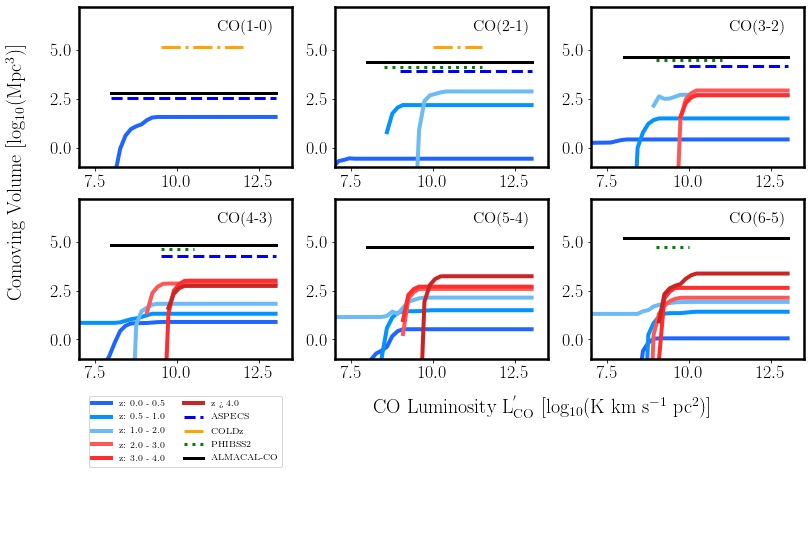

z: 0-0.5 1424.3931288693555
z: .5-1 6911.167763362435
z: 1.0-2.0 34835.27855001854
z: 2.0-3.0 45336.24886808672
z: 3.-4.0 50779.000272596044
z > 4.0  92290.72079867934
total 231576.80938161243


In [89]:
# Volumes


# mpl.rc ('xtick',labelsize=15)
# mpl.rc ('ytick',labelsize=15)

# plt.rc('font', family='serif', size=18)

COVol = np.loadtxt("Volumes_CO_CII_new.txt", skiprows=3) #"ALMACALdeep_Volumes_CO.txt"
luminosities = np.linspace(5,13,50)

color_almacal='#d11141'
color_aspecs='#00aedb'
color_coldz='#ffc425'
color_phibss='#0f8400'
M = np.size(COVol.T[0])
N = np.size(COVol[0])
lum_n = 50
logLUM = np.linspace(5,13,lum_n)
transitions = range(0,6)
conidtion = (COVol.T[0]==0)

#plt.hist(COVol.T[0], align='mid')
fig = plt.figure(1,figsize=(13,10))
fig.text(0.62, 0.32, r"CO Luminosity L$_{\rm CO}^{'}$ [log$_{10}$(K km s$^{-1}$ pc$^{2}$)]", ha='center', va='center',fontsize=20)
fig.text(0.06, 0.65, r'Comoving Volume [log$_{10}$(Mpc$^{3}$)]', ha='center', va='center', rotation='vertical',fontsize=20)
labels = ["CO(1-0)","CO(2-1)","CO(3-2)","CO(4-3)","CO(5-4)","CO(6-5)","CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)"]

color = ["#1e66ff", "#0393ff", "#6cbbf6", "#fe5757", "#fe2e2e", "#cb2424"]
v1,v2,v3,v4,v5,v6=0,0,0,0,0,0
nn=4
for j in transitions:
	subarray=COVol[COVol.T[0]==j]
	M=np.shape(subarray)[0]

	Vol_z005=np.zeros((lum_n))
	Vol_z051=np.zeros((lum_n))
	Vol_z12=np.zeros((lum_n))
	Vol_z23=np.zeros((lum_n))
	Vol_z34 = np.zeros((lum_n))
	Vol_z4 = np.zeros((lum_n))
	for i in range(M):
		zmean = subarray[i][1]
		#print(zmean)
		Vol_total = subarray[i][2:]
		if zmean <= 0.5:
		 	Vol_z005+=(Vol_total)
		elif zmean > 0.5 and zmean <=1.0:
		 	Vol_z051+=(Vol_total)
		elif zmean > 1.0 and zmean <= 2.0:
			Vol_z12+= (Vol_total)
		elif zmean > 2.0 and zmean <= 3.0:
			Vol_z23+=(Vol_total)
		elif zmean > 3.0 and zmean <= 4.0:
			Vol_z34+=(Vol_total)
		else:
			Vol_z4 +=(Vol_total)

	vol_tot = np.sum(Vol_z005+Vol_z051+Vol_z12+Vol_z23+Vol_z34+Vol_z4)
	

	v1+=np.sum(Vol_z005)
	v2+= np.sum(Vol_z051)
	v3 += np.sum(Vol_z12)
	v4+= np.sum(Vol_z23)
	v5 +=np.sum(Vol_z34)
	v6+=np.sum(Vol_z4 )
	Vol_z005,Vol_z051,Vol_z12,Vol_z23,Vol_z34,Vol_z4 = np.log10(Vol_z005),np.log10(Vol_z051),np.log10(Vol_z12),np.log10(Vol_z23),np.log10(Vol_z34),np.log10(Vol_z4)			
	

	plt.subplot(3,3,j+1)
	V1,=plt.plot(logLUM, Vol_z005, '-',c=color[0], lw=nn,label='z: 0.0 - 0.5')#,c='b')
	V2,=plt.plot(logLUM, Vol_z051, '-',c=color[1],lw=nn, label='z: 0.5 - 1.0')#,c='b')
	V3,=plt.plot(logLUM, Vol_z12, '-',c=color[2], lw=nn, label='z: 1.0 - 2.0')#,c='b
	V4,=plt.plot(logLUM, Vol_z23, '-', c=color[3],lw=nn,label='z: 2.0 - 3.0')#,c='b')
	V5,=plt.plot(logLUM, Vol_z34, '-',c=color[4],lw=nn,label='z: 3.0 - 4.0')#,c='b')
	V6,=plt.plot(logLUM, Vol_z4, '-', c=color[5],lw=nn,label='z > 4.0 ')#,c='b')
	print(j,vol_tot )
	print(min(subarray.T[1]), max(subarray.T[1]) )
	#plt.yscale("log")
	plt.annotate(labels[j], (0.65,0.85), xycoords='axes fraction', fontsize=16)

	### add other volumes to subplots
	if j ==0: #CO(1-0)

		# leg1=plt.legend(fontsize=9.5, ncol=2, loc='upper center')
		
		a,=plt.plot([8.,13.], [np.log10(338),np.log10(338)], lw=3,ls='--', c='b', label="ASPECS") #ASPECS
		c,=plt.plot([9.5,12.], [np.log10(20189+131042)]*2, lw=3,ls='-.', c='orange', label="COLDz") #COLDz
		d,=plt.plot([8.,13.], [2.8]*2,lw=3,ls='-', c='k', label="ALMACAL-CO" )
	if j ==1: #CO(2-1)
		a,=plt.plot([9.,13.], [np.log10(8198),np.log10(8198)], lw=3,ls='--', c='b', label='ASPECS') #ASPECS
		c,=plt.plot([10,11.5], [np.log10(20189+131042)]*2, lw=3,ls='-.' ,c='orange', label='COLDz') #COLDz
		p,=plt.plot([8.5,11.5], [np.log10(13541)]*2, lw=3,ls=':', c='g', label="PHIBSS2") #PHIBSS
		d,=plt.plot([8.,13.], [4.38]*2,lw=3,ls='-', c='k', label="ALMACAL-CO" )
	if j==2: #CO(3-2)
		plt.plot([9.5,13], [np.log10(14931)]*2, lw=3,ls='--' , c='b') #ASPECS
		plt.plot([9.,11], [np.log10(31954)]*2, lw=3,ls=':',c='g') #PHIBSS	
		plt.plot([8.,13.], [4.67]*2,lw=3,ls='-', c='k', label="ALMACAL-CO" )	
		

		#leg2=plt.legend([a,c,p,d],['ASPECS', 'COLDz', 'PHIBSS2', 'ALMACAL-CO'],fontsize=10, ncol=2, loc='upper center')

	if j==3: #CO(4-3)
		plt.plot([9.5,13], [np.log10(18248)]*2, lw=3, ls='--', c='b') #ASPECS	
		plt.plot([9.5,10.5], [np.log10(44503)]*2, lw=3,ls=':',c='g') #PHIBSS
		plt.plot([8.,13.], [4.82]*2,lw=3,ls='-', c='k', label="ALMACAL-CO" )
	if j ==4: #CO(5-4)

		plt.plot([9.5,10], [np.log10(52387)]*2, lw=3,ls=':',c='g') #PHIBSS
		plt.plot([8.,13.], [4.72]*2,lw=3,ls='-', c='k', label="ALMACAL-CO" )
	if j==5: #CO(6-5)
		plt.plot([9,10], [np.log10(57360)]*2, lw=3,ls=':',c='g') #PHIBSS
		plt.plot([8.,13.], [5.22]*2,lw=3,ls='-', c='k')

	plt.ylim([-1,7.2])
	plt.xlim([7,13.5])

plt.subplot(3,3,7)

leg1=plt.legend([V1,V2,V3,V4,V5,V6,a,c,p,d],['z: 0.0 - 0.5','z: 0.5 - 1.0','z: 1.0 - 2.0','z: 2.0 - 3.0','z: 3.0 - 4.0','z > 4.0 ','ASPECS', 'COLDz', 'PHIBSS2', 'ALMACAL-CO'],fontsize=9.5, ncol=2, loc='upper center')

plt.axis("off")
plt.xlim([-1,1])
plt.ylim([-1,1])


plt.show()

print("z: 0-0.5", v1)
print("z: .5-1", v2)
print("z: 1.0-2.0", v3)
print("z: 2.0-3.0", v4)
print("z: 3.-4.0",v5)
print("z > 4.0 ",v6)
print("total",v1+v2+v3+v4+v5+v6)
fig.savefig("volumes.png")
#


2.9813655090785445
er 0.175 mean 0.175
4.272908612690247
er 0.85 mean 0.85
4.5874303223714055
er 1.575 mean 1.575
4.6973775705976175
er 2.1500000000000004 mean 2.25
4.768186555456656
er 2.8 mean 3.0
4.81118611143275
er 3.545 mean 3.5549999999999997


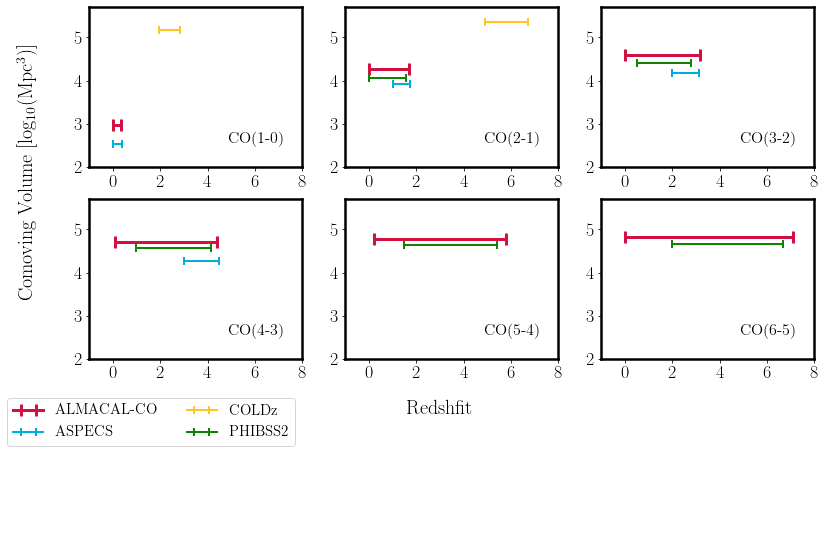

In [90]:
# Volumes comparison

COVol = np.loadtxt("Volumes_CO_CII_new.txt", skiprows=3) #"ALMACALdeep_Volumes_CO.txt"
luminosities = np.linspace(5,13,50)
redshift = np.linspace(0,10,100)

color_almacal='#d11141'
color_aspecs='#00aedb'
color_coldz='#ffc425'
color_phibss='#0f8400'


transitions = range(0,6)

fig = plt.figure(1,figsize=(13,10))
fig.text(0.5, 0.32, r"Redshfit", ha='center', va='center',fontsize=20)
fig.text(0.06, 0.65, r'Comoving Volume [log$_{10}$(Mpc$^{3}$)]', ha='center', va='center', rotation='vertical',fontsize=20)
labels = ["CO(1-0)","CO(2-1)","CO(3-2)","CO(4-3)","CO(5-4)","CO(6-5)","CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)"]

nn=3

almacal_vol = np.array([958, 18746, 38675, 49817, 58639, 64742])
almacal_z=np.array([[0,0.35], [0, 1.7], [0, 3.15], [0.1, 4.4], [0.2, 5.8], [0.01, 7.10]])

for j in transitions:
    print(np.log10(almacal_vol[j]))
    
    plt.subplot(3,3,j+1)
    plt.ylim([2,5.7])
    plt.xlim([-1,8])
    plt.xticks([0,2,4,6,8])
    plt.annotate(labels[j], (0.65,0.15), xycoords='axes fraction', fontsize=16)
    er = (float(almacal_z[j][1])-float(almacal_z[j][0]))/2.
    print("er", er, "mean",np.mean(almacal_z[j]))
    al=plt.errorbar(np.mean(almacal_z[j]), np.log10(almacal_vol[j]), xerr=er ,fmt='-',c=color_almacal,capthick=nn, capsize=nn*2, lw=nn,label='ALMACAL')

    ### add other volumes to subplots
    if j ==0: #CO(1-0)

        a=plt.errorbar(np.mean([0.003, 0.37]), np.log10(338), xerr = (0.37)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_aspecs, label="ASPECS") #COLDz
        c=plt.errorbar(np.mean([1.95,2.85]), np.log10(20189+131042), xerr = (2.85-1.95)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_coldz, label="COLDz") #COLDz
    if j ==1: #CO(2-1)
        a=plt.errorbar(np.mean([1., 1.74]), np.log10(8198), xerr = (0.74)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_aspecs, label="ASPECS") #COLDz
        c=plt.errorbar(np.mean([4.9,6.7]), [np.log10(30398+193286)], xerr = abs(4.9-6.7)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_coldz, label="COLDz") #COLDz
        p=plt.errorbar(np.mean([0.017, 1.562]), [np.log10(11250)], xerr = abs(0.017- 1.562)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_phibss, label="PHIBSS2") #COLDz

    if j==2: #CO(3-2)
        a=plt.errorbar(np.mean([2.,3.11]), np.log10(14931), xerr = (3.11-2.)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_aspecs, label="ASPECS") #COLDz
        p=plt.errorbar(np.mean([0.5, 2.8]), [np.log10(26136)], xerr = abs(0.5 - 2.8)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_phibss, label="PHIBSS2") #COLDz

    if j==3: #CO(4-3)
        a=plt.errorbar(np.mean([3, 4.48]), np.log10(18242), xerr = (3-4.48)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_aspecs, label="ASPECS") #COLDz
        p=plt.errorbar(np.mean([0.989, 4.124]), [np.log10(36144)], xerr = abs(0.989 -4.124)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_phibss, label="PHIBSS2") #COLDz

    if j ==4: #CO(5-4)

        p=plt.errorbar(np.mean([1.486, 5.405]), [np.log10(42380)], xerr = abs(1.486 -5.405)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_phibss, label="PHIBSS2") #COLDz

    if j==5: #CO(6-5)
        p=plt.errorbar(np.mean([1.98, 6.685]), [np.log10(46288)], xerr = abs(1.98 - 6.685)/2., lw=2,capthick=2, capsize=4, fmt='-', c=color_phibss, label="PHIBSS2") #COLDz



plt.subplot(3,3,7)

plt.legend([al, a,c,p],['ALMACAL-CO','ASPECS', 'COLDz', 'PHIBSS2'],fontsize=15, ncol=2,loc='upper right')

plt.axis("off")
plt.xlim([-1,1])
plt.ylim([-1,1])


plt.show()

fig.savefig("volumes2.png")
#


/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10


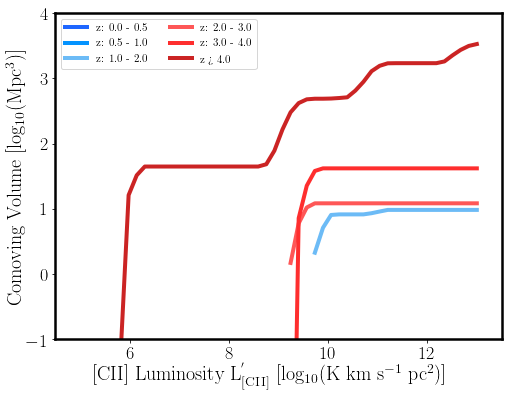

In [91]:
#volume CII

# mpl.rc ('xtick',labelsize=15)
# mpl.rc ('ytick',labelsize=15)

# plt.rc('font', family='serif', size=18)

COVol = np.loadtxt("Volumes_CO_CII_new.txt", skiprows=3)
luminosities = np.linspace(5,13,50)

M = np.size(COVol.T[0])
N = np.size(COVol[0])
lum_n = 50
logLUM = np.linspace(5,13,lum_n)
transitions = range(0,6)
conidtion = (COVol.T[0]==0)

#plt.hist(COVol.T[0], align='mid')
fig = plt.figure(1,figsize=(8,6))
fig.text(0.5, 0.04, r"[CII] Luminosity L$_{\rm [CII]}^{'}$ [log$_{10}$(K km s$^{-1}$ pc$^{2}$)]", ha='center', va='center',fontsize=20)
fig.text(0.06, 0.5, r'Comoving Volume [log$_{10}$(Mpc$^{3}$)]', ha='center', va='center', rotation='vertical',fontsize=20)

color = ["#1e66ff", "#0393ff", "#6cbbf6", "#fe5757", "#fe2e2e", "#cb2424"]
nn=4
j=9
subarray=COVol[COVol.T[0]==j]
M=np.shape(subarray)[0]

Vol_z005=np.zeros((lum_n))
Vol_z051=np.zeros((lum_n))
Vol_z12=np.zeros((lum_n))
Vol_z23=np.zeros((lum_n))
Vol_z34 = np.zeros((lum_n))
Vol_z4 = np.zeros((lum_n))
for i in range(M):
	zmean = subarray[i][1]
	
	Vol_total = subarray[i][2:]
	if zmean <= 0.5:
	 	Vol_z005+=(Vol_total)
	elif zmean > 0.5 and zmean <=1.0:
	 	Vol_z051+=(Vol_total)
	elif zmean > 1.0 and zmean <= 2.0:
		Vol_z12+= (Vol_total)
	elif zmean > 2.0 and zmean <= 3.0:
		Vol_z23+=(Vol_total)
	elif zmean > 3.0 and zmean <= 4.0:
		Vol_z34+=(Vol_total)
	else:
		Vol_z4 +=(Vol_total)

        

Vol_z005,Vol_z051,Vol_z12,Vol_z23,Vol_z34,Vol_z4 = np.log10(Vol_z005),np.log10(Vol_z051),np.log10(Vol_z12),np.log10(Vol_z23),np.log10(Vol_z34),np.log10(Vol_z4)			


plt.plot(logLUM, Vol_z005, '-',c=color[0], lw=nn,label='z: 0.0 - 0.5')#,c='b')
plt.plot(logLUM, Vol_z051, '-',c=color[1],lw=nn, label='z: 0.5 - 1.0')#,c='b')
plt.plot(logLUM, Vol_z12, '-',c=color[2], lw=nn, label='z: 1.0 - 2.0')#,c='b
plt.plot(logLUM, Vol_z23, '-', c=color[3],lw=nn,label='z: 2.0 - 3.0')#,c='b')
plt.plot(logLUM, Vol_z34, '-',c=color[4],lw=nn,label='z: 3.0 - 4.0')#,c='b')
plt.plot(logLUM, Vol_z4, '-', c=color[5],lw=nn,label='z > 4.0 ')#,c='b')


#plt.annotate("C[II]", xy=(0.05, 0.55), xycoords='axes fraction',fontsize=16)

plt.legend(fontsize=11, ncol=2, loc=2)
plt.ylim([-1,4])
plt.xlim([4.5,13.5])
fig.savefig("Volume_CII.png")
plt.show()


### Detections plot - paper

/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cset = super().contour(*args, **kwargs)


['J0006-0623.large.mom0.fits' 'J0510+1800.large.mom0.fits'
 'J1924-2914.large.mom0.fits' 'J2356-5311.large.mom0.fits']
['uid___A001_X5ac_X38f.cube_23.J0006-0623_B7'
 'uid___A001_X5ac_X138c.cube_0.J0510+1800_B7'
 'uid___A001_X5ad_X888.cube_12.J1924-2914_B6'
 'uid___A001_X5ad_Xea5.cube_01.J2357-5311_B4'
 'uid___A001_X5ac_X1fe_04.cube_01.J0334-4008_B3'
 'uid___A001_X5ac_X1fe_02.cube_23.J0334-4008_B3']
0.347
ALMACAL J000614.36-062329.4 35 35
(50, 50)
0.416
ALMACAL J051002.35+180052.5 31 38
(124, 76) (124, 76)
62 38
(50, 50)
0.4
ALMACAL J192450.65-291444.7 33 35
(50, 50)
0.35
ALMACAL J235752.46-531120.7 48 57
(90, 90)


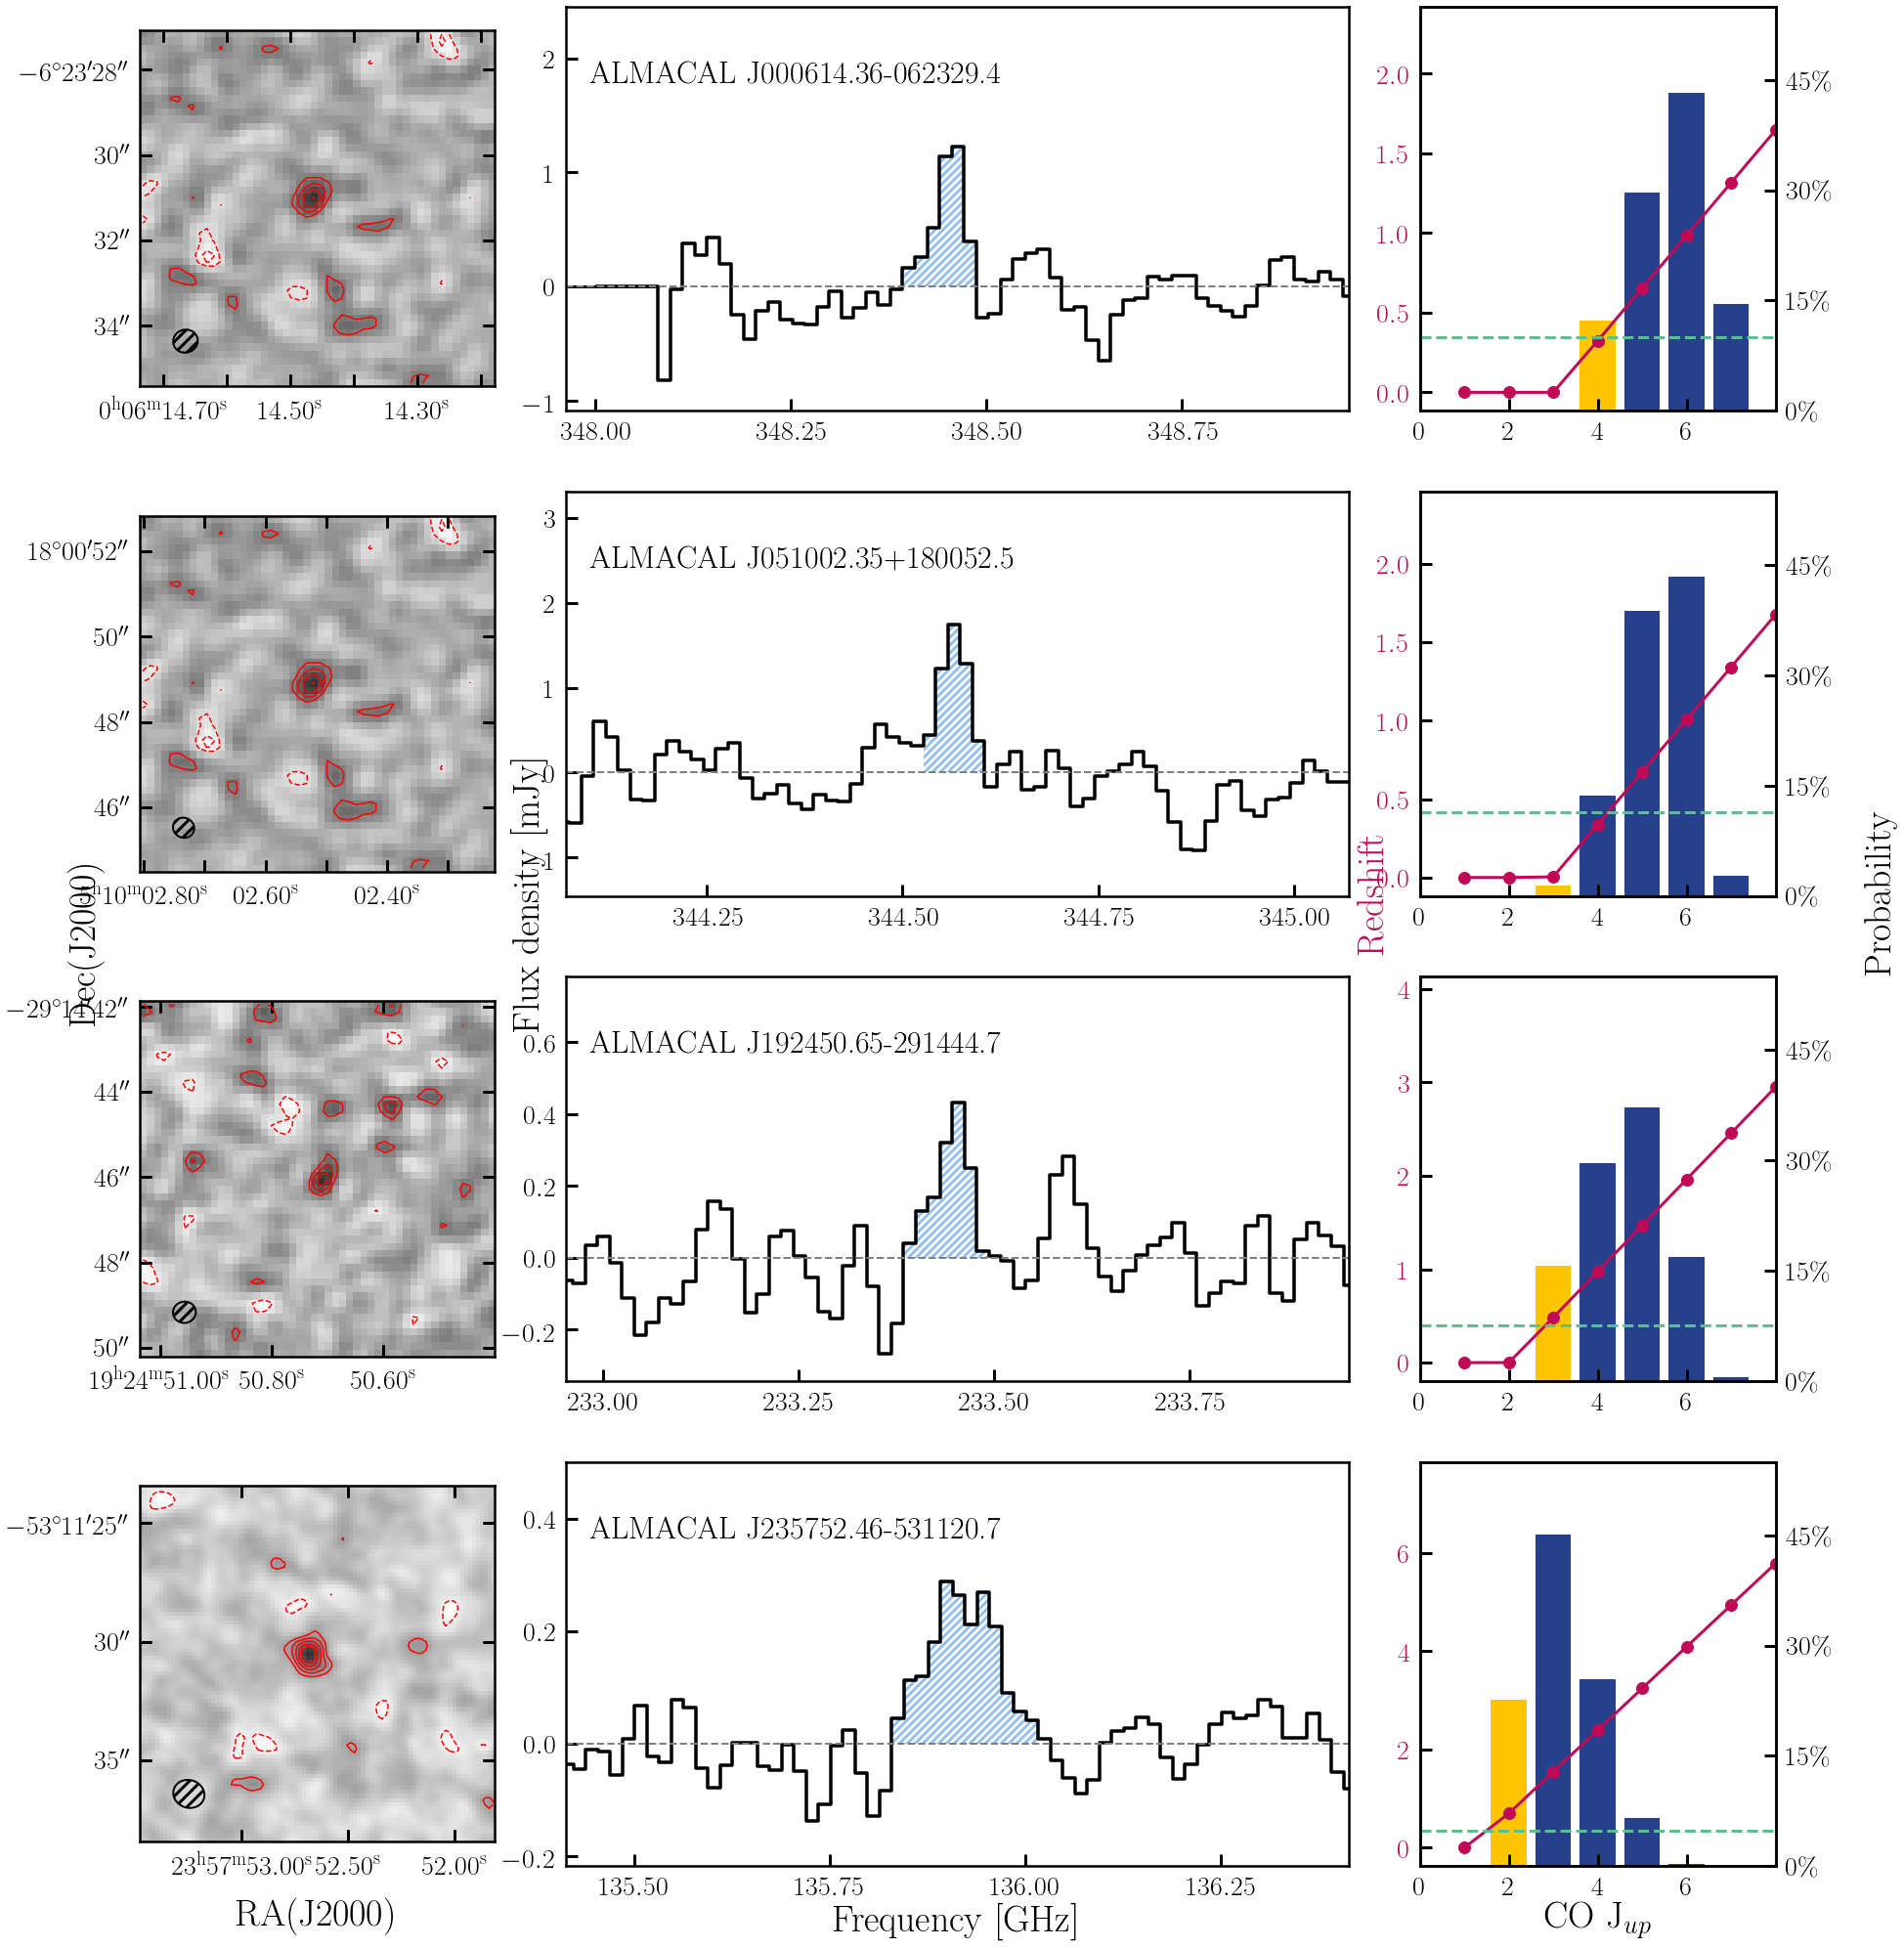

In [92]:
## Plot the detections with the transition probabilities
mpl.rcParams['hatch.linewidth'] = 3.0
mpl.rc ('xtick',labelsize=28)
mpl.rc ('ytick',labelsize=28)
mpl.rc('font',family='serif', size=38)
mpl.rcParams['axes.linewidth'] = 2.5
########## colours - Hogwart is my Home palette #######
#Hogwart is my Home palette
red='#b70000'
yellow='#ffc600'
blue='#000f9e'
green='#0f8400'

#Fruit salad	
beam='#cccccc'
contour='navy'#'#baffb0'
circ=red#'#ff6363'
########################################
def gaussian(x, amp, cen, wid):
    return amp * exp(-(x-cen)**2 /wid)

def freq_from_vel(f0,vel):
    f = f0*(1-vel/3.e5)
    return f

d=20
path="/Users/ahamanow/Desktop/ALMA/CO_search/ALMA_fields/candidates/"
cubes, clas,spectxt= np.loadtxt('candidates_list.txt', usecols=(1,12,19),dtype='str',comments='#', unpack=True) #edited version for plotting, original can be found under the path
X,Y,Z,Width, SN, w50, f0, rms, intflux = np.loadtxt('candidates_list.txt', usecols=(3,4,5,7,6,11,10,14,12),dtype='float', unpack=True)
mom0 = np.loadtxt("large.mom0.txt",dtype='str')
print(mom0)
#print X,Y,Z
#print clas
names=['ALMACAL J000614.36-062329.4','ALMACAL J051002.35+180052.5','ALMACAL J192450.65-291444.7','ALMACAL J235752.46-531120.7']
N = np.size(cubes)
chan_width =  0.0155639648438 #GHz
vel_lim=1000.
print(cubes)

#### probabiities
probabilities = np.array([
 [ 0 ,0 ,0, 12.328 ,29.65,43.29, 14.526,0.205, 0, 0,  ],
 [ 0 ,0, 1.403 ,13.666, 38.754, 43.413, 2.757, 0.007, 0, 0],
#[ 0 , 0 , 0, 13.035 ,34.386, 45.692, 6.793,0.094, 0, 0 ], 
 [ 0 ,0, 15.698 , 29.665, 37.253, 16.9, 0.483, 0, 0, 0 ],
 [0,  22.65, 45.071, 25.446, 6.541, 0.293, 0, 0, 0, 0.0 ]])

redshifts = np.array([
 [ 0 , 0 , 0 , 0.323 ,0.654 , 0.984 ,1.315 ,1.645 ,1.976 ,2.306 ],
 [ 0 ,0 , 0.004 , 0.338 , 0.672 , 1.007  , 1.341  ,1.675 , 2.009  , 2.343],
 #[ 0 , 0 , 0 , 0.329 , 0.662 , 0.994 , 1.326 , 1.658 , 1.990 , 2.322 ],
[  0 , 0 , 0.481 , 0.975 , 1.468 , 1.962 , 2.455 , 2.948 ,3.441, 3.934 ],
[  0 , 0.696 , 1.544 , 2.392 , 3.24 , 4.088 , 4.935 , 5.782 , 6.629 , 7.476 ]])

blazar=np.array([0.347,0.416, 0.4, 0.35, 1.006])


contours=np.array([
    [-0.06,-0.049,-0.038,0.038,0.049,0.06],
    [ -0.117,  -0.102,-0.086, -0.07, 0.07,0.086, 0.102, 0.117],   
   # [-0.102,-0.0681, 0.0681,0.102],
    [-0.0612- 0.049,-0.0368,-0.0246,0.0246,0.0368, 0.049, 0.0612],
    [-0.1257,-0.1006,-0.0755,-0.0504,0.0504,0.0755,0.1006,0.1257]])

lowestJ=np.array([4,3,3,2])

pb_corr=np.array([0.4468, 0.2997, 0.355, 0.636])

fig=plt.figure(1,figsize=(30,35))

red='#c00a56'
hist='#27408b'

n=0
fordash='#96c0eb'
sub=4
M=4
for i in range(0,M,1):

    stats = cubes[i]+".stats"
    with open("/Users/ahamanow/Desktop/ALMA/CO_search/ALMA_fields/cubes_stats/"+stats) as f:
        content = f.read().splitlines()
    a,b = content[3].split('\t')[1].split(' ')
    pa = content[4].split('\t')[1].split(' ')[0]
    #print(pa)

   
    beam_a,beam_b, beam_pa =float(a),float(b),float(pa)

    #read in 0-moment map from CASA
    mom0map = "/Users/ahamanow/Desktop/ALMA/almacal-deep-figures/"+mom0.T[i]
    hdul_mom0 = fits.open(mom0map)
    mom0_map = hdul_mom0[0].data
    wcs = WCS(hdul_mom0[0].header)

    wcs=wcs.dropaxis(2)
    #mom0sigma = float(mom0.T[1][i])

    ax1 = plt.subplot2grid((sub,4),(i,1), colspan=2)
    ax2 = plt.subplot2grid((sub,4),(i,0),projection=wcs)
    ax3 = plt.subplot2grid((sub,4),(i,3))
    #probability
    ax3.bar(range(1,11,1),probabilities[i], color=hist)
    
    print(blazar[i])
    lowJ=lowestJ[i]
    ax3.bar(lowJ, probabilities[i][lowJ-1], color='#ffc600')
    #ax3.annotate(names[i], (0.4,0.88), xycoords='axes fraction', fontsize=15)
    ax32 = ax3.twinx() 
    ax32.plot(range(1,11,1), redshifts[i], 'o-',color=red, lw=3, ms=12 )
    ax32.axhline(blazar[i], ls='--', c='#5ac18e', lw=3)
    ax3.set_ylim([0,55])
    ax3.set_xticks([0,2,4,6])
    ax3.set_xlim([0,8])
    ax32.tick_params(axis='y', labelcolor=red)


    #aperture spectrum
    spec = np.loadtxt("/Users/ahamanow/Desktop/ALMA/almacal-deep-figures/aperture-spectra/"+spectxt[i], comments='#')

    ## spectrum stats
    flux = spec.T[1]*pb_corr[i]
    med=np.median(flux)*1.e3
    sigma=np.std(flux)*1.e3
    mean = np.mean(flux)*1.e3	
    rms = np.sqrt(np.sum(flux**2))
    #print("mean", mean)
    ## ax1 - zoomed spectrum over detection
    ax1.step(spec.T[0],flux*1e3, c='k', where='pre', lw=3.5)
    #print(f0[i])
    f1,f2 = min(f0[i]-.5,f0[i]+.5), max(f0[i]-.5,f0[i]+.5) #freq_from_vel(f0[i], -vel_lim),freq_from_vel(f0[i], vel_lim)
    ax1.set_xlim([f1,f2])
    #ax1.axvline(f0[i], ls='--', lw=2, c='gray')

    ax1.fill_between(spec.T[0][int(Z[i] - Width[i]/2.)+1:int(Z[i] +Width[i]/2.)],flux[int(Z[i] - Width[i]/2.)+1:int(Z[i] +Width[i]/2.)]*1e3, step='pre', facecolor='none', edgecolor='#96c0eb', hatch='///',lw=0)
    ax1.set_ylim(mean- 3.5*sigma, mean+8*sigma)
    if "J0006" in names[i]:
        ax1.plot([347.3,348.08],[0,0], '-',c='k',lw=3)
    if "J0510" in names[i]:
        ax1.plot([343,343.8],[0,0],'-', c='k',lw=3)
    #if "J1651" in names[i]:
    #    ax1.plot([347.3,348],[0,0],'-', c='k',lw=3)
    
    if "J0334" in names[i]:
        c='#00cc00'
        ax3.annotate("", xy=(1, 40), xytext=(1, 60), arrowprops=dict(arrowstyle="->",color=c, lw=3))	
        ax3.annotate("observed z", xy=(0.2, 65), c=c)		

    ax1.xaxis.set_major_locator(MaxNLocator(4))
    ax1.annotate(names[i], (0.03,0.81), xycoords='axes fraction', fontsize=32)
    ax1.tick_params('both', direction="in", length=12,width=3, pad=10)
    ax1.tick_params('both', direction="in", length=12,width=3, pad =10)
    ax1.axhline(0, ls='--', lw=2, c='gray')
    #if i in [12,13]:
    #	ax1.annotate("no-CO", (0.7,0.9), xycoords='axes fraction', fontsize=12)
    #### fits image ######
    ## plot the zoomed fits + beam

    box = AnchoredAuxTransformBox(ax2.transData, loc=3,frameon=False)
    el = Ellipse((0,0), width=beam_b, height=beam_a, angle=beam_pa,fc="none",ec='k',lw=2, hatch='//') 
    box.drawing_area.add_artist(el)
    ra = ax2.coords[0]
    ra.set_major_formatter('hh:mm:ss.ss')

    cx,cy=int(np.shape(mom0_map[0])[0]/2.),int(np.shape(mom0_map[0])[1]/2.)
    dx,dy=25,25
    print(names[i],cx,cy)
#     if "J0006" in names[i]:
#         cx+=2
    if "J2357" in names[i]:
        dx,dy=45,45
        #cy+=5
    if "J1924" in names[i]:
        cy -=5
    if "J0510" in names[i]:
        m = mom0_map[0]
        S = np.shape(m)[1]
        m2 = np.zeros((np.shape(m)[0],S))
        y = np.append(m,m2, axis=0)
        print(np.shape(y), np.shape(x))
        cx,cy=int(np.shape(y)[0]/2.),int(np.shape(y)[1]/2.)
        print(cx,cy)
        cx-=12
        cy-=15
#     if "J1651" in names[i]: 
#         m = mom0_map[0]
#         S = np.shape(m)[1]
#         m2 = np.zeros((np.shape(m)[0], S))
#         x = np.append(m2,m, axis=1)
#         cx,cy=int(np.shape(x)[0]/2.),int(np.shape(x)[1]/2.)
#         cy +=17

        
#     if "J1651" in names[i]: 
        
       # L =x[cx-dx:cx+dx,cy-dy:cy+dy]
    elif "J0510" in names[i]: 
        
        L =y[cx-dx:cx+dx,cy-dy:cy+dy]
        print(cx-dx,cx+dx,cy-dy,cy+dy)
        print(np.shape(y))
        print(np.shape(L), cy, dy, np.shape(y))
    else:
        L =mom0_map[0][cx-dx:cx+dx,cy-dy:cy+dy]
    ax2.imshow(L, cmap='binary', alpha=0.8)
    std = np.std(L)
    print(np.shape(L))
    #print(np.mean(L), np.std(L), np.max(L))
    contours=[-4*std, -3*std, -2*std, 2*std, 3*std, 4*std, 5*std, 6*std]
    ax2.contour(L, levels=contours, colors='red', linewidths=1.5, interpolation='gaussian') 
    ax2.add_artist(box)
#     ax2.imshow(mom0_map[0], cmap='viridis') 
#     ax2.contour(mom0_map[0], levels=contours[i], colors='#c71585', linewidths=3.5, interpolation='gaussian') 
#     ax2.add_artist(box)

    lon = ax2.coords[0]
    lat = ax2.coords[1]
    lon.set_ticks(exclude_overlapping=True)
    lon.tick_params('both', direction="in", length=12,width=3,pad=10)
    lat.tick_params('both', direction="in", length=12,width=3,pad=10)
    lat.set_ticks(exclude_overlapping=True)
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')

    ax3.yaxis.set_label_position("right")
    ax32.yaxis.set_label_position("left")
    ax3.yaxis.tick_right()
    ax32.yaxis.tick_left()
    ax3.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax3.yaxis.set_major_locator(MaxNLocator(4))
    ax3.tick_params('both', direction="in", length=12,width=3,pad=10)
    ax32.tick_params('both', direction="in", length=12,width=3,pad=10)

    if i == M-1:
        ax2.set_xlabel('RA(J2000)')
        ax1.set_xlabel('Frequency [GHz]')
        ax3.set_xlabel(r'CO J$_{up}$')
    if i == M-2 and i > 5 :
        ax1.set_ylabel('Flux density [mJy]')
        ax2.set_ylabel('Dec(J2000)')
        ax32.set_ylabel("Redshfit",c=red)
        ax3.set_ylabel("Probability")

    if i == M-2 and i < 5 :
        fig.text(0.95, 0.52, 'Probability', ha='center', va='center', rotation='vertical',)
        fig.text(0.71, 0.52, 'Redshift', ha='center', va='center', rotation='vertical', c=red, )
        fig.text(0.31, 0.52, 'Flux density [mJy]', ha='center', va='center', rotation='vertical', c='k',)
        fig.text(0.1, 0.5, 'Dec(J2000)', ha='center', va='center', rotation='vertical', c='k',)

plt.show()
fig.savefig("ALMACAL-CO-detections.png",bbox_inches='tight')



(62, 76)
(62, 76) (62, 76) 76


(124, 76)

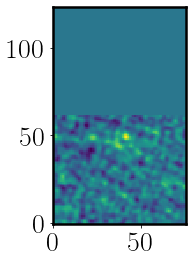

In [93]:
mom0='ALMACAL J051002.35+180052.5'
mom0map = "/Users/ahamanow/Desktop/ALMA/almacal-deep-figures/J0510+1800.large.mom0.fits"
hdul_mom0 = fits.open(mom0map)
mom0_map = hdul_mom0[0].data
m = mom0_map[0]
plt.imshow(m, origin='lower', cmap='binary')
print(np.shape(m))
S = np.shape(m)[1]
m2 = np.zeros((np.shape(m)[0],S))
print(np.shape(m2), np.shape(m),S)
x = np.append(m,m2, axis=0)
m2 = m
plt.imshow(x, origin='lower')
np.shape(x)

In [94]:
#restore tick size
mpl.rc ('xtick',labelsize=15)
mpl.rc ('ytick',labelsize=15)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

In [95]:
### use transition array to draw the probable samples
ntry= 1000 # muber of tries for probability drawing
results_array=np.zeros((ntry*Nproberr,S,3)) #[ntries],[nprob][z,L'1-0,MH2, comp]
nr_detections= np.shape(transitions_array)[0]
alpha=4.3
print(nr_detections)
nr_trans = np.shape(transitions_array)[2]

6


In [96]:
####create redhsift bins for roH2 - 

# ASPECS - like bins egdes
z_bins = np.array([0,0.5,1.0,1.5,2.0,3.,4.])
ZB=np.size(z_bins)-1
errors_array=np.zeros((ntry,ZB,6)) # [ntries][bin] [ errors 1u,2u,3u,1l,2l,3l]
# corresponding volume: in these redhsift bins sum the volumes coming from each transition to get Volume [Mpc^3] per z bin
Volumes = np.array([1452.4,  7243.45, 20877.1, 21431.8, 55972.37, 367324.1]) #bvolume per redshfi bin
# luminosity bins 0.5 dex
luminosity_bins = np.arange(8,13,1) #8-8.5, 8.5-9, 9-9.5, 9.5-10, 10-10.5, 10.5-11, 11-11.5, 11.5-12, 12-12.5

LFa1, LFa2, LFa3, LFa4, LFa5,LFa6=np.zeros((1,np.size(luminosity_bins)-1)), np.zeros((1,np.size(luminosity_bins)-1)), np.zeros((1,np.size(luminosity_bins)-1)),np.zeros((1,np.size(luminosity_bins)-1)),np.zeros((1,np.size(luminosity_bins)-1)),np.zeros((1,np.size(luminosity_bins)-1))
LFa1err, LFa2err, LFa3err, LFa4err, LFa5err,  LFa6err=np.zeros((6,np.size(luminosity_bins)-1)), np.zeros((6,np.size(luminosity_bins)-1)), np.zeros((6,np.size(luminosity_bins)-1)),np.zeros((6,np.size(luminosity_bins)-1)),np.zeros((6,np.size(luminosity_bins)-1)),np.zeros((6,np.size(luminosity_bins)-1))
MH1err, MH2err, MH3err, MH4err, MH5err,MH6err=np.zeros((6,np.size(z_bins)-1)), np.zeros((6,np.size(z_bins)-1)), np.zeros((6,np.size(z_bins)-1)),np.zeros((6,np.size(z_bins)-1)),np.zeros((6,np.size(z_bins)-1)),np.zeros((6,np.size(z_bins)-1))

Lum1,Lum2,Lum3,Lum4,Lum5, Lum6 = [],[],[],[],[],[]
mh1,mh2,mh3,mh4,mh5, mh6 = [],[],[],[],[],[]
LFall = np.zeros((1,np.size(luminosity_bins)-1))

cubes, names= np.loadtxt('candidates_list.txt', usecols=(1,2),dtype='str',comments='#', unpack=True)
SN,Width,f0, int_flux, flux_err, fidelity= np.loadtxt('candidates_list.txt', usecols=(6,8,10,12,13,15),dtype='float', unpack=True)

print(names)
Nproberr=10

['J0006-0623' 'J0510+1800' 'J1924-2914' 'J2357-5311' 'J0334-4008'
 'J0334-4008']


In [97]:
#probability
for l in range(ntry): #realsations of the sample
    lco10_sample, zsmample=[],[]

    for zz in range(Nproberr):
        for n in range(nr_detections):
     
            P,prob = [],[]
            #for each detection

            if names[n] == 'J0334-4008':
                for m in range(nr_trans):
                    
                    # 1) create a table of transitions probabilities and table of indexes
                    if m==0:
                        P = np.append(P,1.)
                    else: 
                        P = np.append(P,0.)
            
            else:
                for m in range(nr_trans):
                    # 1) create a table of transitions probabilities and table of indexes

                    P = np.append(P,transitions_array[n][zz][m][0])
                    
            Indexes = np.array(range(10))
            # 2) draw a transition to be assigned to the detection, according to the probabilities
            #draw a transition index I
            I = np.random.choice(Indexes,size=1,p=P)[0]
          
            for k in range(3):
                
                results_array[l*Nproberr+zz][n][k] = transitions_array[n][zz][I][k+2] #[z,L'(1-0), completnes]
                #print(transitions_array[n][zz][I][k+2])

        

In [98]:
print(z_bins)

[0.  0.5 1.  1.5 2.  3.  4. ]


In [99]:
#Calculate the  CO luminosity function and H2 masses including the probability function for each detection

Z1,Z2,Z3,Z4,Z5,Z6=np.array([0]),np.array([0]),np.array([0]),np.array([0]),np.array([0]),np.array([0])
for l in range(ntry*Nproberr): 
    #### L'CO(1-0) Redshift bins
    l1,l2,l3,l4,l5,l6=np.array([[0,0]]),np.array([[0,0]]),np.array([[0,0]]),np.array([[0,0]]),np.array([[0,0]]),np.array([[0,0]])

    z1,z2  = z_bins[0],z_bins[1]
    
    for n in range(nr_detections):
        fid=fidelity[n]
  
        #print(n, results_array[l][n][0], np.log10(results_array[l][n][1]))
        if  z_bins[0] <= results_array[l][n][0] < z_bins[1]: #

            Z1 = np.vstack((Z1,results_array[l][n][0]))
            l1 = np.vstack((l1, [np.log10(results_array[l][n][1]),results_array[l][n][2]]))
        elif z_bins[1]  <= results_array[l][n][0] < z_bins[2]:

            l2 = np.vstack((l2, [np.log10(results_array[l][n][1]),results_array[l][n][2]]))
            Z2 = np.vstack((Z2,results_array[l][n][0]))
        elif z_bins[2]  <= results_array[l][n][0] < z_bins[3]:

            l3 = np.vstack((l3, [np.log10(results_array[l][n][1]),results_array[l][n][2]]))
            Z3 = np.vstack((Z3,results_array[l][n][0]))
        elif z_bins[3]  <= results_array[l][n][0] < z_bins[4]:

            l4 = np.vstack((l4, [np.log10(results_array[l][n][1]),results_array[l][n][2]]))
            Z4 = np.vstack((Z4,results_array[l][n][0]))
        elif z_bins[4]  <= results_array[l][n][0] < z_bins[5]:

            l5 = np.vstack((l5, [np.log10(results_array[l][n][1]),results_array[l][n][2]]))
            Z5 = np.vstack((Z5,results_array[l][n][0]))
        elif z_bins[5]  <= results_array[l][n][0] < z_bins[6]:

            l6 = np.vstack((l6, [np.log10(results_array[l][n][1]),results_array[l][n][2]]))
            Z6 = np.vstack((Z6,results_array[l][n][0]))
    #### Bin the luminocities in each z bin 
    ## secondary bin the molecular masses
    ## zbin 1 0.0 - 0.5

    if np.shape(l1)[0] > 1:
        lum,lum_raw=0,0
        ncounts= np.zeros((1,np.size(luminosity_bins)-1))
        for j in range(np.size(luminosity_bins)-1): # binning in luminosity
            for i in range(np.size(l1.T[0])):
                if l1.T[0][i] > 0:
                    
                    if luminosity_bins[j] <= l1.T[0][i] <  luminosity_bins[j+1]:
            
                        ncounts.T[j] += fid/l1.T[1][i]
                        lum += 10**l1.T[0][i]/l1.T[1][i]

        LF1 = ncounts*fid/Volumes[0]
        LFa1 = np.vstack((LFa1,LF1))

        ncounts_ma = np.ma.masked_where(ncounts == 0, ncounts)

        #poissonina errors
        errors=np.zeros((6,np.size(luminosity_bins)-1))
        for t in range(3):
            pl=Poiss_lower_limit(ncounts_ma,t+1)
            pu=Poiss_upper_limit(ncounts_ma,t+1)
            errors[t],errors[t+3]=pl*fid/Volumes[0],pu*fid/Volumes[0]
        LFa1err = np.dstack((LFa1err,errors))
       

        ## molecular masses
        mh = lum*alpha*fid/Volumes[0]
        if mh > 0:
            mh1.append(mh)	
        mh1_n = np.size(mh1)

        
        
        errors_mh=np.zeros((6,np.size(z_bins)-1))
        for t in range(6):
            for l, ll in zip(range(np.size(luminosity_bins)-1), [8.5,9.5,10.5,11.5]):
                errors_mh[t]+= alpha*errors[t][l]*10**ll
        # 	pl=Poiss_lower_limit(mh1_n,t+1)
        # 	pu=Poiss_upper_limit(mh1_n,t+1)

        # 	errors_mh[t],errors_mh[t+3]=pl*lum*fid/Volumes[0]/mh1_n,pu*lum*alpha*fid/Volumes[0]/mh1_n
        MH1err = np.dstack((MH1err,errors_mh))
    
        ## zbin 1 0.5 - 1.0
    if np.shape(l2)[0] > 1:
        
        lum, lum_raw=0,0
        ncounts= np.zeros((1,np.size(luminosity_bins)-1))
        for j in range(np.size(luminosity_bins)-1): # binning in luminosity
            for i in range(np.size(l2.T[0])):
                if l2.T[0][i] > 0:
                    if luminosity_bins[j] <= l2.T[0][i] <  luminosity_bins[j+1]:
                        
                        
                        ncounts.T[j] += fid/l2.T[1][i]
                        lum += 10**l2.T[0][i]/l2.T[1][i]
                        lum_raw+=10**l2.T[0][i]
                        
        LF2 = ncounts*fid/Volumes[1]
        LFa2 = np.vstack((LFa2,LF2))
        ncounts_ma = np.ma.masked_where(ncounts == 0, ncounts)

        #poissonina errors
        errors=np.zeros((6,np.size(luminosity_bins)-1))
        for t in range(3):
            pl=Poiss_lower_limit(ncounts_ma,t+1)
            pu=Poiss_upper_limit(ncounts_ma,t+1)
            errors[t],errors[t+3]=pl*fid/Volumes[1],pu*fid/Volumes[1]
        LFa2err = np.dstack((LFa2err,errors))

        ## molecular masses
        mh=lum*alpha*fid/Volumes[1]
        if mh > 0:
            mh2.append(mh)	
        mh2_n = np.size(mh2)
        errors_mh=np.zeros((6,np.size(z_bins)-1))
        for t in range(6):
            for l, ll in zip(range(np.size(luminosity_bins)-1), [8.5,9.5,10.5,11.5]):
                errors_mh[t]+= alpha*errors[t][l]*10**ll	## molecular mass errors
        # errors_mh=np.zeros((6,np.size(z_bins)-1))
        # for t in range(3):
        # 	pl=Poiss_lower_limit(mh2_n,t+1)
        # 	pu=Poiss_upper_limit(mh2_n,t+1)
        # 	errors_mh[t],errors_mh[t+3]=pl*lum*alpha*fid/Volumes[1]/mh2_n,pu*lum*alpha*fid/Volumes[1]/mh2_n
        MH2err = np.dstack((MH2err,errors_mh))
        
        ## zbin 1 1.0 - 1.5
    if np.shape(l3)[0] > 1:
        lum, lum_raw=0,0
        ncounts= np.zeros((1,np.size(luminosity_bins)-1))
        for j in range(np.size(luminosity_bins)-1): # binning in luminosity
            for i in range(np.size(l3.T[0])):
                if l3.T[0][i] > 0:
                    
                    if luminosity_bins[j] <= l3.T[0][i] <  luminosity_bins[j+1]:
                       
                        ncounts.T[j] += fid/l3.T[1][i]
                        #print(ncounts)
                        lum += 10**l3.T[0][i]/l3.T[1][i]
                        lum_raw+=10**l3.T[0][i]
        LF3 = ncounts*fid/Volumes[2]
        LFa3 = np.vstack((LFa3,LF3))
        ncounts_ma = np.ma.masked_where(ncounts == 0, ncounts)
        
        #poissonina errors
        errors=np.zeros((6,np.size(luminosity_bins)-1))
        for t in range(3):
            pl=Poiss_lower_limit(ncounts_ma,t+1)
            pu=Poiss_upper_limit(ncounts_ma,t+1)
            errors[t],errors[t+3]=pl*fid/Volumes[2],pu*fid/Volumes[2]

        LFa3err = np.dstack((LFa3err,errors))

        ## molecular masses
        mh=lum*alpha*fid/Volumes[2]
        if mh > 0:
            mh3.append(mh)	
        mh3_n = np.size(mh3)
        ## molecular mass errors
        errors_mh=np.zeros((6,np.size(z_bins)-1))
        for t in range(6):
            for l, ll in zip(range(np.size(luminosity_bins)-1), [8.5,9.5,10.5,11.5]):
                errors_mh[t]+= alpha*errors[t][l]*10**ll
        # for t in range(3):
        # 	pl=Poiss_lower_limit(mh3_n,t+1)
        # 	pu=Poiss_upper_limit(mh3_n,t+1)
        # 	errors_mh[t],errors_mh[t+3]=pl*lum*alpha*fid/Volumes[2]/mh3_n,pu*lum*alpha*fid/Volumes[2]/mh3_n
        MH3err = np.dstack((MH3err,errors_mh))

        ## zbin  1.5.0 - 2.0
    if np.shape(l4)[0] > 1:
        lum, lum_raw=0,0
        ncounts= np.zeros((1,np.size(luminosity_bins)-1))
        for j in range(np.size(luminosity_bins)-1): # binning in luminosity
            for i in range(np.size(l4.T[0])):
                if l4.T[0][i] > 0:
                    #print(l4.T[0][i])
                    if luminosity_bins[j] <= l4.T[0][i] <  luminosity_bins[j+1]:
                   
                        ncounts.T[j] += fid/l4.T[1][i]
                        lum += 10**l4.T[0][i]/l4.T[1][i]
                        lum_raw+=10**l4.T[0][i]
        LF4 = ncounts*fid/Volumes[3]
        LFa4 = np.vstack((LFa4,LF4))
        #poissonina errors
        ncounts_ma = np.ma.masked_where(ncounts == 0, ncounts)
        errors=np.zeros((6,np.size(luminosity_bins)-1))
        for t in range(3):


            pl=Poiss_lower_limit(ncounts_ma,t+1)
            pu=Poiss_upper_limit(ncounts_ma,t+1)
            errors[t],errors[t+3]=pl*fid/Volumes[3],pu*fid/Volumes[3]

        LFa4err = np.dstack((LFa4err,errors))


        ## molecular masses
        mh=lum*alpha*fid/Volumes[3]
        if mh > 0:
            mh4.append(mh)	
        mh4_n = np.size(mh4)
        ## molecular mass errors
        errors_mh=np.zeros((6,np.size(z_bins)-1))
        for t in range(6):
            for l, ll in zip(range(np.size(luminosity_bins)-1), [8.5,9.5,10.5,11.5]):
                errors_mh[t]+= alpha*errors[t][l]*10**ll
        # 	pl=Poiss_lower_limit(mh4_n,t+1)
        # 	pu=Poiss_upper_limit(mh4_n,t+1)
        # 	errors_mh[t],errors_mh[t+3]=pl*lum*alpha*fid/Volumes[3]/mh4_n,pu*lum*alpha*fid/Volumes[3]/mh4_n
        MH4err = np.dstack((MH4err,errors_mh))

        ## zbin  2.0 - 3.0
    if np.shape(l5)[0] > 1:
        lum,lum_raw=0,0
        ncounts= np.zeros((1,np.size(luminosity_bins)-1))
        for j in range(np.size(luminosity_bins)-1): # binning in luminosity
            for i in range(np.size(l5.T[0])):
                if l5.T[0][i] > 0:
                    #print(l5.T[0][i])
                    if luminosity_bins[j] <= l5.T[0][i] <  luminosity_bins[j+1]:
                 
                        ncounts.T[j] += fid/l5.T[1][i]
                        lum += 10**l5.T[0][i]/l5.T[1][i]
                        lum_raw+=10**l5.T[0][i]
        LF5 = ncounts*fid/Volumes[4]
        LFa5 = np.vstack((LFa5,LF5))
        ncounts_ma = np.ma.masked_where(ncounts == 0, ncounts)

        #poissonina errors
        errors=np.zeros((6,np.size(luminosity_bins)-1))
        for t in range(3):
            pl=Poiss_lower_limit(ncounts_ma,t+1)
            pu=Poiss_upper_limit(ncounts_ma,t+1)
            errors[t],errors[t+3]=pl*fid/Volumes[4],pu*fid/Volumes[4]
        LFa5err = np.dstack((LFa5err,errors))

        ## molecular masses
        mh=lum*alpha*fid/Volumes[4]
        if mh > 0:
            mh5.append(mh)	
        mh5_n = np.size(mh5)
        ## molecular mass errors
        errors_mh=np.zeros((6,np.size(z_bins)-1))
        for t in range(6):
            for l, ll in zip(range(np.size(luminosity_bins)-1), [8.5,9.5,10.5,11.5]):
                errors_mh[t]+= alpha*errors[t][l]*10**ll
        # 	pl=Poiss_lower_limit(mh5_n,t+1)
        # 	pu=Poiss_upper_limit(mh5_n,t+1)
        # 	errors_mh[t],errors_mh[t+3]=pl*lum*alpha*fid/Volumes[4]/mh5_n,pu*lum*alpha*fid/Volumes[4]/mh5_n
        MH5err = np.dstack((MH5err,errors_mh))
    #z: 3.0-4.0
    if np.shape(l6)[0] > 1:
        lum,lum_raw=0,0
        ncounts= np.zeros((1,np.size(luminosity_bins)-1))
        for j in range(np.size(luminosity_bins)-1): # binning in luminosity
            for i in range(np.size(l6.T[0])):
                if l6.T[0][i] > 0:
                    #print(l5.T[0][i])
                    if luminosity_bins[j] <= l6.T[0][i] <  luminosity_bins[j+1]:
                 
                        ncounts.T[j] += fid/l6.T[1][i]
                        lum += 10**l6.T[0][i]/l6.T[1][i]
                        lum_raw+=10**l6.T[0][i]
        LF6 = ncounts*fid/Volumes[4]
        LFa6 = np.vstack((LFa6,LF6))
        ncounts_ma = np.ma.masked_where(ncounts == 0, ncounts)

        #poissonina errors
        errors=np.zeros((6,np.size(luminosity_bins)-1))
        for t in range(3):
            pl=Poiss_lower_limit(ncounts_ma,t+1)
            pu=Poiss_upper_limit(ncounts_ma,t+1)
            errors[t],errors[t+3]=pl*fid/Volumes[5],pu*fid/Volumes[5]
        LFa6err = np.dstack((LFa5err,errors))

        ## molecular masses
        mh=lum*alpha*fid/Volumes[5]
        if mh > 0:
            mh6.append(mh)	
        mh6_n = np.size(mh6)
        ## molecular mass errors
        errors_mh=np.zeros((6,np.size(z_bins)-1))
        for t in range(6):
            for l, ll in zip(range(np.size(luminosity_bins)-1), [8.5,9.5,10.5,11.5]):
                errors_mh[t]+= alpha*errors[t][l]*10**ll
        # 	pl=Poiss_lower_limit(mh5_n,t+1)
        # 	pu=Poiss_upper_limit(mh5_n,t+1)
        # 	errors_mh[t],errors_mh[t+3]=pl*lum*alpha*fid/Volumes[4]/mh5_n,pu*lum*alpha*fid/Volumes[4]/mh5_n
        MH6err = np.dstack((MH6err,errors_mh))



print(np.log10([np.nanmean(mh1),np.nanmean(mh2),np.nanmean(mh3),np.nanmean(mh4),np.nanmean(mh5),np.nanmean(mh6)]))

##### save the parameters for the plots

for lf, lferr,mh, mherr, i in zip([LFa1,LFa2,LFa3,LFa4,LFa5, LFa6], [LFa1err,LFa2err,LFa3err,LFa4err,LFa5err,LFa6err],[mh1,mh2,mh3,mh4,mh5,mh6],[MH1err, MH2err,MH3err, MH4err, MH5err,MH6err],range(1,7,1),):
    np.save("LF_{}".format(i),lf)
    np.save("LF_err_{}".format(i),lferr)
    np.save("MH2_{}".format(i),mh)
    np.save("MH2_err_{}".format(i),mherr)


[6.38738975 6.33524112 6.55562564 6.206608   5.64143724 4.93407911]


(array([  0.,   0.,   0.,   0.,   0., 683.,   0.,   0.,   0.,   0.]),
 array([4.43407911, 4.53407911, 4.63407911, 4.73407911, 4.83407911,
        4.93407911, 5.03407911, 5.13407911, 5.23407911, 5.33407911,
        5.43407911]),
 <a list of 10 Patch objects>)

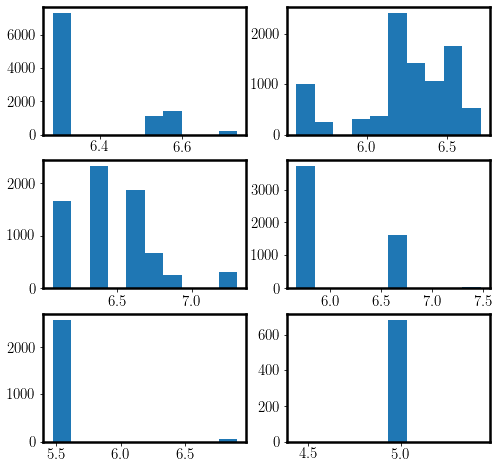

In [100]:
plt.figure(figsize=(8,8))
plt.subplot(321)
plt.hist(np.log10(mh1))
plt.subplot(3,2,2)
plt.hist(np.log10(mh2))
plt.subplot(3,2,3)
plt.hist(np.log10(mh3))
plt.subplot(3,2,4)
plt.hist(np.log10(mh4))
plt.subplot(3,2,5)
plt.hist(np.log10(mh5))
plt.subplot(3,2,6)
plt.hist(np.log10(mh6))

In [101]:
bin=[]
for i in np.arange(8.0,9.0, 0.1):
    bin.append(round(i-0.25,3))
    bin.append(round(i+0.25, 3))
    print(round(i,3), round(i-0.25,3), round(i+0.25, 3))
    
print(np.size(bin))

8.0 7.75 8.25
8.1 7.85 8.35
8.2 7.95 8.45
8.3 8.05 8.55
8.4 8.15 8.65
8.5 8.25 8.75
8.6 8.35 8.85
8.7 8.45 8.95
8.8 8.55 9.05
8.9 8.65 9.15
20


# Plot the "box" plot - Omega(H2)

# Luminocity function

/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log10


AttributeError: 'list' object has no attribute 'Rectangle'

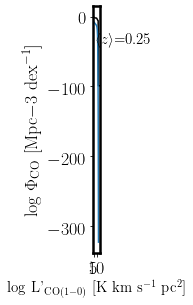

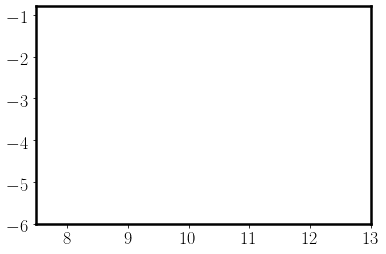

In [102]:

def Lprime(L):
	vco10 = 115.27
	
	return np.log10(10**L/3.e-11 / vco10**3 * 1.04e-3)

mpl.rc ('xtick',labelsize=18)
mpl.rc ('ytick',labelsize=18)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

yellow='#ffdb00'
red='ff2500'
color_almacal='#d11141'
color_aspecs='#00aedb'
color_coldz='#ffc425'

luminosity_bins = np.arange(8,13,1)
z_bins = np.array([0,0.5,0.9,2.0,3.,4.])
LFa1, LFa2, LFa3, LFa4, LFa5, LFa6=np.load("LF_1.npy"),np.load("LF_2.npy"),np.load("LF_3.npy"),np.load("LF_4.npy"),np.load("LF_5.npy"),np.load("LF_6.npy")
LFa1err, LFa2err, LFa3err, LFa4err, LFa5err,LFa6err=np.load("LF_err_1.npy"),np.load("LF_err_2.npy"),np.load("LF_err_3.npy"),np.load("LF_err_4.npy"),np.load("LF_err_5.npy"),np.load("LF_err_6.npy")
MH1, MH2, MH3, MH4, MH5, MH6=np.load("MH2_1.npy"),np.load("MH2_2.npy"),np.load("MH2_3.npy"),np.load("MH2_4.npy"),np.load("MH2_5.npy"),np.load("MH2_6.npy")
MH1err, MH2err, MH3err, MH4err, MH5err,MH6err=np.load("MH2_err_1.npy"),np.load("MH2_err_2.npy"),np.load("MH2_err_3.npy"),np.load("MH2_err_4.npy"),np.load("MH2_err_5.npy"),np.load("MH2_err_6.npy")

#print(LFa4err)

fig=plt.figure(1, figsize=(12,10))

 
def lum2mh2(x):
	return np.log10(alpha *10** x)
def mh22lum(x):
	return np.log10(10**x/alpha)

## ASPECS LF-CObin=[]
aspecs_l_z1 = [] #0 - 0.37
for i in np.arange(8.0,9.1, 0.1):
    aspecs_l_z1.append(round(i-0.25,3))
    #aspecs_l_z1.append(round(i+0.25, 3))


aspecs_lum_1s_z1 = np.array([[-2.86,-1.72],[-2.86,-1.72],[-2.64,-1.65],[-3.88,-1.79],[-3.88,-1.79],[-3.16,-1.81],[-3.15,-1.81],[-3.65,-1.91],[-3.65,-1.91],[-3.65,-1.91],[-5.52,-1.97]])
aspecs_lum_2s_z1 = np.array([[-3.48,-1.48],[-3.48,-1.48],[-3.17,-1.43],[-4.75,-1.51],[-4.75,-1.51],[-3.79,-1.55],[-3.78,-1.55],[-4.23,-1.61],[-4.23,-1.61],[-4.23,-1.61],[-6.39,-1.65]])


aspecs_l_z2 = []  # 1 - 1.7
for i in np.arange(9.5,11, 0.1):
    aspecs_l_z2.append(round(i-0.25,3))
    #aspecs_l_z2.append(round(i+0.25, 3))
aspecs_lum_1s_z2 = np.array([[-2.66,-2.40],[-2.56,-2.32],[-2.57,-2.33],[-2.60,-2.35],[-2.71,-2.42],[-2.94,-2.57],[-3.20,-2.72],[-3.31,-2.77],[-3.42,-2.82],[-3.55,-2.88],[-3.74,-2.94],[-3.91,-3.01],[-4.44,-3.20],[-5.71,-3.34],[-6.78,-3.35]])
aspecs_lum_2s_z2 = np.array([[-2.79,-2.30],[-2.68,-2.23],[-2.69,-2.23],[-2.72,-2.25],[-2.85,-2.32],[-3.12,-2.44],[-3.46,-2.56],[-3.60,-2.61],[-3.75,-2.65],[-3.94,-2.69],[-4.22,-2.74],[-4.43,-2.79],[-5.00,-2.93], [-6.54,-3.03],[-7.65,-3.04]])

aspecs_l_z3 = np.arange(10,11.0, 0.1) # 1 - 1.7
aspecs_lum_1s_z3 = np.array([[-3.99, -3.23],[-3.97,-3.22],[-3.96,-3.21],[-3.90, -3.18],[-4.07, -3.24],[-4.29,-3.30],[-4.15,-3.26],[-4.01,-3.21],[-3.96,-3.19],[-4.01,-3.20]])
aspecs_lum_2s_z3 = np.array([[-4.36,-3.02],[-4.33,-3.02],[-4.32,-3.01],[-4.26,-2.99],[-4.50,-3.03],[-4.81,-3.08],[-4.65,-3.05],[-4.46,-3.01],[-4.40,-3.00],[-4.48,-3.01]])

aspecs_l_z4 = np.arange(10.1,11.1, 0.1) # 1 - 1.7
aspecs_lum_1s_z4 = np.array([[-3.58, -3.10],[-3.52,-3.07],[-3.55,-3.08],[-3.63, -3.13],[-3.80, -3.22],[-4.01,-3.33],[-4.27,-3.43],[-4.63,-3.54],[-5.24,-3.64],[-5.86,-3.69]])
aspecs_lum_2s_z4 = np.array([[-3.79,-2.94],[-3.73,-2.92],[-3.76,-2.93],[-3.85,-2.97],[-4.03,-3.04],[-4.23,-3.12],[-4.49,-3.20],[-4.85,-3.28],[-5.50,-3.35],[-6.11,-3.38]])

coldz_l = []
for i in np.arange(9.5,11.1, 0.1):
    coldz_l.append(round(i-0.25,3))
coldz_lum=np.array([[-4.04,-2.21],[-4.08, -2.69], [-4.14,-2.95],[-4.19,-3.12], [-4.23, -3.24],[-4.10,-3.32],[-4.07, -3.41], [-3.76,-3.37], [-3.69, -3.39], [-3.73, -3.45], [-3.98, -3.60],  [-4.10, -3.70],[ -4.79, -4.11],[ -5.00, -4.25], [-5.44,-4.41],[-6.28,-4.45]])

#LAgos Lum func Shark
shark0 = np.loadtxt("Shark-Lagos19-COLFs_0.txt", usecols=(0,1))

shark05 = np.loadtxt("Shark-Lagos19-COLFs_0.5.txt", usecols=(0,1))
shark1 = np.loadtxt("Shark-Lagos19-COLFs_1.txt", usecols=(0,1))
shark15 = np.loadtxt("Shark-Lagos19-COLFs_1.5.txt", usecols=(0,1))
shark2 = np.loadtxt("Shark-Lagos19-COLFs_2.txt", usecols=(0,1))
shark3 = np.loadtxt("Shark-Lagos19-COLFs_3.txt", usecols=(0,1))

#Fletched+20 LF


def schechter(L,alpha, Lstar, phistar):
    phi = phistar * (L/Lstar)**alpha * np.exp(-L/Lstar)/Lstar
    return phi


fig3 = plt.figure(3)
L =np.linspace(5,13,10000)
Lpime = L/115.27**3 /(3*10**(-11))
Lstar = 10**9.26 /115.27**3 /(3*10**(-11))
#plt.plot(Lpime, np.log10(schechter(10**Lpime,-1.27,Lstar,1.37e-3)))
plt.xlim([7.5,13])
plt.ylim([-6,-0.8])

con_fact = 3.25e7/115.2712**2/(4*np.pi)

for lu,j,luer in zip([LFa1,LFa2,LFa3,LFa4,LFa5], range(5), [LFa1err,LFa2err,LFa3err,LFa4err,LFa5err]):
    ax = fig.add_subplot(2,3,j+1, aspect='equal')

    X,Y=np.array([]),np.array([])


    ax.set_xlabel(r"log L'$_{\rm CO(1-0)}$ [K km s$^{\rm -1}$ pc$^{2}$]", fontsize=15)
    if j==0:
        ax.set_ylabel(r"log $\Phi_{\rm CO}$ [Mpc${\rm-3}$ dex$^{-1}$]", fontsize=18)
        aspecs_lum_2s,aspecs_lum_1s, aspecs_l =aspecs_lum_2s_z1, aspecs_lum_1s_z1,aspecs_l_z1
        ax.annotate(r"$\langle z \rangle$=0.25", (0.4,0.85), xycoords='axes fraction', fontsize=15)
        ax.plot(shark0.T[0]+ np.log10(con_fact), shark0.T[1], ls='-', c='k')
        ax.plot(L, np.log10(schechter(10**L,-1.27,10**9.26,1.37e-3)))
        rect_J8 = patches.Rectangle((8,np.log10(0.005719928063504849)),1,np.log10(abs(0.00248601-0.01116625)),linewidth=3,facecolor='none', hatch='\\\\\\\\', edgecolor=color_almacal,alpha=0.8, label='ALMACAL-lowestJ') #2 sigma
        ax.add_patch(rect_J8)
        rect_J7 = patches.Rectangle((7,np.log10(0.005719928063504849)),1,np.log10(abs(0.00248601-0.01116625)),linewidth=3,facecolor='none', hatch='\\\\\\\\', edgecolor=color_almacal,alpha=0.8, label='ALMACAL-lowestJ') #2 sigma
        ax.add_patch(rect_J7)

    elif j ==1:
        ax.annotate(r"$\langle z \rangle$=0.75", (0.4,0.85), xycoords='axes fraction', fontsize=15)
        ax2=ax

        ax.plot(shark1.T[0]+ np.log10(con_fact), shark1.T[1], ls='-', c='k')

    elif j==2: 
        aspecs_lum_2s,aspecs_lum_1s,aspecs_l =aspecs_lum_2s_z2, aspecs_lum_1s_z2,aspecs_l_z2
        ax.annotate(r"$\langle z \rangle$=1.25", (0.4,0.85), xycoords='axes fraction', fontsize=15)
        ax.plot(shark15.T[0]+ np.log10(con_fact), shark15.T[1], ls='-', c='k')

    elif j==3: 
        ax3=ax
        ax.annotate(r"$\langle z \rangle$=1.75", (0.4,0.85), xycoords='axes fraction', fontsize=15)
        ax.set_ylabel(r"log $\Phi_{\rm CO}$ [Mpc${\rm-3}$ dex$^{-1}$]", fontsize=18)



        lagos,=ax.plot(shark2.T[0]+ np.log10(con_fact), shark2.T[1], ls='-', c='k', label='Shark')
        aspecs_lum_2s,aspecs_lum_1s,aspecs_l =aspecs_lum_2s_z3, aspecs_lum_1s_z3, aspecs_l_z3
        for i in range(np.size(coldz_l)):
            rect2cs = patches.Rectangle((coldz_l[i],coldz_lum[i][0]),0.5,np.abs(coldz_lum[i][0]-coldz_lum[i][1]),linewidth=3,facecolor=color_coldz, edgecolor=color_coldz,alpha=0.4, label='COLDz') #2 sigma

            ax.add_patch(rect2cs)


    elif j==4: 
        ax.annotate(r"$\langle z \rangle$=2.5", (0.4,0.85), xycoords='axes fraction', fontsize=15)
        #ax.set_ylabel(r"log $\Phi_{\rm CO}$ [Mpc${\rm-3}$ dex$^{-1}$]", fontsize=18)


        ax.plot(shark3.T[0]+ np.log10(con_fact), shark3.T[1], ls='-', c='k')
        aspecs_lum_2s,aspecs_lum_1s,aspecs_l =aspecs_lum_2s_z4, aspecs_lum_1s_z4, aspecs_l_z4

    ## aspecs
    if j !=1:
        for i in range(np.size(aspecs_l)-1):
            rect2s = patches.Rectangle((aspecs_l[i],aspecs_lum_2s[i][0]),0.5,np.abs(aspecs_lum_2s[i][0]-aspecs_lum_2s[i][1]),linewidth=3,facecolor=color_aspecs,edgecolor=color_aspecs, alpha=0.4, label='ASPECS') #2 sigma
            rect1s = patches.Rectangle((aspecs_l[i],aspecs_lum_1s[i][0]),0.5,np.abs(aspecs_lum_1s[i][0]-aspecs_lum_1s[i][1]),linewidth=1,facecolor=color_aspecs, alpha=0.4 ) #2 sigma
            ax.add_patch(rect1s)
            #ax.add_patch(rect1s)
  
        
    for i in range(4):
        X = np.append(X,np.mean([luminosity_bins[i], luminosity_bins[i+1]]))
        Y=np.append(Y,np.log10(np.mean(lu.T[i])))
        #print(np.size(lu.T[i]))
        err1l,err1u = np.log10(np.mean(luer[0][i])),np.log10(np.mean(luer[3][i]))
        err2l,err2u= np.log10(np.mean(luer[1][i])),np.log10(np.mean(luer[4][i]))
        err3l,err3u = np.log10(np.mean(luer[2][i])),np.log10(np.mean(luer[5][i]))
        #print(err1u,err1l)
        #plt.plot(X,Y, 'o', c='#99197f')
        #rect3 = patches.Rectangle((luminosity_bins[i],err1l),1,err1u-err1l,linewidth=1,edgecolor='r',facecolor='none')
        #ax.add_patch(rect3)
        rect2 = patches.Rectangle((luminosity_bins[i],err2l),1,err2u-err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.8, label='ALMACAL-CO') #2 sigma
        ax.add_patch(rect2)
        #rect1 = patches.Rectangle((luminosity_bins[i],err3l),1,err3u-err3l,linewidth=1,facecolor=color_almacal, alpha=0.4) #1 sigma
        #ax.add_patch(rect1)


    ax.set_xlim([7.5,12.2])
    ax.set_ylim([-6,-0.8])	
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.xaxis.set_minor_locator(ticker.MaxNLocator(10))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
    ax.yaxis.set_minor_locator(ticker.MaxNLocator(12))
    ax.tick_params(which='both',direction='in')
    #secax=ax.secondary_xaxis("top", functions=(lum2mh2,mh22lum))
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    #secax.set_xlabel(r"log M$_{\rm H2}$ [M$_{\odot}$]", fontsize=15)
    # secax.xaxis.set_minor_locator(ticker.MaxNLocator(10))
    # secax.tick_params(which='both',direction='in')
    # # secaxy.tick_params(direction='in')
ax6 = fig.add_subplot(2,3,6, aspect='equal')
ax6.legend(handles=[rect2,rect_J8,rect2cs,rect2s,lagos], loc=3, fontsize=13)
#ax6.legend(handles=[lagos], loc=3, fontsize=11)
ax6.axis('off')

plt.tight_layout()
fig.savefig("COlum.png")
# fig2= plt.figure(2,figsize=(6,6))
# ax2=fig2.add_subplot(111)
# for i in range(4):
# 		X = np.append(X,np.mean([luminosity_bins[i], luminosity_bins[i+1]]))
# 		Y1err2l,Y1err2u= np.log10(np.mean(LFa1err[1][i])),np.log10(np.mean(LFa1err[4][i]))
# 		Y2err2l,Y2err2u= np.log10(np.mean(LFa2err[1][i])),np.log10(np.mean(LFa2err[4][i]))
# 		Y3err2l,Y3err2u= np.log10(np.mean(LFa3err[1][i])),np.log10(np.mean(LFa3err[4][i]))
# 		Y4err2l,Y4err2u= np.log10(np.mean(LFa4err[1][i])),np.log10(np.mean(LFa4err[4][i]))
# 		Y5err2l,Y5err2u= np.log10(np.mean(LFa5err[1][i])),np.log10(np.mean(LFa5err[4][i]))

# 		#plt.plot(X,Y, 'o', c='#99197f')
# 		#rect3 = patches.Rectangle((luminosity_bins[i],err1l),1,err1u-err1l,linewidth=1,edgecolor='r',facecolor='none')
# 		#ax.add_patch(rect3)
# 		rect1 = patches.Rectangle((luminosity_bins[i],Y1err2l),1,Y1err2u-Y1err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.8, label='ALMACAL-CO') #2 sigma
# 		rect2 = patches.Rectangle((luminosity_bins[i],Y2err2l),1,Y2err2u-Y2err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.8, label='ALMACAL-CO') #2 sigma
# 		rect3 = patches.Rectangle((luminosity_bins[i],Y3err2l),1,Y3err2u-Y3err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.8, label='ALMACAL-CO') #2 sigma
# 		rect4 = patches.Rectangle((luminosity_bins[i],Y4err2l),1,Y4err2u-Y4err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.8, label='ALMACAL-CO') #2 sigma
# 		rect5 = patches.Rectangle((luminosity_bins[i],Y5err2l),1,Y5err2u-Y5err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.8, label='ALMACAL-CO') #2 sigma

# 		ax2.add_patch(rect1)
# 		ax2.add_patch(rect2)
# 		ax2.add_patch(rect3)
# 		ax2.add_patch(rect4)
# 		ax2.add_patch(rect5)
# 		#rect1 = patches.Rectangle((luminosity_bins[i],err3l),1,err3u-err3l,linewidth=1,facecolor=color_almacal, alpha=0.4) #1 sigma
# 		#ax.add_patch(rect1)

# plt.show()


[0.25] 5.64883 5.77637 7.03641 6.88132
(10000,) (9120,) (7073,) (5355,) (2629,)


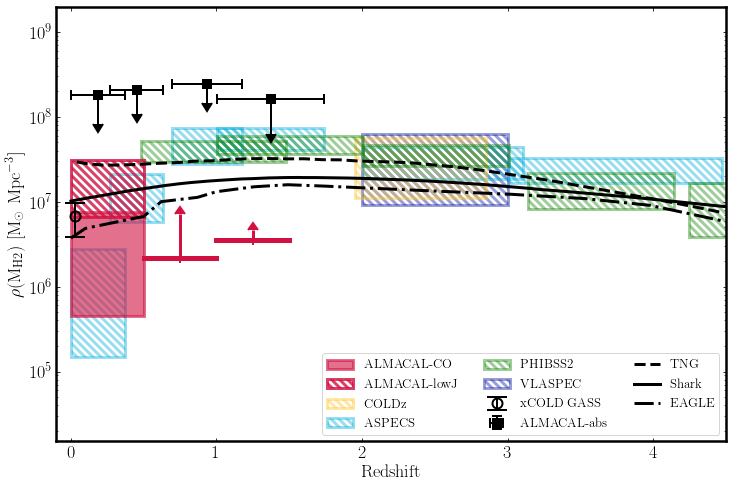

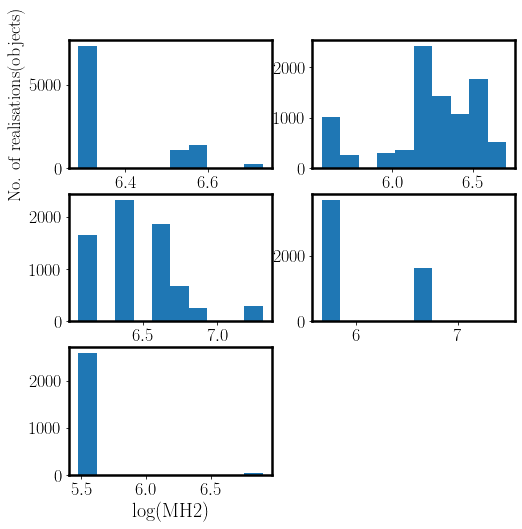

In [104]:

import matplotlib.patches as patches
rho_c = 1.274e11
mpl.rc ('xtick',labelsize=18)
mpl.rc ('ytick',labelsize=18)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

yellow='#ffdb00'
red='ff2500'
color_almacal='#d11141'
color_aspecs='#00aedb'
color_coldz='#ffc425'
color_phibss='#0f8400'
alpha = 4.3
luminosity_bins = np.arange(8,13,1)
z_bins = np.array([0,0.5,1.0,1.5,2.0,3.,4.])
LFa1, LFa2, LFa3, LFa4, LFa5=np.load("LF_1.npy"),np.load("LF_2.npy"),np.load("LF_3.npy"),np.load("LF_4.npy"),np.load("LF_5.npy")
LFa1err, LFa2err, LFa3err, LFa4err, LFa5err=np.load("LF_err_1.npy"),np.load("LF_err_2.npy"),np.load("LF_err_3.npy"),np.load("LF_err_4.npy"),np.load("LF_err_5.npy")
MH1, MH2, MH3, MH4, MH5=np.load("MH2_1.npy"),np.load("MH2_2.npy"),np.load("MH2_3.npy"),np.load("MH2_4.npy"),np.load("MH2_5.npy")
MH1err, MH2err, MH3err, MH4err, MH5err=np.load("MH2_err_1.npy"),np.load("MH2_err_2.npy"),np.load("MH2_err_3.npy"),np.load("MH2_err_4.npy"),np.load("MH2_err_5.npy")

# sim
TNG19 = np.loadtxt("Popping2019H2.txt")
shark = np.loadtxt("Mh2_shark.txt")
EAGLE = np.loadtxt("mh2_eagle.txt")

AnneAbs =np.array([[np.mean([0.003,0.369]),np.mean([0.2713,0.6306]), np.mean([0.6950,1.1744]), np.mean([1.006,1.738])],[10**8.26, 10**8.32,10**8.39,10**8.21]])
AnneAbs_zerr = np.array([0.369-0.003,0.6306-0.2713,1.1744-0.6950,1.738-1.006])/2.


fig2 = plt.figure(2, figsize=(12,8))

ax2 = plt.axes(yscale='log')

X2,Y2 = np.array([]),np.array([])

Y2=[np.mean(MH1),np.mean(MH2),np.mean(MH3),np.mean(MH4),np.mean(MH5)]

ax2.set_ylabel(r" $\rho$(M$_{\rm H2}$) [M$_{\odot}$ Mpc$^{\rm -3}$]", fontsize=18)
ax2.set_xlabel("Redshift", fontsize=18)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.set_ylim([1.5*10**4,2*10**9])
ax2.set_xlim([-0.1, 4.5])

#VLASpec
z_vla = [[2.0,3.0]]
MH_vla = [[10**6.96, 10**7.80]]
for z, mh in zip(z_vla,MH_vla):
    rect_vla = patches.Rectangle((z[0],mh[0]),z[1]-z[0],abs(mh[1]-mh[0]),linewidth=3,facecolor='none',hatch="\\\\\\", edgecolor='#000f9e',alpha=0.4,label="VLASPEC") #2 sigma
    ax2.add_patch(rect_vla)
        
## aspecs
Zerr_as=[[0.003,0.369],[0.271,0.631], [0.695,1.174] ,[1.006,1.738],[2.008,3.107], [3.011, 4.475]]
#1 sigma
MH_err_as1=[[0.015,0.281],[0.572,2.148], [2.772,7.371],[4.053,7.489], [1.844,4.438],[1.686,3.289 ]]
MH_err_as2=[[5.40,7.01],[6.56,7.76], [6.83,7.73],[7.63,8.05],[7.26,8.10],[6.97,7.77 ]] #not updated
for z, mh1,mh2 in zip(Zerr_as,MH_err_as1,MH_err_as2):
		#print mh1, mh2
		rect2c = patches.Rectangle((z[0],mh1[0]*1e7),z[1]-z[0],abs(mh1[1]-mh1[0])*1e7,linewidth=3,facecolor='none',hatch="\\\\\\",edgecolor=color_aspecs, alpha=.4, label="ASPECS") #2 sigma
		ax2.add_patch(rect2c)
		#rect1 = patches.Rectangle((z[0],10**mh2[0]),z[1]-z[0],abs(10**mh2[1]-10**mh2[0]),linewidth=1,facecolor=color_aspecs, alpha=0.15 ) #1 sigma
		#ax2.add_patch(rect1)
# 		rect3 = patches.Rectangle((z_bins[i],err1l),z_bins[i+1]-z_bins[i],err1u-err1l,linewidth=1,edgecolor='b',facecolor='none') #1 sigma
# 		ax2.add_patch(rect3)
### cold-z

zerr_cz = [[1.95,2.85], [4.90, 6.70]]
MH_err_cz = [[1.1e7,5.6e7], [0.14e7, 1.1e7]]
for z, mh in zip(zerr_cz,MH_err_cz):
		rect2cs = patches.Rectangle((z[0],mh[0]),z[1]-z[0],abs(mh[1]-mh[0]),linewidth=3,facecolor='none',hatch="\\\\\\", edgecolor=color_coldz,alpha=0.4,label="COLDz") #2 sigma
		ax2.add_patch(rect2cs)


#PHIBBS-2
z_ph = [[0.4799,1.4799], [1.0056,2.0056], [2.0084, 3.0084], [3.1404, 4.1404], [4.2451,5.2451]]
mh_ph = [[7.47,7.72], [7.56,7.78],[7.42,7.67],[6.91,7.34],[6.58,7.22]]
for z, mh in zip(z_ph,mh_ph):

    rect_ph = patches.Rectangle((z[0],10**mh[0]),z[1]-z[0],abs(10**mh[1]-10**mh[0]),linewidth=3,facecolor='none',hatch="\\\\\\", edgecolor=color_phibss,alpha=0.4,label="PHIBSS2") #2 sigma
    ax2.add_patch(rect_ph) 
    
popping19,=ax2.plot(TNG19.T[0], 10**TNG19.T[1], ls='--', c='k', lw=3, label='TNG')
shark18,=ax2.plot(shark.T[0], 10**shark.T[1], ls='-', c='k', lw=3, label='Shark')
eagle15_1,=ax2.plot(EAGLE.T[0], EAGLE.T[2], ls='-.', c='k', lw=3, label='EAGLE')
#eagle15_2,=ax2.plot(EAGLE.T[0], EAGLE.T[2], ls='-.', c='k', lw=2, label='Lagos+15 EAGLE')
#plt.plot([0.25,0.75,1.5,2.5,3.5],[10**9.05, 10**8.41, 10**7.83, 10**7.26, 10**7.35], 'kx')

#Diemier +19
# print(TNG19[0])
# for i in range(np.size(TNG19.T[0])) :
#     z = TNG19[i][0]
#     rho1 = rho_c* np.min(TNG19[i][1:])
#     rho2 = rho_c* np.max(TNG19[i][1:])
    
#     plt.plot(z,rho1, "ro")
#     plt.plot(z,rho2, "go")
### xCOLDvGASS Saintonge
MH2_s = 1.1e7 #Saintonge
MH2_f=5.34e-5 * rho_c #Fletcher
#er=plt.errorbar(0.03, MH2_s, yerr=[[5.0e6],[0.8e7]], fmt='o',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="Saintonge+17", capsize=10, capthick=2)
er=plt.errorbar(0.03, MH2_f, yerr=[[3e6],[3e6]], fmt='o',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="xCOLD GASS", capsize=10, capthick=2)

#Andreani
MH2_a=1.5e7
#erpa=plt.errorbar(0.03, MH2_a, yerr=[[.6e7],[0.6e7]], fmt='s',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="HRS", capsize=10, capthick=2)


# plt.errorbar(zaspecs,MH_aspecs2, xerr=Zerr_as, yerr=MH_err_as2)
# plt.errorbar(zaspecs,MH_aspecs1, xerr=Zerr_as, yerr=MH_err_as1)

#ALMACAL

for i, mherr in zip(range(1), [MH1err]):#, MH2err,MH3err]):
    X2 = np.append(X2,np.mean([z_bins[i], z_bins[i+1]]))
    err1l,err1u = np.mean(mherr[0]),np.mean(mherr[3])
    err2l,err2u= np.mean(mherr[1]),np.mean(mherr[4])
    err3l,err3u = np.mean(mherr[2]),np.mean(mherr[5])

rect2 = patches.Rectangle((z_bins[i],err2l),z_bins[i+1]-z_bins[i],err2u-err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.6,label="ALMACAL-CO") #2 sigma
ax2.add_patch(rect2)
#rect1 = patches.Rectangle((z_bins[i],err3l),z_bins[i+1]-z_bins[i],err3u-err3l,linewidth=1,facecolor=color_almacal, alpha=0.4) #1 sigma
#ax2.add_patch(rect1)
# rect3 = patches.Rectangle((z_bins[i],err1l),z_bins[i+1]-z_bins[i],err1u-err1l,linewidth=1,edgecolor='k',facecolor='none') #1 sigma
# ax2.add_patch(rect3)
print(X2, round(np.log10(err2l),5),round(np.log10(err3l),5), round(np.log10(err3u),5),round(np.log10(err2u),5))

plt.plot([.5,1.0], [np.mean(MH2),np.mean(MH2)],lw=5, c=color_almacal)
plt.plot([1.0,1.5], [np.mean(MH3),np.mean(MH3)],lw=5, c=color_almacal)
plt.errorbar(0.75, np.mean(MH2), xerr=0, yerr=.5e7, lolims=True,color=color_almacal,lw=3, capsize=5, capthick=2)
plt.errorbar(1.25, np.mean(MH3), xerr=0, yerr=1e6, lolims=True,color=color_almacal,lw=3, capsize=5, capthick=2)

#era=plt.errorbar(0.25, 10**OH1, xerr=0.25, yerr=1e6, fmt='s',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="Andreani+20", capsize=10, capthick=2)
era = patches.Rectangle((0.,10**OH1), 0.5, 10**7.43 - 10**6.36,linewidth=3,facecolor='none',hatch="\\\\\\", edgecolor=color_almacal,alpha=0.8,label="ALMACAL-lowJ")
ax2.add_patch(era)

ak = plt.errorbar(AnneAbs[0], AnneAbs[1], xerr=AnneAbs_zerr, yerr=[1e8]*4, uplims=True, fmt='s',ms=8,color='k',lw=2, markeredgewidth=2,elinewidth=2,markeredgecolor='k',markerfacecolor='k', label="ALMACAL-abs", capsize=5, capthick=2)

ax2.legend(handles=[rect2,era,rect2cs,rect2c, rect_ph, rect_vla,er, ak, popping19, shark18, eagle15_1, ], loc=4, fontsize=13, ncol=3)
ax2.tick_params(which='both',direction='in')
#ax2.grid()
fig2.savefig("MH2_z.png")
fig = plt.figure(3, figsize=(8,8))
print(np.shape(MH1),np.shape(MH2),np.shape(MH3),np.shape(MH4),np.shape(MH5))
plt.subplot(321)
plt.hist(np.log10(MH1))
plt.ylabel("No. of realisations(objects)", fontsize=18)
plt.subplot(322)
plt.hist(np.log10(MH2))
plt.subplot(323)
plt.hist(np.log10(MH3))
plt.subplot(324)
plt.hist(np.log10(MH4))
plt.subplot(325)
plt.hist(np.log10(MH5))
plt.xlabel("log(MH2)", fontsize=20)
fig.savefig("bins.png")
plt.show()


# Referee comments

## binning the spectra

In [9]:
pb_corr=np.array([0.4468, 0.2997, 0.3575, 0.3484, 0.355, 0.636])
from astropy.convolution import Gaussian1DKernel, convolve
import specutils.manipulation as spma
from scipy.signal import resample

In [10]:
from pysynphot import observation
from pysynphot import spectrum
 
def rebin_spec(wave, specin, wavnew):
    spec = spectrum.ArraySourceSpectrum(wave=wave, flux=specin)
    f = np.ones(len(wave))
    filt = spectrum.ArraySpectralElement(wave, f, waveunits='angstrom')
    obs = observation.Observation(spec, filt, binset=wavnew, force='taper')
 
    return obs.binflux

/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


J2357-5311.txt


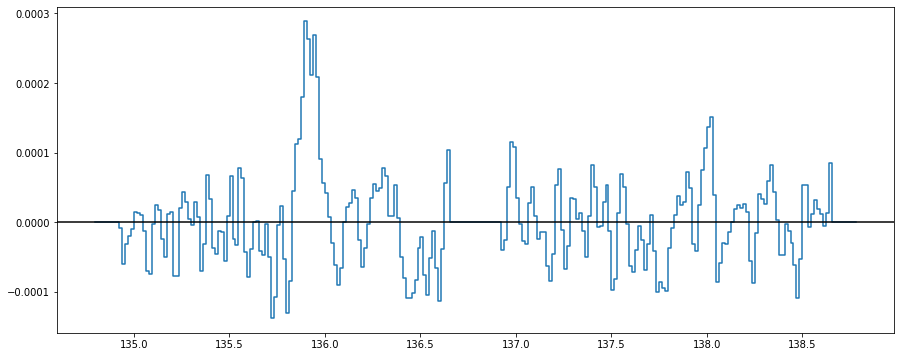

In [101]:
path="/Users/ahamanow/Desktop/ALMA/CO_search/ALMA_fields/candidates/"
cubes, clas,spectxt= np.loadtxt('candidates_list.txt', usecols=(1,12,17),dtype='str',comments='#', unpack=True) #edited version for plotting, original can be found under the path
X,Y,Z,Width, SN, w50, f0, rms, intflux = np.loadtxt('candidates_list.txt', usecols=(3,4,5,7,6,11,10,14,12),dtype='float', unpack=True)


i =5
print(spectxt[i])
name=spectxt[i].replace(".txt","")
#aperture spectrum
spec = np.loadtxt("/Users/ahamanow/Desktop/ALMA/almacal-deep-figures/aperture-spectra/"+spectxt[i], comments='#')
f1,f2 = min(f0[i]-.5,f0[i]+.5), max(f0[i]-.5,f0[i]+.5) #freq_from_vel(f0[i], -vel_lim),freq_from_vel(f0[i], vel_lim)

## spectrum stats
plt.figure(figsize=(15,6))
flux = spec.T[1]*pb_corr[i]



plt.step(spec.T[0], flux)
#plt.xlim([f1,f2])
plt.axhline(0, c='k')

In [106]:
wavnew=np.arange(spec.T[0][-1], spec.T[0][0], 0.0156*2)
print(spec.T[0][0], spec.T[0][-1])
newflux=rebin_spec(wave=spec.T[0], specin=flux+1, wavnew=wavnew)

138.7819213867 134.7975463867


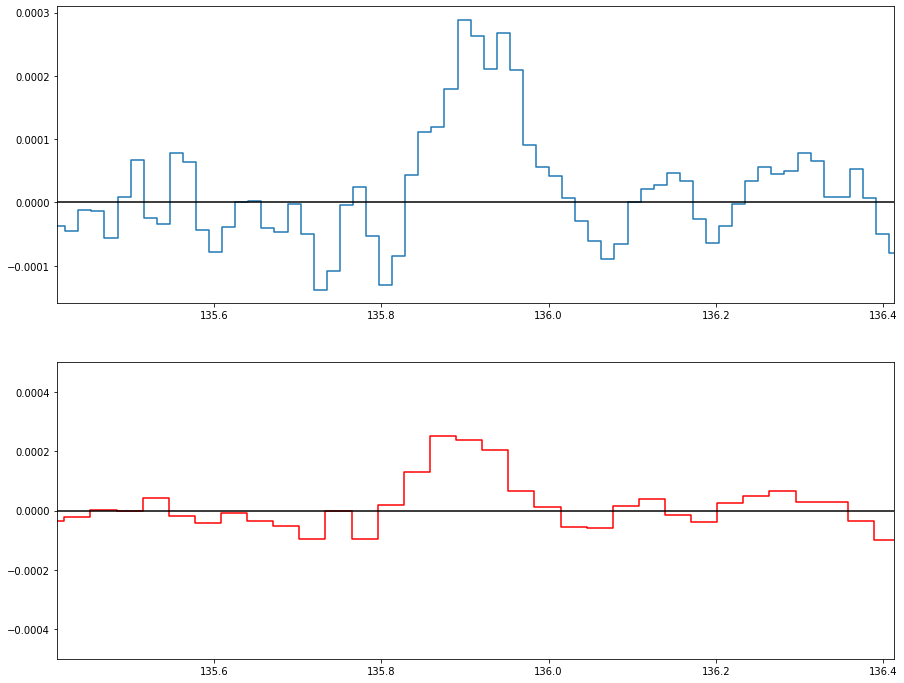

In [107]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
plt.step(spec.T[0], flux)


plt.xlim([f1,f2])
plt.axhline(0, c='k')
plt.subplot(212)
plt.step(wavnew,newflux-1, c='r')
plt.ylim([-0.0005, 0.0005])
plt.xlim([f1,f2])
plt.axhline(0, c='k')
fig.savefig("rebin-"+name+".png")

## pb correction

In [116]:
pb_corr=np.array([0.4468, 0.2997, 0.3575, 0.3484, 0.355, 0.636])
delta_r = ([9.10,11.13,11.11,10.51,15.66,18.20])
fov = np.array([18, 18,18,18,27,44])

In [117]:
pb_corr/delta_r
delta_r/fov

array([0.50555556, 0.61833333, 0.61722222, 0.58388889, 0.58      ,
       0.41363636])

[0.25] 5.92376 5.89947 7.0856 6.94157
[0.25 0.75] 6.99481 6.86007 7.60187 7.50784
[0.25 0.75 1.25] 6.82946 6.67581 7.52643 7.42298


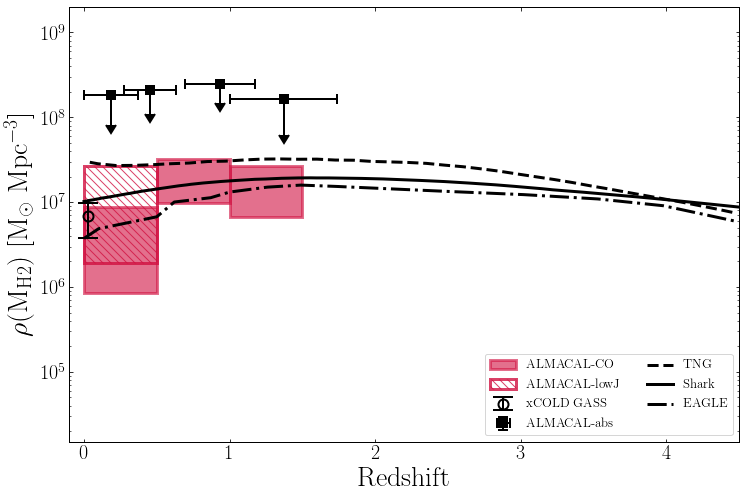

In [50]:
### omage(H2) for MEssenger\rho_c = 1.274e11
mpl.rc ('xtick',labelsize=20)
mpl.rc ('ytick',labelsize=20)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

yellow='#ffdb00'
red='ff2500'
color_almacal='#d11141'
color_aspecs='#00aedb'
color_coldz='#ffc425'
color_phibss='#0f8400'
alpha = 4.3
luminosity_bins = np.arange(8,13,1)
z_bins = np.array([0,0.5,1.0,1.5,2.0,3.,4.])


MH1, MH2, MH3, MH4, MH5=np.load("MH2_1.npy"),np.load("MH2_2.npy"),np.load("MH2_3.npy"),np.load("MH2_4.npy"),np.load("MH2_5.npy")
MH1err, MH2err, MH3err, MH4err, MH5err=np.load("MH2_err_1.npy"),np.load("MH2_err_2.npy"),np.load("MH2_err_3.npy"),np.load("MH2_err_4.npy"),np.load("MH2_err_5.npy")

# sim
TNG19 = np.loadtxt("Popping2019H2.txt")
shark = np.loadtxt("Mh2_shark.txt")
EAGLE = np.loadtxt("mh2_eagle.txt")

AnneAbs =np.array([[np.mean([0.003,0.369]),np.mean([0.2713,0.6306]), np.mean([0.6950,1.1744]), np.mean([1.006,1.738])],[10**8.26, 10**8.32,10**8.39,10**8.21]])
AnneAbs_zerr = np.array([0.369-0.003,0.6306-0.2713,1.1744-0.6950,1.738-1.006])/2.


fig2 = plt.figure(2, figsize=(12,8))

ax2 = plt.axes(yscale='log')

X2,Y2 = np.array([]),np.array([])

Y2=[np.mean(MH1),np.mean(MH2),np.mean(MH3),np.mean(MH4),np.mean(MH5)]

ax2.set_ylabel(r" $\rho$(M$_{\rm H2}$) [M$_{\odot}$ Mpc$^{\rm -3}$]", fontsize=28)
ax2.set_xlabel("Redshift", fontsize=28)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.set_ylim([1.5*10**4,2*10**9])
ax2.set_xlim([-0.1, 4.5])

    
popping19,=ax2.plot(TNG19.T[0], 10**TNG19.T[1], ls='--', c='k', lw=3, label='TNG')
shark18,=ax2.plot(shark.T[0], 10**shark.T[1], ls='-', c='k', lw=3, label='Shark')
eagle15_1,=ax2.plot(EAGLE.T[0], EAGLE.T[2], ls='-.', c='k', lw=3, label='EAGLE')
#eagle15_2,=ax2.plot(EAGLE.T[0], EAGLE.T[2], ls='-.', c='k', lw=2, label='Lagos+15 EAGLE')
#plt.plot([0.25,0.75,1.5,2.5,3.5],[10**9.05, 10**8.41, 10**7.83, 10**7.26, 10**7.35], 'kx')


### xCOLDvGASS Saintonge
MH2_s = 1.1e7 #Saintonge
MH2_f=5.34e-5 * rho_c #Fletcher
#er=plt.errorbar(0.03, MH2_s, yerr=[[5.0e6],[0.8e7]], fmt='o',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="Saintonge+17", capsize=10, capthick=2)
er=plt.errorbar(0.03, MH2_f, yerr=[[3e6],[3e6]], fmt='o',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="xCOLD GASS", capsize=10, capthick=2)

#Andreani
MH2_a=1.5e7
#erpa=plt.errorbar(0.03, MH2_a, yerr=[[.6e7],[0.6e7]], fmt='s',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="HRS", capsize=10, capthick=2)


# plt.errorbar(zaspecs,MH_aspecs2, xerr=Zerr_as, yerr=MH_err_as2)
# plt.errorbar(zaspecs,MH_aspecs1, xerr=Zerr_as, yerr=MH_err_as1)

#ALMACAL

for i, mherr in zip(range(3), [MH1err, MH2err,MH3err]):
		X2 = np.append(X2,np.mean([z_bins[i], z_bins[i+1]]))
		err1l,err1u = np.mean(mherr[0]),np.mean(mherr[3])
		err2l,err2u= np.mean(mherr[1]),np.mean(mherr[4])
		err3l,err3u = np.mean(mherr[2]),np.mean(mherr[5])

		rect2 = patches.Rectangle((z_bins[i],err2l),z_bins[i+1]-z_bins[i],err2u-err2l,linewidth=3,facecolor=color_almacal, edgecolor=color_almacal,alpha=0.6,label="ALMACAL-CO") #2 sigma
		ax2.add_patch(rect2)
		#rect1 = patches.Rectangle((z_bins[i],err3l),z_bins[i+1]-z_bins[i],err3u-err3l,linewidth=1,facecolor=color_almacal, alpha=0.4) #1 sigma
		#ax2.add_patch(rect1)
		# rect3 = patches.Rectangle((z_bins[i],err1l),z_bins[i+1]-z_bins[i],err1u-err1l,linewidth=1,edgecolor='k',facecolor='none') #1 sigma
		# ax2.add_patch(rect3)
		print(X2, round(np.log10(err2l),5),round(np.log10(err3l),5), round(np.log10(err3u),5),round(np.log10(err2u),5))

#era=plt.errorbar(0.25, 10**OH1, xerr=0.25, yerr=1e6, fmt='s',ms=10,markeredgewidth=2,markeredgecolor='k',markerfacecolor='none',lw=2,ecolor='k', elinewidth=2, label="Andreani+20", capsize=10, capthick=2)
era = patches.Rectangle((0.,10**OH1), 0.5, 10**7.43 - 10**6.36,linewidth=3,facecolor='none',hatch="\\\\\\", edgecolor=color_almacal,alpha=0.8,label="ALMACAL-lowJ")
ax2.add_patch(era)

ak = plt.errorbar(AnneAbs[0], AnneAbs[1], xerr=AnneAbs_zerr, yerr=[1e8]*4, uplims=True, fmt='s',ms=8,color='k',lw=2, markeredgewidth=2,elinewidth=2,markeredgecolor='k',markerfacecolor='k', label="ALMACAL-abs", capsize=5, capthick=2)

ax2.legend(handles=[rect2,era, er, ak, popping19, shark18, eagle15_1 ], loc=4, fontsize=13, ncol=2)
ax2.tick_params(which='both',direction='in')
#ax2.grid()
fig2.savefig("MH2_z_all.pdf")



/Users/ahamanow/anaconda2/envs/python3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cset = super().contour(*args, **kwargs)


['J0006-0623.large.mom0.fits' 'J0510+1800.large.mom0.fits'
 'J1924-2914.large.mom0.fits' 'J2356-5311.large.mom0.fits']
['uid___A001_X5ac_X38f.cube_23.J0006-0623_B7'
 'uid___A001_X5ac_X138c.cube_0.J0510+1800_B7'
 'uid___A001_X5ad_X888.cube_12.J1924-2914_B6'
 'uid___A001_X5ad_Xea5.cube_01.J2357-5311_B4'
 'uid___A001_X5ac_X1fe_04.cube_01.J0334-4008_B3'
 'uid___A001_X5ac_X1fe_02.cube_23.J0334-4008_B3']
0.347
(50, 50)
0.416
(124, 76) ()
62 38
(50, 50)
0.4
(50, 50)
0.35
(90, 90)


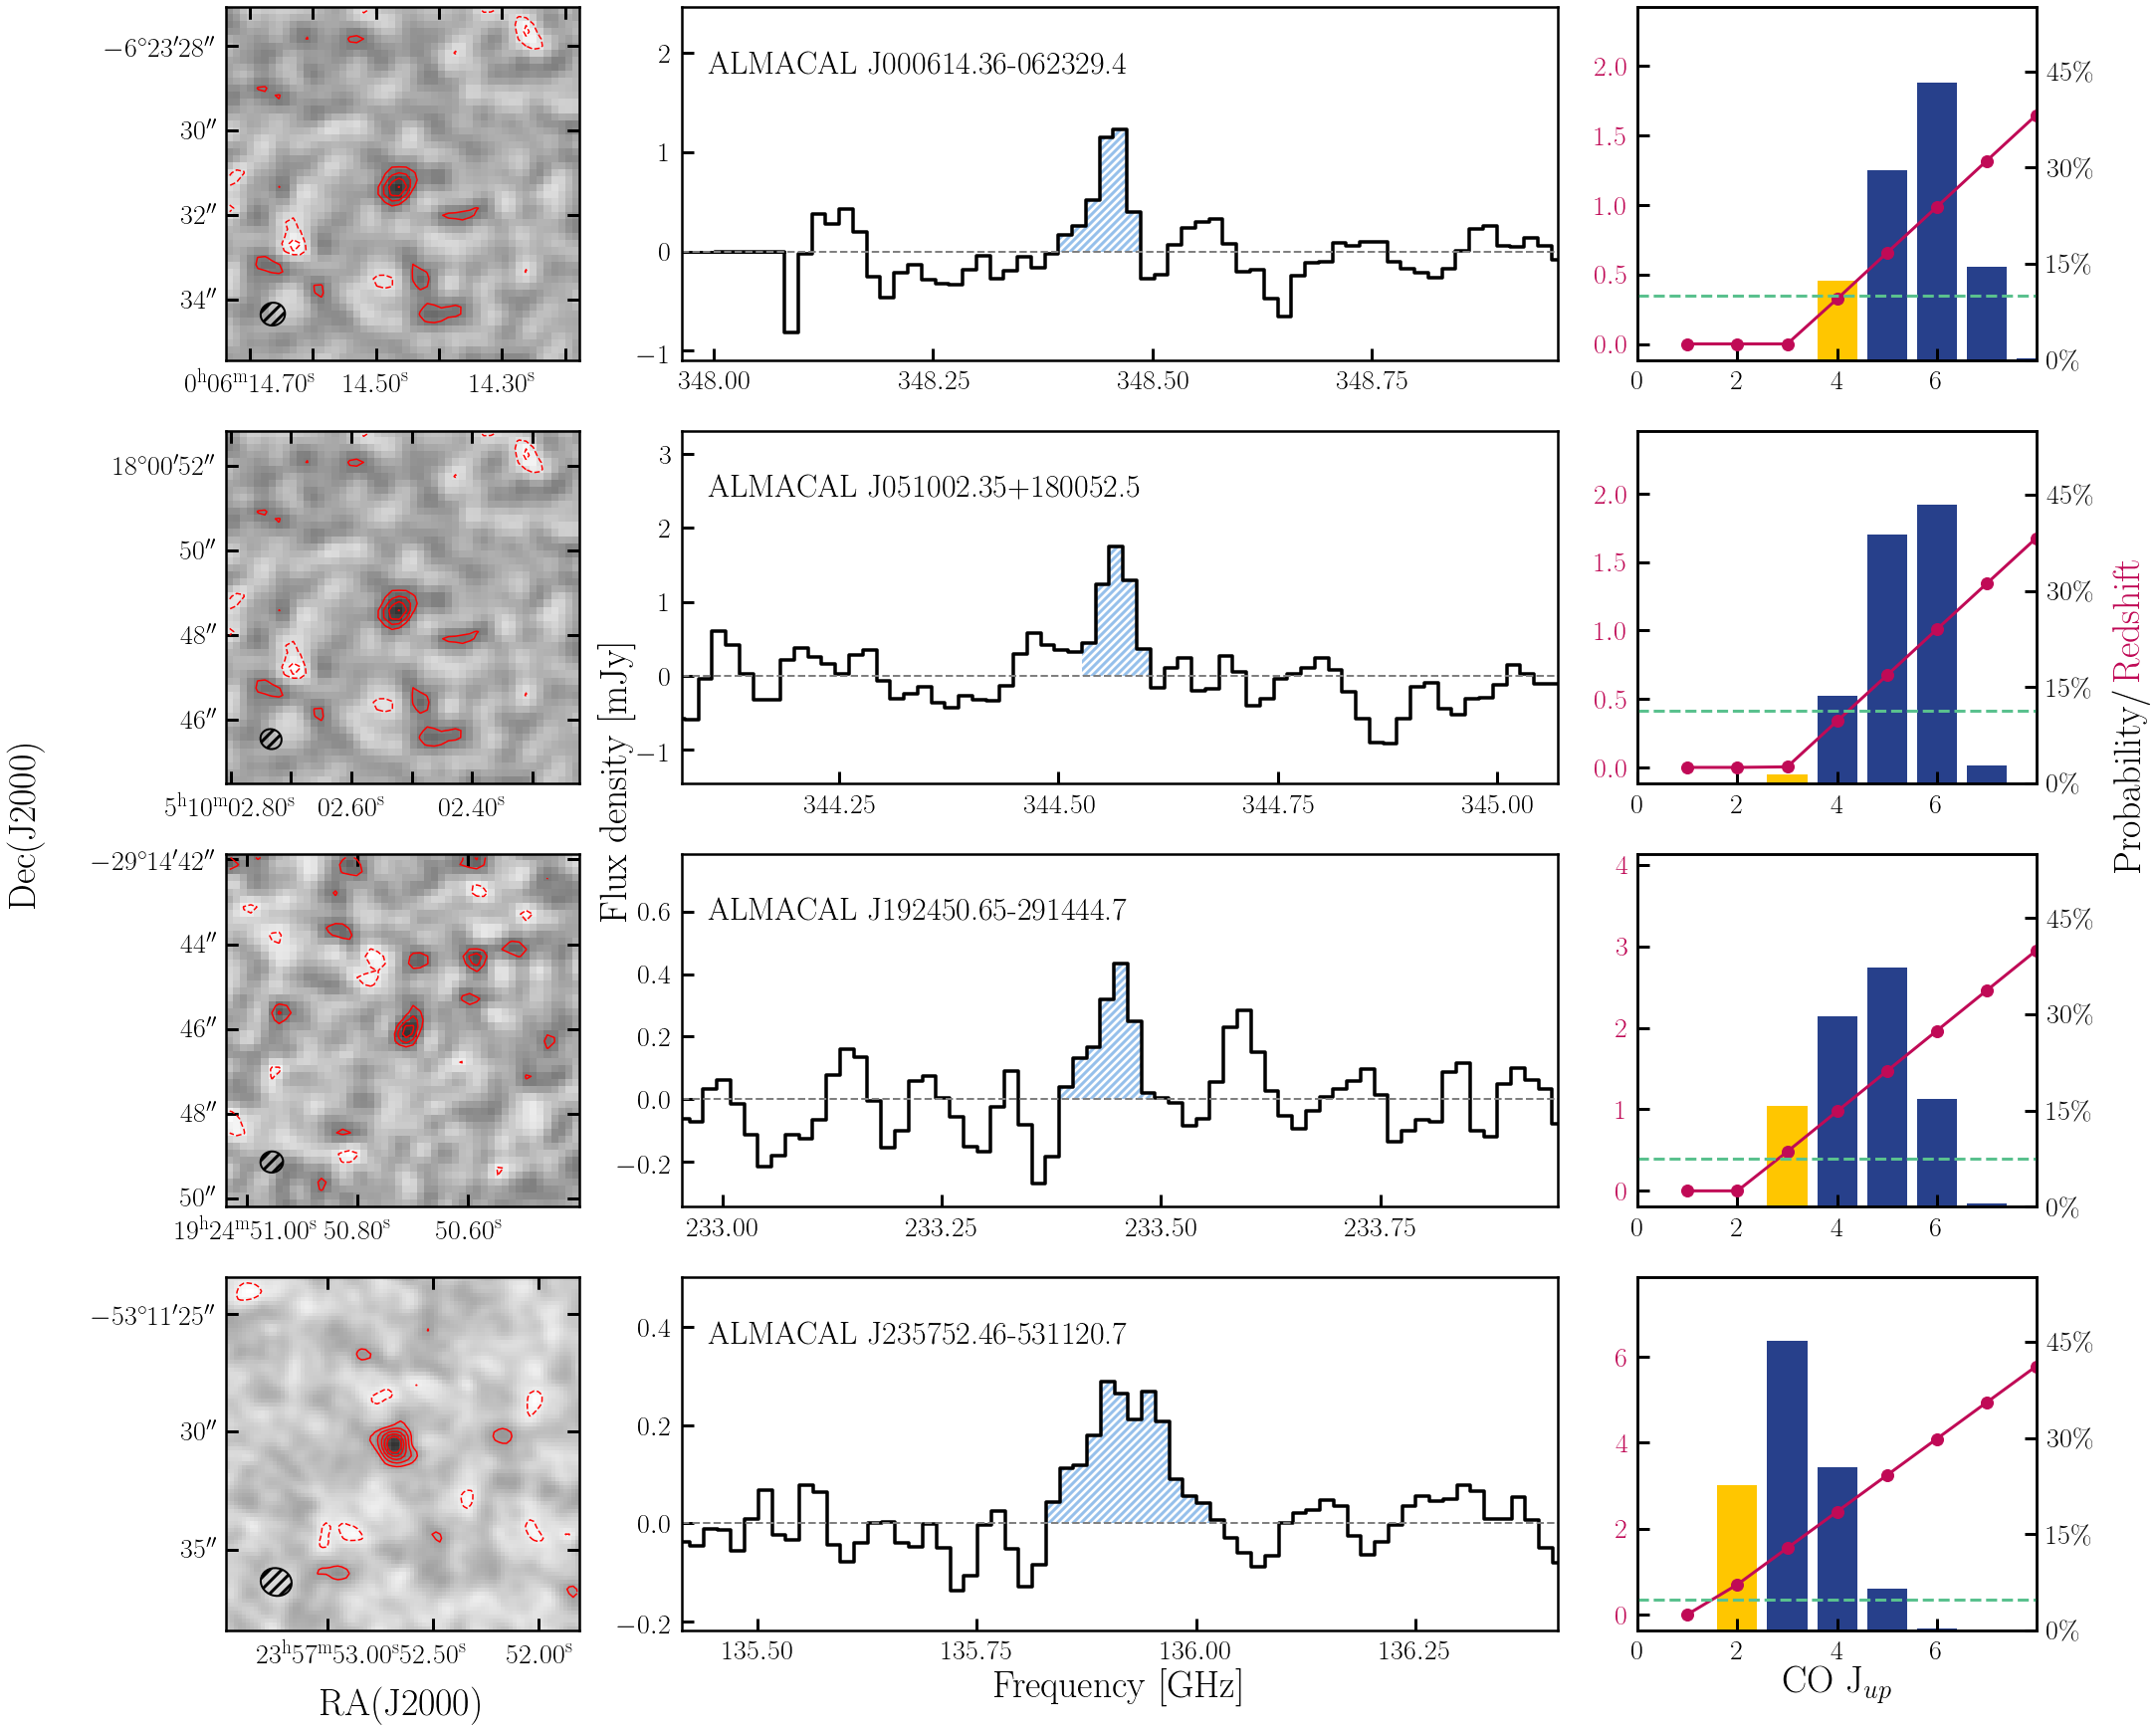

In [63]:
## Plot the detections with the transition probabilities
mpl.rcParams['hatch.linewidth'] = 3.0
mpl.rc ('xtick',labelsize=28)
mpl.rc ('ytick',labelsize=28)
mpl.rc('font',family='serif', size=38)
mpl.rcParams['axes.linewidth'] = 2.5
########## colours - Hogwart is my Home palette #######
#Hogwart is my Home palette
red='#b70000'
yellow='#ffc600'
blue='#000f9e'
green='#0f8400'

#Fruit salad	
beam='#cccccc'
contour='navy'#'#baffb0'
circ=red#'#ff6363'
########################################
def gaussian(x, amp, cen, wid):
    return amp * exp(-(x-cen)**2 /wid)

def freq_from_vel(f0,vel):
    f = f0*(1-vel/3.e5)
    return f

d=20
path="/Users/ahamanow/Desktop/ALMA/CO_search/ALMA_fields/candidates/"
cubes, clas,spectxt= np.loadtxt('candidates_list.txt', usecols=(1,12,19),dtype='str',comments='#', unpack=True) #edited version for plotting, original can be found under the path
X,Y,Z,Width, SN, w50, f0, rms, intflux = np.loadtxt('candidates_list.txt', usecols=(3,4,5,7,6,11,10,14,12),dtype='float', unpack=True)
mom0 = np.loadtxt("large.mom0.txt",dtype='str')
print(mom0)
#print X,Y,Z
#print clas
names=['ALMACAL J000614.36-062329.4','ALMACAL J051002.35+180052.5','ALMACAL J192450.65-291444.7','ALMACAL J235752.46-531120.7']
N = np.size(cubes)
chan_width =  0.0155639648438 #GHz
vel_lim=1000.
print(cubes)

#### probabiities
probabilities = np.array([
 [ 0 ,0 ,0, 12.328 ,29.65,43.29, 14.526,0.205, 0, 0,  ],
 [ 0 ,0, 1.403 ,13.666, 38.754, 43.413, 2.757, 0.007, 0, 0],
#[ 0 , 0 , 0, 13.035 ,34.386, 45.692, 6.793,0.094, 0, 0 ], 
 [ 0 ,0, 15.698 , 29.665, 37.253, 16.9, 0.483, 0, 0, 0 ],
 [0,  22.65, 45.071, 25.446, 6.541, 0.293, 0, 0, 0, 0.0 ]])

redshifts = np.array([
 [ 0 , 0 , 0 , 0.323 ,0.654 , 0.984 ,1.315 ,1.645 ,1.976 ,2.306 ],
 [ 0 ,0 , 0.004 , 0.338 , 0.672 , 1.007  , 1.341  ,1.675 , 2.009  , 2.343],
 #[ 0 , 0 , 0 , 0.329 , 0.662 , 0.994 , 1.326 , 1.658 , 1.990 , 2.322 ],
[  0 , 0 , 0.481 , 0.975 , 1.468 , 1.962 , 2.455 , 2.948 ,3.441, 3.934 ],
[  0 , 0.696 , 1.544 , 2.392 , 3.24 , 4.088 , 4.935 , 5.782 , 6.629 , 7.476 ]])

blazar=np.array([0.347,0.416, 0.4, 0.35, 1.006])


contours=np.array([
    [-0.06,-0.049,-0.038,0.038,0.049,0.06],
    [ -0.117,  -0.102,-0.086, -0.07, 0.07,0.086, 0.102, 0.117],   
   # [-0.102,-0.0681, 0.0681,0.102],
    [-0.0612- 0.049,-0.0368,-0.0246,0.0246,0.0368, 0.049, 0.0612],
    [-0.1257,-0.1006,-0.0755,-0.0504,0.0504,0.0755,0.1006,0.1257]])

lowestJ=np.array([4,3,3,2])

pb_corr=np.array([0.4468, 0.2997, 0.355, 0.636])

fig=plt.figure(1,figsize=(33,30))

red='#c00a56'
hist='#27408b'

n=0
fordash='#96c0eb'
sub=4
M=4
for i in range(0,M,1):

    stats = cubes[i]+".stats"
    with open("/Users/ahamanow/Desktop/ALMA/CO_search/ALMA_fields/cubes_stats/"+stats) as f:
        content = f.read().splitlines()
    a,b = content[3].split('\t')[1].split(' ')
    pa = content[4].split('\t')[1].split(' ')[0]
    #print(pa)

   
    beam_a,beam_b, beam_pa =float(a),float(b),float(pa)

    #read in 0-moment map from CASA
    mom0map = "/Users/ahamanow/Desktop/ALMA/almacal-deep-figures/"+mom0.T[i]
    hdul_mom0 = fits.open(mom0map)
    mom0_map = hdul_mom0[0].data
    wcs = WCS(hdul_mom0[0].header)

    wcs=wcs.dropaxis(2)
    #mom0sigma = float(mom0.T[1][i])

    ax1 = plt.subplot2grid((sub,4),(i,1), colspan=2)
    ax2 = plt.subplot2grid((sub,4),(i,0),projection=wcs)
    ax3 = plt.subplot2grid((sub,4),(i,3))
    #probability
    ax3.bar(range(1,11,1),probabilities[i], color=hist)
    
    print(blazar[i])
    lowJ=lowestJ[i]
    ax3.bar(lowJ, probabilities[i][lowJ-1], color='#ffc600')
    #ax3.annotate(names[i], (0.4,0.88), xycoords='axes fraction', fontsize=15)
    ax32 = ax3.twinx() 
    ax32.plot(range(1,11,1), redshifts[i], 'o-',color=red, lw=3, ms=12 )
    ax32.axhline(blazar[i], ls='--', c='#5ac18e', lw=3)
    ax3.set_ylim([0,55])
    ax3.set_xticks([0,2,4,6])
    ax3.set_xlim([0,8])
    ax32.tick_params(axis='y', labelcolor=red)


    #aperture spectrum
    spec = np.loadtxt("/Users/ahamanow/Desktop/ALMA/almacal-deep-figures/aperture-spectra/"+spectxt[i], comments='#')

    ## spectrum stats
    flux = spec.T[1]*pb_corr[i]
    med=np.median(flux)*1.e3
    sigma=np.std(flux)*1.e3
    mean = np.mean(flux)*1.e3	
    rms = np.sqrt(np.sum(flux**2))
    #print("mean", mean)
    ## ax1 - zoomed spectrum over detection
    ax1.step(spec.T[0],flux*1e3, c='k', where='pre', lw=3.5)
    #print(f0[i])
    f1,f2 = min(f0[i]-.5,f0[i]+.5), max(f0[i]-.5,f0[i]+.5) #freq_from_vel(f0[i], -vel_lim),freq_from_vel(f0[i], vel_lim)
    ax1.set_xlim([f1,f2])
    #ax1.axvline(f0[i], ls='--', lw=2, c='gray')

    ax1.fill_between(spec.T[0][int(Z[i] - Width[i]/2.)+1:int(Z[i] +Width[i]/2.)],flux[int(Z[i] - Width[i]/2.)+1:int(Z[i] +Width[i]/2.)]*1e3, step='pre', facecolor='none', edgecolor='#96c0eb', hatch='///',lw=0)
    ax1.set_ylim(mean- 3.5*sigma, mean+8*sigma)
    if "J0006" in names[i]:
        ax1.plot([347.3,348.08],[0,0], '-',c='k',lw=3)
    if "J0510" in names[i]:
        ax1.plot([343,343.8],[0,0],'-', c='k',lw=3)

    if "J0334" in names[i]:
        c='#00cc00'
        ax3.annotate("", xy=(1, 40), xytext=(1, 60), arrowprops=dict(arrowstyle="->",color=c, lw=3))	
        ax3.annotate("observed z", xy=(0.2, 65), c=c)		

    ax1.xaxis.set_major_locator(MaxNLocator(4))
    ax1.annotate(names[i], (0.03,0.81), xycoords='axes fraction', fontsize=32)
    ax1.tick_params('both', direction="in", length=12,width=3, pad=10)
    ax1.tick_params('both', direction="in", length=12,width=3, pad =10)
    ax1.axhline(0, ls='--', lw=2, c='gray')
    #if i in [12,13]:
    #	ax1.annotate("no-CO", (0.7,0.9), xycoords='axes fraction', fontsize=12)
    #### fits image ######
    ## plot the zoomed fits + beam

    box = AnchoredAuxTransformBox(ax2.transData, loc=3,frameon=False)
    el = Ellipse((0,0), width=beam_b, height=beam_a, angle=beam_pa,fc="none",ec='k',lw=2, hatch='//') 
    box.drawing_area.add_artist(el)
    ra = ax2.coords[0]
    ra.set_major_formatter('hh:mm:ss.ss')

    cx,cy=int(np.shape(mom0_map[0])[0]/2.),int(np.shape(mom0_map[0])[1]/2.)
    dx,dy=25,25

    if "J0006" in names[i]:
        cx+=2
    if "J2357" in names[i]:
        dx,dy=45,45
        #cy+=5
    if "J1924" in names[i]:
        cy -=5
    if "J0510" in names[i]:
        m = mom0_map[0]
        S = np.shape(m)[1]
        m2 = np.zeros((np.shape(m)[0],S))
        y = np.append(m,m2, axis=0)
        print(np.shape(y), np.shape(x))
        cx,cy=int(np.shape(y)[0]/2.),int(np.shape(y)[1]/2.)
        print(cx,cy)
        cx-=12
        cy-=15

    elif "J0510" in names[i]: 
        
        L =y[cx-dx:cx+dx,cy-dy:cy+dy]
        print(cx-dx,cx+dx,cy-dy,cy+dy)
        print(np.shape(y))
        print(np.shape(L), cy, dy, np.shape(y))
    else:
        L =mom0_map[0][cx-dx:cx+dx,cy-dy:cy+dy]
    ax2.imshow(L, cmap='binary', alpha=0.8)
    std = np.std(L)
    print(np.shape(L))
    #print(np.mean(L), np.std(L), np.max(L))
    contours=[-4*std, -3*std, -2*std, 2*std, 3*std, 4*std, 5*std, 6*std]
    ax2.contour(L, levels=contours, colors='red', linewidths=1.5, interpolation='gaussian') 
    ax2.add_artist(box)
#     ax2.imshow(mom0_map[0], cmap='viridis') 
#     ax2.contour(mom0_map[0], levels=contours[i], colors='#c71585', linewidths=3.5, interpolation='gaussian') 
#     ax2.add_artist(box)

    lon = ax2.coords[0]
    lat = ax2.coords[1]
    lon.set_ticks(exclude_overlapping=True)
    lon.tick_params('both', direction="in", length=12,width=3,pad=10)
    lat.tick_params('both', direction="in", length=12,width=3,pad=10)
    lat.set_ticks(exclude_overlapping=True)
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')

    ax3.yaxis.set_label_position("right")
    ax32.yaxis.set_label_position("left")
    ax3.yaxis.tick_right()
    ax32.yaxis.tick_left()
    ax3.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax3.yaxis.set_major_locator(MaxNLocator(4))
    ax3.tick_params('both', direction="in", length=12,width=3,pad=10)
    ax32.tick_params('both', direction="in", length=12,width=3,pad=10)

    if i == M-1:
        ax2.set_xlabel('RA(J2000)')
        ax1.set_xlabel('Frequency [GHz]')
        ax3.set_xlabel(r'CO J$_{up}$')
    if i == M-2 and i > 5 :
        ax1.set_ylabel('Flux density [mJy]')
        ax2.set_ylabel('Dec(J2000)')
        ax32.set_ylabel("Redshfit",c=red)
        ax3.set_ylabel("Probability")

    if i == M-2 and i < 5 :
        fig.text(0.94, 0.52, 'Probability/', ha='center', va='center', rotation='vertical',)
        fig.text(0.94, 0.595, 'Redshift', ha='center', va='center', rotation='vertical', c=red, )
        fig.text(0.3, 0.52, 'Flux density [mJy]', ha='center', va='center', rotation='vertical', c='k',)
        fig.text(0.05, 0.5, 'Dec(J2000)', ha='center', va='center', rotation='vertical', c='k',)

plt.show()
fig.savefig("ALMACAL-CO-detections.png",bbox_inches='tight')

